In [1]:
#ASE model

In [28]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ase import Atom
from ase import Atoms
from ase.io import read, write
from ase.build import surface, cut
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from ase.visualize import view
import pyace
#import aimsgb
#from aimsgb import GrainBoundary, Grain
import os
import shutil
import datetime
import time
import re
import sys
import copy
import csv
import subprocess
from scipy.interpolate import griddata
from ase.constraints import FixedLine

In [3]:
#Safty copy of the ML_Potential: /nfshome/karanikv/TU-Darmstadt-Work/Ga2CuAgSe4/2024_11_19_Potential_Training_GPU_HOREKA/2/output_potential.yace in nfshome/okresa/
path_to_pot = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ML_Potential"
potential_name = "potential_iteration_1559_new_kappa_0p05.yaml"
#ASI_name = ""

print(f'Path_to_potential: {path_to_pot}/{potential_name}')
pot = pyace.PyACECalculator(f'{path_to_pot}/{potential_name}')
#ASI = f'{path_to_pot}/{ASI_name}'
#pot.set_active_set(ASI)

Path_to_potential: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ML_Potential/potential_iteration_1559_new_kappa_0p05.yaml


In [4]:
def gb_energy(atoms, eref_Cu, eref_Ag, xAg=0):
    a, b = atoms.cell[0], atoms.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    Energy_uncorrect = atoms.get_potential_energy()
    e = Corrected_Energy(Energy_uncorrect,atoms)
    return (e - len(atoms) *((1 - xAg) * eref_Cu + xAg * eref_Ag)) / (2*A)


def gb_energy_averaged(atoms, eref_Cu, eref_Ag, xAg=0):
    a, b = atoms.cell[0], atoms.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    #set e_avr variable after avaraging script
    return (e_avr - len(atoms) *((1 - xAg) * eref_Cu + xAg * eref_Ag)) / (2*A)


#Energy was omitted to fit a graph and must be recorrected
def Corrected_Energy(Energy_uncorrect,atoms):
    Number_Atoms = list(atoms.symbols)
    Ag_number = Number_Atoms.count('Ag')
    Cu_number = Number_Atoms.count('Cu')
    Ga_number = Number_Atoms.count('Ga')
    Se_number = Number_Atoms.count('Se')
    
    E_Ag = -0.07060507
    E_Cu = -0.06457733
    E_Ga = -0.07974831
    E_Se = -0.16179301
    return Energy_uncorrect + Ag_number*E_Ag + Cu_number*E_Cu + Ga_number*E_Ga + Se_number*E_Se


def optimize(atoms, fmax=0.1, write=False, fname=None):
    # Constrain each atom individually along the z-direction
    indices1 = [atom.index for atom in atoms]
    #c = FixedLine(indices=indices, direction=[0, 0, 1])
    indices = list(range(len(atoms)))  # Ensure indices is a list of atom indices
    CC = []
    for index in indices:
        CC.append(FixedLine(index, [0, 0, 1]))
    atoms.set_constraint(CC)

    # Initialize and run the BFGS optimizer
    opt = BFGS(atoms)
    opt.run(fmax=fmax,steps=250)

    # Optionally write the optimized structure to a file
    if write:
        if fname:
            atoms.write("{}".format(fname), vasp5=True, direct=True, sort=True)
        else:
            atoms.write("opt.POSCAR", vasp5=True, direct=True, sort=True)

    return None


def optimize1(atoms, fmax=0.001, mask=(1, 1, 1, 0, 0, 0), write=False, fname=None):
    opt = BFGS(atoms)
    opt.run(fmax=fmax,steps=250)
    ucf = UnitCellFilter(atoms,constant_volume=True, mask=mask)
    #ucf = UnitCellFilter(atoms,constant_volume=False, mask=mask)
    opt = BFGS(ucf)
    opt.run(fmax=fmax,steps=250)
    if write:
        if fname:
            atoms.write("{}".format(fname), vasp5=True, direct=True, sort=True)
        else:
            atoms.write("opt.POSCAR", vasp5=True, direct=True, sort=True)

    return None


def make_cell_diagonal(atoms):
    # Get the cell matrix
    cell = atoms.get_cell()

    # Compute the transformation matrix that makes the cell diagonal
    # Use Singular Value Decomposition (SVD)
    U, _, Vt = np.linalg.svd(cell)
    transformation_matrix = np.dot(U, Vt)

    # Apply the transformation to the cell
    new_cell = np.dot(cell, transformation_matrix.T)
    atoms.set_cell(new_cell, scale_atoms=False)

    # Apply the transformation to the atomic positions
    new_positions = np.dot(atoms.get_positions(), transformation_matrix.T)
    atoms.set_positions(new_positions)

    return atoms


def make_cell_tetragonal(atoms):
    # Get the cell matrix
    cell = atoms.get_cell()

    # Compute the transformation matrix that makes the cell diagonal
    U, _, Vt = np.linalg.svd(cell)
    transformation_matrix = np.dot(U, Vt)

    # Apply the transformation to the cell
    new_cell = np.dot(cell, transformation_matrix.T)

    # Ensure the new cell is diagonal
    new_cell = np.diag(np.diag(new_cell))

    # Make the cell tetragonal: Set a and b equal, c can be different
    a = (new_cell[0, 0] + new_cell[1, 1]) / 2
    new_cell[0, 0] = a
    new_cell[1, 1] = a

    # Apply the transformation to the atomic positions
    atoms.set_cell(new_cell, scale_atoms=False)
    new_positions = np.dot(atoms.get_positions(), transformation_matrix.T)
    atoms.set_positions(new_positions)

    return atoms



In [5]:
#new functions:

def get_layer_delete_input():
    # Prompt user for input
    Layer_delete_input = input("Delete a stoichiometric layer? (No[default]/left/right/custom): N/l/r/c: ").strip().lower()

    # Handle left deletion
    if Layer_delete_input == 'l':
        print("selected_side set to 'L' (Delete atom with lowest z-coordinate).")
        return "L", 1  # Set for min z-coordinate

    # Handle right deletion
    elif Layer_delete_input == 'r':
        print("selected_side set to 'R' (Delete atom with highest z-coordinate).")
        return "R", 1  # Set for max z-coordinate

    # Handle custom deletion
    elif Layer_delete_input == 'c':
        custom_input = input("Enter custom format (Nr.)_L/R (e.g., 2_L or 3_R): ").strip().upper()
        try:
            # Parse the custom input
            Nr_of_deleted_layers, selected_side = custom_input.split('_')
            print(f"selected_side: {selected_side}")
            Nr_of_deleted_layers = int(Nr_of_deleted_layers)  # Convert the number to an integer
            print(f"Nr_of_deleted_layers: {Nr_of_deleted_layers}")
            if selected_side not in ['L', 'R']:
                raise ValueError("Layer_delete should be either 'L' or 'R'.")
            print(f"selected_side set to '{selected_side.upper()}' and number of layers to delete: {Nr_of_deleted_layers}.")
            return selected_side.upper(), Nr_of_deleted_layers
        except ValueError as e:
            print(f"Invalid custom input: {e}")
            return None, None  # Return None if the custom input is invalid

    else:
        print("Skipping layer deletion.")
        return "L", 0  # No deletion


def find_and_delete_atoms(atoms, selected_side, Nr_of_deleted_layers, selection_tolerance=0.5):
    # Get the positions of all atoms
    positions = atoms.positions
    #view(atoms)

    # Run the deletion process for Nr_of_deleted_layers times
    for delete_round in range(Nr_of_deleted_layers):
        
        # Initialize variables
        target_index = None
        target_value = None

        if selected_side == "L":
            # Find the atom with the lowest z-coordinate
            target_value = float('inf')  # Start with a very large value
            for i, pos in enumerate(positions):
                z = pos[2]  # Z-coordinate is the third element in the position tuple
                if z < target_value:
                    target_value = z
                    target_index = i
            print(f"Atom with lowest z-coordinate: {atoms[target_index]} at index {target_index}")
        
        elif selected_side == "R":
            # Find the atom with the highest z-coordinate
            target_value = float('-inf')  # Start with a very low value
            for i, pos in enumerate(positions):
                z = pos[2]  # Z-coordinate is the third element in the position tuple
                if z > target_value:
                    target_value = z
                    target_index = i
            print(f"Atom with highest z-coordinate: {atoms[target_index]} at index {target_index}")
        
        else:
            print("Invalid value for selected_side. Please set it to 'L' or 'R'.")
            return None
        
        # Apply selection_tolerance: Find atoms within the tolerance range of the target z-coordinate
        atoms_to_delete = []
        for i, pos in enumerate(positions):
            z = pos[2]
            if abs(z - target_value) <= selection_tolerance:
                atoms_to_delete.append(i)

        if atoms_to_delete:
            print(f"Atoms within {selection_tolerance} tolerance of the target z-coordinate: {atoms[atoms_to_delete[0]]} to {atoms[atoms_to_delete[-1]]}")
        
        # Delete the selected atoms
        for idx in sorted(atoms_to_delete, reverse=True):  # Delete in reverse order to avoid index shifting
            print(f"Deleting atom at index {idx}: {atoms[idx]}")
            atoms.pop(idx)
        
        # Update the positions after deletion (since the index shifts after pop)
        positions = atoms.positions  # Re-fetch the updated positions

    return atoms



def find_and_swap_atoms(atoms, selected_side, Nr_of_deleted_layers, selection_tolerance=0.5, visually_destinct_element="Bi"):
    # Get the positions of all atoms
    positions = atoms.positions
    
    # Run the swap process for Nr_of_deleted_layers times
    for delete_round in range(Nr_of_deleted_layers):
        
        # Initialize variables
        target_index = None
        target_value = None

        if selected_side == "L":
            # Find the atom with the lowest z-coordinate
            target_value = float('inf')  # Start with a very large value
            for i, pos in enumerate(positions):
                z = pos[2]  # Z-coordinate is the third element in the position tuple
                if z < target_value:
                    target_value = z
                    target_index = i
            if Layer_delete_input != "skip":
                print(f"Atom with lowest z-coordinate: {atoms[target_index]} at index {target_index}")
        
        elif selected_side == "R":
            # Find the atom with the highest z-coordinate
            target_value = float('-inf')  # Start with a very low value
            for i, pos in enumerate(positions):
                z = pos[2]  # Z-coordinate is the third element in the position tuple
                if z > target_value:
                    target_value = z
                    target_index = i
            if Layer_delete_input != "skip":
                print(f"Atom with highest z-coordinate: {atoms[target_index]} at index {target_index}")
        
        else:
            print("Invalid value for selected_side. Please set it to 'L' or 'R'.")
            return None
        
        # Apply selection_tolerance: Find atoms within the tolerance range of the target z-coordinate
        atoms_to_swap = []
        for i, pos in enumerate(positions):
            z = pos[2]
            if abs(z - target_value) <= selection_tolerance:
                atoms_to_swap.append(i)

        if atoms_to_swap:
            if Layer_delete_input != "skip":
                print(f"Atoms within {selection_tolerance} tolerance of the target z-coordinate: {atoms[atoms_to_swap[0]]} to {atoms[atoms_to_swap[-1]]}")
        
        # Swap the selected atoms with new atoms of the visually distinct element
        for idx in sorted(atoms_to_swap, reverse=True):  # Iterate in reverse order to avoid index shifting
            if Layer_delete_input != "skip":
                print(f"Swapping atom at index {idx}: {atoms[idx]} with {visually_destinct_element}")
            # Replace the atom with a new one of the selected element (visually_destinct_element)
            atoms[idx].symbol = visually_destinct_element
        
        # Update the positions after swapping (though positions remain unchanged)
        positions = atoms.positions  # Re-fetch the updated positions
    
    return atoms

def delete_atoms_by_element(atoms, visually_destinct_element):
    """
    Function to delete all atoms of a specific element from the Atoms object.

    Parameters:
    atoms (ASE Atoms object): The atoms object from which atoms will be deleted.
    visually_destinct_element (str): The element symbol (e.g., 'Bi') that needs to be removed from atoms.

    Returns:
    Atoms: Updated Atoms object with the specified element deleted.
    """
    # Create a list of indices to delete
    indices_to_delete = [i for i, atom in enumerate(atoms) if atom.symbol == visually_destinct_element]
    
    # Delete the atoms by the indices
    for index in sorted(indices_to_delete, reverse=True):  # Reverse sorting to avoid index shifting
        del atoms[index]

    return atoms

In [6]:
#define new new functions (section 8 and 9)

# 1. Find the center of the atoms object
def find_center_of_atoms(atoms):
    # The center is the mean of the positions
    center = np.mean(atoms.positions, axis=0)
    print(f"Center of the atoms: {center}")
    return center

# 2. Find the [Cu] atom closest to the center
def find_closest_atom_to_center(atoms, center, atom_type):
    """
    Finds the atom of type `atom_type` closest to the center of the atoms object.

    Parameters:
    - atoms: The ASE Atoms object.
    - center: The center coordinates of the atoms object.
    - atom_type: The type of atom to search for (e.g., 'Cu').

    Prints the index and coordinates of the closest atom of the specified type to the center.
    """
    # Extract the positions and symbols of the atoms
    positions = atoms.positions
    symbols = atoms.symbols

    # Find the indices of atoms that match the specified atom_type
    atom_indices = [i for i, symbol in enumerate(symbols) if symbol == atom_type]

    # If no atoms of the specified type are found, print a message and return
    if not atom_indices:
        print(f"No atoms of type {atom_type} found.")
        return

    # Calculate distances from the center to each atom of the specified type
    distances = [np.linalg.norm(pos - center) for i, pos in enumerate(positions) if i in atom_indices]

    # Find the index of the closest atom
    closest_atom_index = atom_indices[np.argmin(distances)]
    closest_atom_position = atoms.positions[closest_atom_index]

    print(f"Closest {atom_type} atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")
    return closest_atom_index, closest_atom_position


# 3. Swap the [Cu] atom closest to the center with Bi
def swap_atoms(atoms, atoms_to_swap, visually_destinct_element = "Bi"):
    """
    Swaps the selected atoms with new atoms of the visually distinct element.
    
    Parameters:
    - atoms: The list of atoms.
    - atoms_to_swap: List of atom indices to be swapped.
    - visually_destinct_element: The element to swap atoms with.
    
    Returns:
    - atoms: The modified atoms with the swapped atoms.
    """
    if isinstance(atoms_to_swap, int):
        print(f"The variable is an integer: {atoms_to_swap}")
        atoms[atoms_to_swap].symbol = visually_destinct_element
    elif isinstance(atoms_to_swap, list):
        print(f"The variable is a list: {atoms_to_swap}")
        for idx in sorted(atoms_to_swap, reverse=True):  # Iterate in reverse order to avoid index shifting
            # Replace the atom with a new one of the selected element (visually_distinct_element)
            print(f"Swapping atom at index {idx}: {atoms[idx]} with {visually_destinct_element}")
            atoms[idx].symbol = visually_destinct_element
    else:
        print("The variable is neither an integer nor a list.")

    return atoms

# Extra. Ask for a visulaisation of the GB
def ask_user_for_visuals(atoms, ask_to_check_visuals = "skip"):
    if ask_to_check_visuals != "skip":
        ask_to_check_visuals = input("Check with visualisation? y/N: ").strip().lower()
    if ask_to_check_visuals == 'y':
        #if y --> If possible manually fix it in ASE window 
        print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
        atoms.edit()
    else:
        print("Skipping visualistion.")

#4 select all atoms of one type and write them in a list: atoms_to_swap
def select_atoms_of_type(atoms, selected_atoms_type):
    """
    Selects all atoms of a specified type and returns their indices in a list.

    Parameters:
    - atoms: The ASE Atoms object.
    - selected_atoms_type: The type of atoms to select (e.g., 'Cu').
    
    Returns:
    - atoms_to_swap: A list of indices of atoms of the specified type.
    """
    # Extract the symbols of the atoms
    symbols = atoms.symbols
    
    # Find the indices of atoms that match the specified selected_atoms_type
    atoms_to_swap = [i for i, symbol in enumerate(symbols) if symbol == selected_atoms_type]

    return atoms_to_swap

    """
    # Example usage:
    atoms = Atoms('Cu3', positions=[[0, 0, 0], [1, 1, 1], [2, 2, 2]])
    # Specify the atom type you want to select
    selected_atoms_type = 'Cu'
    # Select the atoms and get their indices
    atoms_to_swap = select_atoms_of_type(atoms, selected_atoms_type)
    print(f"Indices of selected {selected_atoms_type} atoms: {atoms_to_swap}")
    """

#5 get a line of bulk_base atoms to replace:
def get_atoms_with_larger_z(atoms, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.1):
    """
    Finds the indices of all atoms of type `bulk_base` (e.g., 'Cu') that have a larger z-coordinate
    than the atom at `closest_atom_position` and are within `y_tolerance` in the y-coordinate.
    
    Parameters:
    - atoms: List of atom objects, each with 'element' (atom type) and 'coordinates' (x, y, z).
    - bulk_base: The atom type to search for (default is 'Cu').
    - closest_atom_position: The index of the closest atom to compare against.
    - y_tolerance: The allowed tolerance in the y-coordinate to consider the atom as within range.
    
    Returns:
    - distance_to_center_index_list: A list of indices of atoms meeting the conditions.
    """
    # define distance_to_center_index_list 
    distance_to_center_index_list = [closest_atom_index]
    # Get the coordinates of the closest atom
    #closest_atom = atoms[closest_atom_index]
    closest_atom_x = closest_atom_position[0]
    closest_atom_y = closest_atom_position[1]
    closest_atom_z = closest_atom_position[2]
    print(f"TEST 1: closest_atom_position: {closest_atom_position}")
    print(f"TEST 1: x = {closest_atom_x}, y = {closest_atom_y}, z = {closest_atom_z} ")
    # Iterate through the atoms to find matching atoms
    for idx, atom in enumerate(atoms):
        #atom(symbol='X', position=(0, 0, 0), tag=None, momentum=None, mass=None, magmom=None, charge=None, atoms=None, index=None)
        atom_x = atom.position[0]
        atom_y = atom.position[1]
        atom_z = atom.position[2]
        
         # Check if the z-coordinate of a bulk_base is larger then the center and the y-coordinate is within tolerance
        if atom.symbol == bulk_base and atom_z > closest_atom_z and abs(atom_y - closest_atom_y) <= y_tolerance:
            print(f"TEST 2: x = {atom_x}, y = {atom_y}, z = {atom_z}")
            distance_to_center_index_list.append(idx)      
    
    return distance_to_center_index_list

In [7]:
#Referece bulk energy (Eb) <--------- corrrected

ref_Cu = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2.POSCAR")
ref_Cu.set_calculator(pot)
optimize1(ref_Cu,write=True, fname="/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR")
eref_Cu_uncorrected = ref_Cu.get_potential_energy() / len(ref_Cu)
eref_Cu = Corrected_Energy(eref_Cu_uncorrected,ref_Cu)
print(f"\nRefecrence Bulk Energy Cu: {eref_Cu}\n")

ref_Ag = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/AgGaSe2.POSCAR")
ref_Ag.set_calculator(pot)
optimize1(ref_Ag,write=True, fname="/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/AgGaSe2_rel.POSCAR")
eref_Ag_uncorrected = ref_Ag.get_potential_energy() / len(ref_Ag)
eref_Ag = Corrected_Energy(eref_Ag_uncorrected,ref_Ag)
print(f"\nRefecrence Bulk Energy Ag: {eref_Ag}\n")

print("\n\nDONE")

/tmp/ipykernel_7493/3861164029.py:4: DeprecationWarning: Please use atoms.calc = calc
  ref_Cu.set_calculator(pot)


      Step     Time          Energy          fmax
BFGS:    0 14:22:59      -60.539534        0.030474
BFGS:    1 14:22:59      -60.539633        0.026715
BFGS:    2 14:23:00      -60.539964        0.000007
      Step     Time          Energy          fmax
BFGS:    0 14:23:00      -60.539964        0.033752
BFGS:    1 14:23:00      -60.539988        0.033623
BFGS:    2 14:23:00      -60.543144        0.014454
BFGS:    3 14:23:00      -60.543166        0.012604
BFGS:    4 14:23:00      -60.543242        0.000416

Refecrence Bulk Energy Cu: -5.655599272393642

      Step     Time          Energy          fmax
BFGS:    0 14:23:00      -56.023459        0.006862
BFGS:    1 14:23:00      -56.023464        0.006095
BFGS:    2 14:23:00      -56.023483        0.000000
      Step     Time          Energy          fmax
BFGS:    0 14:23:00      -56.023483        0.019965
BFGS:    1 14:23:00      -56.023492        0.019907
BFGS:    2 14:23:00      -56.024944        0.008026
BFGS:    3 14:23:00     

/tmp/ipykernel_7493/3855591964.py:58: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms,constant_volume=True, mask=mask)
/tmp/ipykernel_7493/3861164029.py:11: DeprecationWarning: Please use atoms.calc = calc
  ref_Ag.set_calculator(pot)


In [8]:
#common target for graphs in docs:
common_graph_folder = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection"
common_graph_path = Path(common_graph_folder) 

print(common_graph_path)


/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection


In [8]:
#ref_Cu1 = ref_Cu.copy() #read("CuGaSe2.POSCAR")
ref_Cu1 = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2.POSCAR")
ref_Cu1.set_calculator(pot)
optimize(ref_Cu1)
eref_Cu1 = ref_Cu1.get_potential_energy()

print("\n???")
print(gb_energy(ref_Cu1, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)


      Step     Time          Energy          fmax
BFGS:    0 16:45:29      -60.539534        0.000000

???
6.96285964932014


/tmp/ipykernel_40785/599102980.py:3: DeprecationWarning: Please use atoms.calc = calc
  ref_Cu1.set_calculator(pot)


In [9]:
#(1,-1,4) test 
#The distribution of grain boundary planes for the Σ9 boundary is similar: most boundaries have tilt character and the distribution maximizes at the position of the symmetric tilt.
#https://www.sciencedirect.com/science/article/pii/S1359645416305511

In [ ]:
#Attempt 1: 20_01 18:09

#bulk = read("CuGaSe2.POSCAR")
bulk = ref_Cu.copy()
#view(bulk) [CuGaSe2 Einheitszelle]

#relaxed1 = ref_Cu.copy()
#relaxed = relaxed1.cell
#cell = bulk.cell * (relaxed[0, 0] / bulk.cell[0, 0])


hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511         ZU VARIIREN I
GB = surface(bulk, hkl, 34, vacuum=0.0) #[34 hatte funktioniert]
#GB = surface(bulk, hkl, 34, vacuum=2.0) #[34 hatte funktioniert]

#GB = surface(bulk, hkl, 12, vacuum=10.0) #[34 hatte funktioniert]
#    surface(lattice, indices (TILT) , layers, vacuum=None, tol=1e-10, periodic=False)
#GB.write("GB_6.vasp", vasp5=True, sort=True, direct=True)
a1, b1, c1 = GB.get_cell()          
#GB.center(about=0.5*(a1+b1+c1)) #Center atoms in unit cell.

#view(GB)

#GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1))
#GB = cut(GB, a=(1, 0, 0), b=(-4,2, 0), c=(0, 0, 1))
#  = cut(atoms,a=(1, 0, 0),b=(0, 1, 0),c=None,clength=None,origo=(0, 0, 0),nlayers=None,extend=1.0,tolerance=0.01,maxatoms=None)
# Cuts out a cell defined by *a*, *b*, *c* and *origo* from a sufficiently repeated copy of *atoms*






#use if vaccum != 0.0
GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[155] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
Se = Atom('Se',(8.236, 17.204, 76.055))
#Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
#positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP()/Stöchometrie_test.ods
GB = GB + Se
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)

'''
GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[155] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)
'''

#view(GB)


#view(GB) #[right angled] [optional?]
#drauf acheten, dass der cut noch stöchometrisch ist!

# adjust position [of all atoms] by the 1 Angs vaccuum [Cu on 0 Angs]
#GB.set_positions(GB.get_positions()  - [0, 0, 1])
#GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,1]])

#view(GB)    

GB = GB.repeat((1,1,2)) #[bulk size on both sides] ZU VARIIREN II und III
GB.wrap()
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp')
#GB1.set_calculator(pot)
#optimize1(GB1)
GB = GB1.copy()


#view(GB)

#--------

# Flip the lower half [independent of bulk size]
pos = GB.get_scaled_positions()
center = 0.5
for i in range(len(pos)):
    if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
        pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
GB.set_scaled_positions(pos)
C1 = GB.get_cell()
C1[2,2] = C1[2,2] + 2.0
GB.set_cell(C1)
GB.center()

view(GB)

#hkl = (0,0,1)
#GB = surface(GB, hkl, 1, vacuum=5)
GB.wrap()

GB.set_calculator(pot)
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2.vasp", vasp5=True, sort=True, direct=True)

#view(GB)

print("\n\nDONE")

In [ ]:
#Attempt 2: 20_01 19:00



#bulk = read("CuGaSe2.POSCAR")
bulk = ref_Cu.copy()
#view(bulk) [CuGaSe2 Einheitszelle]

#relaxed1 = ref_Cu.copy()
#relaxed = relaxed1.cell
#cell = bulk.cell * (relaxed[0, 0] / bulk.cell[0, 0])


hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
#GB = surface(bulk, hkl, 34, vacuum=0.0) #[34 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=1.0) #[34 hatte funktioniert]
GB = surface(bulk, hkl, 12, vacuum=0.5) #[34 hatte funktioniert]

#GB = surface(bulk, hkl, 12, vacuum=10.0) #[34 hatte funktioniert]
#    surface(lattice, indices (TILT) , layers, vacuum=None, tol=1e-10, periodic=False)
#GB.write("GB_6.vasp", vasp5=True, sort=True, direct=True)
a1, b1, c1 = GB.get_cell()          
#GB.center(about=0.5*(a1+b1+c1)) #Center atoms in unit cell.

#view(GB)

#GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1))
#GB = cut(GB, a=(1, 0, 0), b=(-4,2, 0), c=(0, 0, 1))
#  = cut(atoms,a=(1, 0, 0),b=(0, 1, 0),c=None,clength=None,origo=(0, 0, 0),nlayers=None,extend=1.0,tolerance=0.01,maxatoms=None)
# Cuts out a cell defined by *a*, *b*, *c* and *origo* from a sufficiently repeated copy of *atoms*





'''
#use if vaccum != 0.0
GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[59] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
Se = Atom('Se',(8.236, 17.204, 76.055))
#Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
#positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
GB = GB + Se
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)
'''

GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[59] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)


#view(GB)


#view(GB) #[right angled] [optional?]
#drauf acheten, dass der cut noch stöchometrisch ist!

#adjust position [of all atoms] by the 1 Angs vaccuum [Cu on 0 Angs]
GB.set_positions(GB.get_positions()  - [0, 0, 1])
GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,1]])

#view(GB)    

GB = GB.repeat((1,1,2)) #[bulk size on both sides] ZU VARIIREN II und III
GB.wrap()
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp')
#GB1.set_calculator(pot)
#optimize1(GB1)
GB = GB1.copy()

#view(GB)

#--------

# Flip the lower half [independent of bulk size]
pos = GB.get_scaled_positions()
center = 0.5
for i in range(len(pos)):
    if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
        pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
GB.set_scaled_positions(pos)
C1 = GB.get_cell()
C1[2,2] = C1[2,2] + 2.0
GB.set_cell(C1)
GB.center()

GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
GB.center()

view(GB)

#hkl = (0,0,1)
#GB = surface(GB, hkl, 1, vacuum=5)
GB.wrap()

GB.set_calculator(pot)
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2.vasp", vasp5=True, sort=True, direct=True)

#view(GB)

print("\n\nDONE")

In [ ]:
#Attempt 3: 21_01 14:00 mostly SUCCESS!!!

#bulk = read("CuGaSe2.POSCAR")
bulk = ref_Cu.copy()
#view(bulk) [CuGaSe2 Einheitszelle]

#relaxed1 = ref_Cu.copy()
#relaxed = relaxed1.cell
#cell = bulk.cell * (relaxed[0, 0] / bulk.cell[0, 0])


hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
GB = surface(bulk, hkl, 36, vacuum=0.0) #[36 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=1.0) #[36 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=0.5) #[36 hatte funktioniert]

#GB = surface(bulk, hkl, 12, vacuum=10.0) #[34 hatte funktioniert]
#    surface(lattice, indices (TILT) , layers, vacuum=None, tol=1e-10, periodic=False)
#GB.write("GB_6.vasp", vasp5=True, sort=True, direct=True)
a1, b1, c1 = GB.get_cell()          
#GB.center(about=0.5*(a1+b1+c1)) #Center atoms in unit cell.

#view(GB)

#GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1))
#GB = cut(GB, a=(1, 0, 0), b=(-4,2, 0), c=(0, 0, 1))
#  = cut(atoms,a=(1, 0, 0),b=(0, 1, 0),c=None,clength=None,origo=(0, 0, 0),nlayers=None,extend=1.0,tolerance=0.01,maxatoms=None)
# Cuts out a cell defined by *a*, *b*, *c* and *origo* from a sufficiently repeated copy of *atoms*





'''
#use if vaccum != 0.0
GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[59] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
Se = Atom('Se',(8.236, 17.204, 76.055))
#Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
#positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
GB = GB + Se
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/src/ASE_related/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)
'''

GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[165] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)


view(GB)


#view(GB) #[right angled] [optional?]
#drauf acheten, dass der cut noch stöchometrisch ist!

#adjust position [of all atoms] by the 1 Angs vaccuum [Cu on 0 Angs]
GB.set_positions(GB.get_positions()  - [0, 0, 1])
GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,1]])

#view(GB)    

GB = GB.repeat((1,1,2)) #[bulk size on both sides] ZU VARIIREN II und III
GB.wrap()
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp')
#GB1.set_calculator(pot)
#optimize1(GB1)
GB = GB1.copy()

view(GB)

#--------

# Flip the lower half [independent of bulk size]
pos = GB.get_scaled_positions()
center = 0.5
for i in range(len(pos)):
    if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
        pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
GB.set_scaled_positions(pos)
C1 = GB.get_cell()
C1[2,2] = C1[2,2] + 2.0
GB.set_cell(C1)
GB.center()

GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
GB.center()

view(GB)

#hkl = (0,0,1)
#GB = surface(GB, hkl, 1, vacuum=5)
GB.wrap()

GB.set_calculator(pot)
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-final-S9-CuGaSe2.vasp", vasp5=True, sort=True, direct=True)

#view(GB)

print("\n\nDONE")

In [ ]:
#Attempt 3: 21_01 14:00 mostly SUCCESS

#bulk = read("CuGaSe2.POSCAR")
bulk = ref_Cu.copy()
#view(bulk) [CuGaSe2 Einheitszelle]

hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
GB = surface(bulk, hkl, 36, vacuum=0.0) #[36 hatte funktioniert]

#    surface(lattice, indices (TILT) , layers, vacuum=None, tol=1e-10, periodic=False)
#GB.write("GB_6.vasp", vasp5=True, sort=True, direct=True)
a1, b1, c1 = GB.get_cell()          
#GB.center(about=0.5*(a1+b1+c1)) #Center atoms in unit cell.

#view(GB)


GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[165] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
view(GB)
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)

#view(GB)
#drauf acheten, dass der cut noch stöchometrisch ist!

#adjust position [of all atoms] by the 1 Angs vaccuum [Cu on 0 Angs]
GB.set_positions(GB.get_positions()  - [0, 0, 1])
GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,1]])

#view(GB)    

GB = GB.repeat((1,1,2)) #[bulk size on both sides] ZU VARIIREN II und III
GB.wrap()
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp')
#GB1.set_calculator(pot)
#optimize1(GB1)
GB = GB1.copy()

#view(GB)

#--------

# Flip the lower half [independent of bulk size]
pos = GB.get_scaled_positions()
center = 0.5
for i in range(len(pos)):
    if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
        pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
GB.set_scaled_positions(pos)
C1 = GB.get_cell()
C1[2,2] = C1[2,2] + 2.0
GB.set_cell(C1)
GB.center()

GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
GB.center()

#view(GB)

GB.wrap()

GB.set_calculator(pot)
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-final-S9-CuGaSe2.vasp", vasp5=True, sort=True, direct=True)

view(GB)

print("\n\nDONE")

In [ ]:
#Attempt 4: 24_01 (1,1,4) same as 1 -1 -4 (redundant)

#bulk = read("CuGaSe2.POSCAR")
bulk = ref_Cu.copy()
#view(bulk) [CuGaSe2 Einheitszelle]

#relaxed1 = ref_Cu.copy()
#relaxed = relaxed1.cell
#cell = bulk.cell * (relaxed[0, 0] / bulk.cell[0, 0])


hkl = (1, 1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
GB = surface(bulk, hkl, 36, vacuum=0.0) #[36 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=1.0) #[36 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=0.5) #[36 hatte funktioniert]

#GB = surface(bulk, hkl, 12, vacuum=10.0) #[34 hatte funktioniert]
#    surface(lattice, indices (TILT) , layers, vacuum=None, tol=1e-10, periodic=False)
#GB.write("GB_6.vasp", vasp5=True, sort=True, direct=True)
a1, b1, c1 = GB.get_cell()          
#GB.center(about=0.5*(a1+b1+c1)) #Center atoms in unit cell.

view(GB)

#GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1))
#GB = cut(GB, a=(1, 0, 0), b=(-4,2, 0), c=(0, 0, 1))
#  = cut(atoms,a=(1, 0, 0),b=(0, 1, 0),c=None,clength=None,origo=(0, 0, 0),nlayers=None,extend=1.0,tolerance=0.01,maxatoms=None)
# Cuts out a cell defined by *a*, *b*, *c* and *origo* from a sufficiently repeated copy of *atoms*





'''
#use if vaccum != 0.0
GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[59] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
Se = Atom('Se',(8.236, 17.204, 76.055))
#Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
#positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
GB = GB + Se
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)
'''

GB = cut(GB, a=(1, 0, 0), b=(2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[165] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)


#view(GB)


#view(GB) #[right angled] [optional?]
#drauf acheten, dass der cut noch stöchometrisch ist!

#adjust position [of all atoms] by the 1 Angs vaccuum [Cu on 0 Angs]
GB.set_positions(GB.get_positions()  - [0, 0, 1])
GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,1]])

#view(GB)    

GB = GB.repeat((1,1,2)) #[bulk size on both sides] ZU VARIIREN II und III
GB.wrap()
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp')
#GB1.set_calculator(pot)
#optimize1(GB1)
GB = GB1.copy()

#view(GB)

#--------

# Flip the lower half [independent of bulk size]
pos = GB.get_scaled_positions()
center = 0.5
for i in range(len(pos)):
    if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
        pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
GB.set_scaled_positions(pos)
C1 = GB.get_cell()
C1[2,2] = C1[2,2] + 2.0
GB.set_cell(C1)
GB.center()

GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
GB.center()

view(GB)

#hkl = (0,0,1)
#GB = surface(GB, hkl, 1, vacuum=5)
GB.wrap()

GB.set_calculator(pot)
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-1_1_4-S9-CuGaSe2.vasp", vasp5=True, sort=True, direct=True)

#view(GB)

print("\n\nDONE")

In [ ]:
#Attempt 5: 24_01 16:00 rattle

#bulk = read("CuGaSe2.POSCAR")
bulk = ref_Cu.copy()
#view(bulk) [CuGaSe2 Einheitszelle]

#relaxed1 = ref_Cu.copy()
#relaxed = relaxed1.cell
#cell = bulk.cell * (relaxed[0, 0] / bulk.cell[0, 0])


hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
GB = surface(bulk, hkl, 36, vacuum=0.0) #[36 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=1.0) #[36 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=0.5) #[36 hatte funktioniert]

#GB = surface(bulk, hkl, 12, vacuum=10.0) #[34 hatte funktioniert]
#    surface(lattice, indices (TILT) , layers, vacuum=None, tol=1e-10, periodic=False)
#GB.write("GB_6.vasp", vasp5=True, sort=True, direct=True)
a1, b1, c1 = GB.get_cell()          
#GB.center(about=0.5*(a1+b1+c1)) #Center atoms in unit cell.

#view(GB)

#GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1))
#GB = cut(GB, a=(1, 0, 0), b=(-4,2, 0), c=(0, 0, 1))
#  = cut(atoms,a=(1, 0, 0),b=(0, 1, 0),c=None,clength=None,origo=(0, 0, 0),nlayers=None,extend=1.0,tolerance=0.01,maxatoms=None)
# Cuts out a cell defined by *a*, *b*, *c* and *origo* from a sufficiently repeated copy of *atoms*





'''
#use if vaccum != 0.0
GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[59] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
Se = Atom('Se',(8.236, 17.204, 76.055))
#Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
#positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
GB = GB + Se
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)
'''

GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[165] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)


#view(GB)


#view(GB) #[right angled] [optional?]
#drauf acheten, dass der cut noch stöchometrisch ist!

#adjust position [of all atoms] by the 1 Angs vaccuum [Cu on 0 Angs]
GB.set_positions(GB.get_positions()  - [0, 0, 1])
GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,1]])

#view(GB)    

GB = GB.repeat((1,1,2)) #[bulk size on both sides] ZU VARIIREN II und III
GB.wrap()
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp')
#GB1.set_calculator(pot)
#optimize1(GB1)
GB = GB1.copy()

#view(GB)

#--------

# Flip the lower half [independent of bulk size]
pos = GB.get_scaled_positions()
center = 0.5
for i in range(len(pos)):
    if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
        pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
GB.set_scaled_positions(pos)
C1 = GB.get_cell()
C1[2,2] = C1[2,2] + 2.0
GB.set_cell(C1)
GB.center()

GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
GB.center()

view(GB)

#hkl = (0,0,1)
#GB = surface(GB, hkl, 1, vacuum=5)
GB.wrap()

GB.rattle(stdev=0.05, seed=None, rng=None)

view(GB)

GB.set_calculator(pot)
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-rattle-S9-CuGaSe2.vasp", vasp5=True, sort=True, direct=True)

#view(GB)

print("\n\nDONE")

In [ ]:
#Attempt side 1: 21_01 13:00 Sigma 3 (mixed GB)


#bulk = read("CuGaSe2.POSCAR")
bulk = ref_Cu.copy()
#view(bulk) [CuGaSe2 Einheitszelle]

'''
bulk = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2.POSCAR")
relaxed1 = ref_Cu.copy()
relaxed = relaxed1.cell

cell = bulk.cell * (relaxed[0, 0] / bulk.cell[0, 0])
bulk.set_cell(cell, scale_atoms=True)

hkl = (1, 1, 2)
GB = surface(bulk, hkl, 6, vacuum=1.0)
a1, b1, c1 = GB.get_cell()
GB.center(about=0.5 * (a1 + b1 + c1))

view(GB)

'''
hkl = (1, 1, 2) #[woher] --> https://pubs.rsc.org/en/content/articlehtml/2017/sc/c7cp02033c      ZU VARIIREN I

GB = surface(bulk, hkl, 12, vacuum=1.0) 
#GB = surface(bulk, hkl, 12, vacuum=0.5) 
#GB = surface(bulk, hkl, 12, vacuum=0.0)
#GB = surface(bulk, hkl, 6, vacuum=1.0)

#    surface(lattice, indices (TILT) , layers, vacuum=None, tol=1e-10, periodic=False)
#GB.write("GB_6.vasp", vasp5=True, sort=True, direct=True)
a1, b1, c1 = GB.get_cell()          
GB.center(about=0.5*(a1+b1+c1)) #Center atoms in unit cell.

#view(GB)
#'''

#GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1))
#GB = cut(GB, a=(1, 0, 0), b=(-4,2, 0), c=(0, 0, 1))
#  = cut(atoms,a=(1, 0, 0),b=(0, 1, 0),c=None,clength=None,origo=(0, 0, 0),nlayers=None,extend=1.0,tolerance=0.01,maxatoms=None)
# Cuts out a cell defined by *a*, *b*, *c* and *origo* from a sufficiently repeated copy of *atoms*

GB = cut(GB, a=(1, 0, 0), b=(2.01, 2.01, 0), c=(0, 0, 1)) 
#view(GB)
del GB[386] #"del GB[index]" deletes a Cu Atom at 0.001 26.956 26.096 that needed to be removed with the cut (find index in view window by clicking on problem)
del GB[386] #"del GB[index]" deletes a Ga Atom at 4.128 26.956 26.096 that needed to be removed with the cut (find index in view window by clicking on problem)
del GB[384] #"del GB[index]" deletes a Cu Atom at 6.191 26.952 14.048 that needed to be removed with the cut (find index in view window by clicking on problem)
del GB[384] #"del GB[index]" deletes a Ga Atom at 2.065 26.952 14.048 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)

#GB = cut(GB, a=(1, 0, 0), b=(2.15, 2.15, 0), c=(0, 0, 1)) #PROBLEM!!!
#view(GB)
#del GB[59] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S3-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)

#view(GB) #[right angled] [optional?]
#drauf acheten, dass der cut noch stöchometrisch ist!

#adjust position [of all atoms] by the 1 Angs vaccuum [Cu on 0 Angs]
GB.set_positions(GB.get_positions()  - [0, 0, 1])
GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,1]])

#view(GB)    

GB = GB.repeat((1,1,2)) #[bulk size on both sides] ZU VARIIREN II und III
GB.wrap()
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S3-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S3-CuGaSe2_1.vasp')
#GB1.set_calculator(pot)
#optimize1(GB1)
GB = GB1.copy()

#view(GB)

#--------

# Flip the lower half [independent of bulk size]
pos = GB.get_scaled_positions()
center = 0.5
for i in range(len(pos)):
    if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
        pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
GB.set_scaled_positions(pos)
C1 = GB.get_cell()
C1[2,2] = C1[2,2] + 2.0
GB.set_cell(C1)
GB.center()

GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
GB.center()

#view(GB)

#hkl = (0,0,1)
#GB = surface(GB, hkl, 1, vacuum=5)
GB.wrap()

GB.set_calculator(pot)
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-final-S3-CuGaSe2.vasp", vasp5=True, sort=True, direct=True)

#view(GB)

print("\n\nDONE")

In [ ]:
"Aus Melissas script"

# Define the repetition factors
repeats = [2, 4, 8, 16]

# Loop over the repetition factors
for repeat in repeats:
    bulk = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2.POSCAR")
    relaxed1 = ref_Cu.copy()
    relaxed = relaxed1.cell

    cell = bulk.cell * (relaxed[0, 0] / bulk.cell[0, 0])
    bulk.set_cell(cell, scale_atoms=True)

    hkl = (1, 1, 2)
    GB = surface(bulk, hkl, 6, vacuum=1.0)
    a1, b1, c1 = GB.get_cell()
    GB.center(about=0.5 * (a1 + b1 + c1))

 #   try:
    GB = cut(GB, a=(1, 0, 0), b=(2, 2, 0), c=(0, 0, 1))
  #  except np.linalg.LinAlgError as e:
  #      print(f"Error cutting the GB structure: {e}. Skipping repetition factor {repeat}.")
 #       continue  # Skip to the next iteration if cutting fails

    view(GB)
    
    # Adjust position by the 1 Angstrom vacuum
    GB.set_positions(GB.get_positions() - [0, 0, 1])
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0, 0, 0], [0, 0, 1]])

    GB = GB.repeat((1, 1, repeat))

    # Flip the middle
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center:
            pos[i, 2] = -pos[i, 2] + 1 * (center - 0.0 * pos[i, 2])
    GB.set_scaled_positions(pos)

    GB.wrap()

    # Save the result with a distinct filename
    filename = f"GB-S3-CuGaSe2-{repeat}rep.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"GB-S3-CuGaSe2-{repeat}rep.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"mini_{repeat}rep.data"
    write(mini_data_file, atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])

In [ ]:
#Anwählen der Cu Positionen

GB = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2.vasp')
'''
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
'''
view(GB)

#Schritt 1 Cu pos > center angeben (#id +z pos)
#idee: get position/scaled_position/???

#Schritt 2 Cu pos zuordnen [#id zu z pos]
#idee: dictionary type |

#Schritt 3 nach z sortieren [z min zu z max]
#idee: dictionary type |

#Schritt 4 systematisch 1 löschen + datei Speichern 
#idee: for loop mit ifelse statements | #"del GB[index]"

#Schritt 4b) systematisch 1 ersetzen + datei Speichern 
#idee: for loop mit ifelse statements | ???



In [ ]:
#Attempt 3.2: 21_01 14:00 PERFECT!!!!

#bulk = read("CuGaSe2.POSCAR")
bulk = ref_Cu.copy()
#view(bulk) [CuGaSe2 Einheitszelle]

#relaxed1 = ref_Cu.copy()
#relaxed = relaxed1.cell
#cell = bulk.cell * (relaxed[0, 0] / bulk.cell[0, 0])


hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
GB = surface(bulk, hkl, 34, vacuum=0.0) #[36 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=1.0) #[36 hatte funktioniert]
#GB = surface(bulk, hkl, 12, vacuum=0.5) #[36 hatte funktioniert]

#GB = surface(bulk, hkl, 12, vacuum=10.0) #[34 hatte funktioniert]
#    surface(lattice, indices (TILT) , layers, vacuum=None, tol=1e-10, periodic=False)
#GB.write("GB_6.vasp", vasp5=True, sort=True, direct=True)
a1, b1, c1 = GB.get_cell()          
#GB.center(about=0.5*(a1+b1+c1)) #Center atoms in unit cell.

#view(GB)

#GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1))
#GB = cut(GB, a=(1, 0, 0), b=(-4,2, 0), c=(0, 0, 1))
#  = cut(atoms,a=(1, 0, 0),b=(0, 1, 0),c=None,clength=None,origo=(0, 0, 0),nlayers=None,extend=1.0,tolerance=0.01,maxatoms=None)
# Cuts out a cell defined by *a*, *b*, *c* and *origo* from a sufficiently repeated copy of *atoms*


#use if vaccum != 0.0
GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[155] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
view(GB)

#Se = Atom('Se',(8.236, 17.204, 76.055)) #!!!POSITION FALSCH!!!
Se = Atom('Se',(8.236, 17.204, 0.000)) #Try z 0 error von 0.01
#Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
#positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
GB = GB + Se

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-test-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)
view(GB)

"""
GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
#view(GB)
del GB[165] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
#view(GB)
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-test-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)
"""

#view(GB)


#view(GB) #[right angled] [optional?]
#drauf acheten, dass der cut noch stöchometrisch ist!

"""
#adjust position [of all atoms] by the 1 Angs vaccuum [Cu on 0 Angs]
GB.set_positions(GB.get_positions()  - [0, 0, 1])
GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,1]])

#view(GB)    
"""

GB = GB.repeat((1,1,2)) #[bulk size on both sides] ZU VARIIREN II und III
GB.wrap()
GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-test-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-test-S9-CuGaSe2_1.vasp')
#GB1.set_calculator(pot)
#optimize1(GB1)
GB = GB1.copy()

#view(GB)

#--------

# Flip the lower half [independent of bulk size]
pos = GB.get_scaled_positions()
center = 0.5
for i in range(len(pos)):
    if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
        pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
GB.set_scaled_positions(pos)
C1 = GB.get_cell()
C1[2,2] = C1[2,2] + 2.0
GB.set_cell(C1)
GB.center()

GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
GB.center()

#view(GB)

#hkl = (0,0,1)
#GB = surface(GB, hkl, 1, vacuum=5)
GB.wrap()

GB.set_calculator(pot)
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-test-S9-CuGaSe2_2.vasp", vasp5=True, sort=True, direct=True)

#view(GB)

print("\n\nDONE")

In [ ]:
"Edited from Melissas script, by Alex !!!Problematic"

# Define the repetition factors
repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    bulk = ref_Cu.copy()
    #view(bulk) [CuGaSe2 Einheitszelle]
    relaxed1 = ref_Cu.copy()
    relaxed = relaxed1.cell

    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 36, vacuum=0.0) #[36 hatte funktioniert]
    a1, b1, c1 = GB.get_cell()

    GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
    #view(GB)
    del GB[165] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
    #view(GB)
    GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)

    #view(GB)
    #drauf acheten, dass der cut noch stöchometrisch ist!
    
    # Adjust position by the 1 Angstrom vacuum
    GB.set_positions(GB.get_positions() - [0, 0, 1])
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0, 0, 0], [0, 0, 1]])

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #WIP
    #GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
    #GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2_1.vasp')
    #GB1.set_calculator(pot)
    #optimize1(GB1)
    #GB = GB1.copy()

    #view(GB)

    #--------

    '''
    # Flip the middle old
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center:
           pos[i, 2] = -pos[i, 2] + 1 * (center - 0.0 * pos[i, 2])
    GB.set_scaled_positions(pos)
    
    GB.wrap()
    '''

    # Flip the lower half [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
    GB.set_scaled_positions(pos)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    
    #view(GB)

    #hkl = (0,0,1)
    #GB = surface(GB, hkl, 1, vacuum=5)
    GB.wrap()

    #--------TO DO

    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")
    
    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

    print("\n\nNext")

print("\n\nDONE")



In [ ]:
"Edited from Melissas script, by Alex almost FIXED v1 (problems)"

# Define the repetition factors
repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    bulk = ref_Cu.copy()
    #view(bulk) [CuGaSe2 Einheitszelle]
    relaxed1 = ref_Cu.copy()
    relaxed = relaxed1.cell

    """
    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 36, vacuum=0.0) #[36 hatte funktioniert]
    a1, b1, c1 = GB.get_cell()

    GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
    #view(GB)
    del GB[165] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
    #view(GB)
    GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/src/ASE_related/GB-S9-CuGaSe2_0.vasp", vasp5=True, sort=True, direct=True)

    #view(GB)
    #drauf acheten, dass der cut noch stöchometrisch ist!
    
    # Adjust position by the 1 Angstrom vacuum
    GB.set_positions(GB.get_positions() - [0, 0, 1])
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0, 0, 0], [0, 0, 1]])

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #WIP
    #GB.write("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/src/ASE_related/GB-S9-CuGaSe2_1.vasp", vasp5=True, sort=True, direct=True)
    #GB1 = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/src/ASE_related/GB-S9-CuGaSe2_1.vasp')
    #GB1.set_calculator(pot)
    #optimize1(GB1)
    #GB = GB1.copy()
    """

    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 34, vacuum=0.0) #[34 funktioniert besser]
    a1, b1, c1 = GB.get_cell()          

    #view(GB)

    #use if vaccum != 0.0 by 34 layers
    GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
    #view(GB)
    del GB[155] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
    #view(GB)

    #Se = Atom('Se',(8.236, 17.204, 76.055)) #!!!POSITION FALSCH!!!
    Se = Atom('Se',(8.236, 17.204, 0.000)) #Try z 0 error von 0.01
    #Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
    #positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
    GB = GB + Se

    #view(GB)

    # Adjust position by the 1 Angstrom vacuum
    #GB.set_positions(GB.get_positions() - [0, 0, 1])
    #GB.set_cell(GB.get_cell() - [[0, 0, 0], [0, 0, 0], [0, 0, 1]])

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #--------

    # Flip the lower half [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+0.005: #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
    GB.set_scaled_positions(pos)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    
    #view(GB)

    #hkl = (0,0,1)
    #GB = surface(GB, hkl, 1, vacuum=5)
    GB.wrap()

    #--------TO DO

    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")
    
    
    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)* 1000 * 16.0218 * 10**-3)

    print("\n\nNext")

print("\n\nDONE")



In [9]:
#Functional model with strain
"Edited from Melissas script, by Alex v2 used to be FUNCTIONAL!!! (broken now)"

# Define the repetition factors
repeats = [2]
#repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #view(bulk) [CuGaSe2 Einheitszelle]

    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 34, vacuum=0.0) #[34 funktioniert besser]
    a1, b1, c1 = GB.get_cell()          

    #view(GB)

    #use if vaccum != 0.0 by 34 layers
    GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
    #view(GB)
    del GB[155] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
    #view(GB)

    #Se = Atom('Se',(8.236, 17.204, 76.055)) #!!!POSITION FALSCH!!!
    Se = Atom('Se',(8.236, 17.204, 0.000)) #Try z 0 error von 0.01
    #Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
    #positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
    GB = GB + Se

    #view(GB)

    # Adjust position by the 1 Angstrom vacuum
    #GB.set_positions(GB.get_positions() - [0, 0, 1])
    #GB.set_cell(GB.get_cell() - [[0, 0, 0], [0, 0, 0], [0, 0, 1]])

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #--------

    # Flip the lower half [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
    GB.set_scaled_positions(pos)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    
    #view(GB)

    #hkl = (0,0,1)
    #GB = surface(GB, hkl, 1, vacuum=5)
    GB.wrap()

    #--------TO DO

    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")
    
    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print("\nNext")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-2rep.vasp
Saved: S9_mini_GB-S9-CuGaSe2-2rep.data
296
0
298
542

Next
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-4rep.vasp
Saved: S9_mini_GB-S9-CuGaSe2-4rep.data
592
0
596
1084

Next
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-6rep.vasp
Saved: S9_mini_GB-S9-CuGaSe2-6rep.data
888
0
894
1626

Next
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-8rep.vasp
Saved: S9_mini_GB-S9-CuGaSe2-8rep.data
1184
0
1192
2168

Next

DONE

Timestamp:
17-03-2025 16:04


/tmp/ipykernel_17876/1198442979.py:81: DeprecationWarning: Please use atoms.calc = calc
  GB.set_calculator(pot)


In [166]:
#Functional model with strain
"Edited from Melissas script, by Alex v2.1 FUNCTIONAL again!!!"

# Define the repetition factors
# repeats = [2]
# repeats = [8]
repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #if repeat == 2:
        #view(bulk) #[CuGaSe2 Einheitszelle]
    bulk.center()
    #if repeat == 2:
        #view(bulk)
    
    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    #GB = surface(bulk, hkl, 34, vacuum=0.0) #[34 funktioniert besser]
    #GB = surface(bulk, hkl, 35, vacuum=0.0) #1 layer gets deleted by: selective cutting
    #GB = surface(bulk, hkl, 35, vacuum=0.0) #1 layer gets deleted by: moving 2Cu 2Ga 4Se out with GB.positions[:, 2] -= 0.04 and cutting
    GB = surface(bulk, hkl, 36, vacuum=0.0)
    #GB.wrap()
    #GB.positions[:, 2] -= 0.001 #Move all atoms by -0.04 along the z-axis
    #GB.wrap()
    a1, b1, c1 = GB.get_cell()
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
    GB.center()

    #if repeat == 2:
    #    view(GB)

    GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00)) #close but not perfect
    GB.wrap()
    #del GB[399] #"del GB[index]" deletes a Se Atom at 2.947 7.901 0 that needed to be removed with the cut (find index in view window by clicking on problem)

    #if repeat == 2:
    #    view(GB)

    """ ##no longer nesseccary, due to the improved cut
    #use if vaccum != 0.0 by 34 layers 
    del GB[155] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
    #view(GB)

    #Se = Atom('Se',(8.236, 17.204, 76.055)) #!!!POSITION FALSCH!!!
    Se = Atom('Se',(8.236, 17.204, 0.000)) #Try z 0 error von 0.01
    #Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
    #positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
    GB = GB + Se

    #view(GB)
    """

    # Adjust position by the 1 Angstrom vacuum
    #GB.set_positions(GB.get_positions() - [0, 0, 1])
    #GB.set_cell(GB.get_cell() - [[0, 0, 0], [0, 0, 0], [0, 0, 1]])

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    #GB.wrap()

    #if repeat == 4:
    #    view(GB)
    #view(GB)
    
    #--------

    # Flip half of it [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + (0.005/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
    GB.set_scaled_positions(pos)
    #if repeat == 4:
    #    view(GB)
    #view(GB)
    
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()

    #if repeat == 4:
    #   view(GB)
    #view(GB)
    
    #hkl = (0,0,1)
    #GB = surface(GB, hkl, 1, vacuum=5)
    GB.wrap()

    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")
    
    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print("\nNext")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-2rep.vasp
Saved: S9_mini_GB-S9-CuGaSe2-2rep.data
288
0
288
576

Next


/tmp/ipykernel_17876/2612875814.py:110: DeprecationWarning: Please use atoms.calc = calc
  GB.set_calculator(pot)


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-4rep.vasp
Saved: S9_mini_GB-S9-CuGaSe2-4rep.data
576
0
576
1152

Next
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-6rep.vasp
Saved: S9_mini_GB-S9-CuGaSe2-6rep.data
864
0
864
1728

Next
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-8rep.vasp
Saved: S9_mini_GB-S9-CuGaSe2-8rep.data
1152
0
1152
2304

Next

DONE

Timestamp:
17-03-2025 20:45


In [7]:
"Edited from Melissas script, by Alex v3.1 NEO SURFACE/VACCUMS version"

# Define the repetition factors
#repeats = [2]
# Define the repetition factors
repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #if repeat == 2:
        #view(bulk) #[CuGaSe2 Einheitszelle]
    bulk.center()
    #if repeat == 2:
        #view(bulk)
    
    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 36, vacuum=0.0)
    a1, b1, c1 = GB.get_cell()
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
    GB.center()

    #if repeat == 2:
    #    view(GB)

    GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00)) #close but not perfect
    GB.wrap()

    #if repeat == 2:
    #    view(GB)

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #--------

    # Flip half of it [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + (0.005/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
    GB.set_scaled_positions(pos)
    #if repeat == 4:
    #    view(GB)
    #view(GB)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    GB.wrap()
    #if repeat == 4:
    #   view(GB)
    #view(GB)
    
    #--------NEW SECTION
    
    #Add a vaccum on both sides of the cell to create a surface
    #increase cell size by 20Å in z direction
    #print(GB.get_cell())
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
    #print(GB.get_cell())
    if repeat == 2:
        view(GB)
    #center the atoms to create a 10Å Vaccum on both sides of the model
    GB.center()
    if repeat == 2:
        view(GB)
    
    #--------TO DO END


    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")


    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print("\nNext")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-2rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data
288
0
288
576

Next
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-4rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data
576
0
576
1152

Next
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-6rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data
864
0
864
1728

Next
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-8rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data
1152
0
1152
2304

Next

DONE

Timestamp:
18-03-202

/tmp/ipykernel_4899/1228808300.py:94: DeprecationWarning: Please use atoms.calc = calc
  GB.set_calculator(pot)


In [8]:
"Edited from Melissas script, by Alex v3 SURFACE/VACCUMS version"

# Define the repetition factors
#repeats = [2]
repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #view(bulk) [CuGaSe2 Einheitszelle]

    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 34, vacuum=0.0) #[34 funktioniert besser]
    a1, b1, c1 = GB.get_cell()          

    view(GB)

    #use if vaccum != 0.0 by 34 layers
    GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
    view(GB)
    del GB[155] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
    view(GB)

    #Se = Atom('Se',(8.236, 17.204, 76.055)) #!!!POSITION FALSCH!!!
    Se = Atom('Se',(8.236, 17.204, 0.000)) #Try z 0 error von 0.01
    #Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
    #positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
    GB = GB + Se

    #view(GB)

    # Adjust position by the 1 Angstrom vacuum
    #GB.set_positions(GB.get_positions() - [0, 0, 1])
    #GB.set_cell(GB.get_cell() - [[0, 0, 0], [0, 0, 0], [0, 0, 1]])

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #--------

    # Flip the lower half [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
    GB.set_scaled_positions(pos)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    
    #view(GB)

    #hkl = (0,0,1)
    #GB = surface(GB, hkl, 1, vacuum=5)
    GB.wrap()

    #--------NEW SECTION
    
    #Add a vaccum on both sides of the cell to create a surface
    #increase cell size by 20Å in z direction
    #print(GB.get_cell())
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
    #print(GB.get_cell())
    if repeat == 2:
        view(GB)
    #center the atoms to create a 10Å Vaccum on both sides of the model
    GB.center()
    if repeat == 2:
        view(GB)
    
    #--------TO DO END


    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")


    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print("\nNext")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-2rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data
296
0
298
542

Next

DONE

Timestamp:
17-03-2025 16:03


/tmp/ipykernel_17876/1387971833.py:97: DeprecationWarning: Please use atoms.calc = calc
  GB.set_calculator(pot)


In [ ]:
"Edited from Melissas script, by Alex v3.2 NEO SURFACE/VACCUMS version"

# Define the repetition factors
repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #if repeat == 2:
        #view(bulk) #[CuGaSe2 Einheitszelle]
    bulk.center()
    #if repeat == 2:
        #view(bulk)
    
    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 36, vacuum=0.0)
    a1, b1, c1 = GB.get_cell()
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
    GB.center()

    #if repeat == 2:
    #    view(GB)

    GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00)) #close but not perfect
    GB.wrap()

    #if repeat == 2:
    #    view(GB)

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #--------

    # Flip half of it [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + (0.005/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
    GB.set_scaled_positions(pos)
    #if repeat == 4:
    #    view(GB)
    #view(GB)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    GB.wrap()
    #if repeat == 4:
    #   view(GB)
    #view(GB)
    
    #--------
    
    #Add a vaccum on both sides of the cell to create a surface
    #increase cell size by 40Å in z direction
    #print(GB.get_cell())
    #GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,40]]) #mehr Vaccum test
    #print(GB.get_cell())
    #if repeat == 2:
    #    view(GB)
    #center the atoms to create a 20Å Vaccum on both sides of the model
    GB.center()
    #if repeat == 2:
    #    view(GB)

    #--------NEW NEW SECTION Delete 1 layer manually --> Surfaces need to be equal on both sides 
    
    if repeat == 2: #ONLY GOOD FOR 2rep ver --> diffrent index for larger structures!
        view(GB)
        del GB[996] #"del GB[index]" 
        del GB[994] #"del GB[index]" 
        del GB[713] #"del GB[index]" 
        del GB[712] #"del GB[index]" 
        del GB[710] #"del GB[index]" 
        del GB[708] #"del GB[index]" 
        del GB[578] #"del GB[index]" 
        del GB[577] #"del GB[index]" 
        view(GB)

    if repeat == 4: #ONLY GOOD FOR 4rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[1572] #"del GB[index]" #996+576
        del GB[1570] #"del GB[index]" #994+576... idea for qick fix
        del GB[1289] #"del GB[index]" 
        del GB[1288] #"del GB[index]" 
        del GB[1286] #"del GB[index]" 
        del GB[1284] #"del GB[index]" 
        del GB[1154] #"del GB[index]" 
        del GB[1153] #"del GB[index]" 
        #view(GB)

    if repeat == 6: #ONLY GOOD FOR 6rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[996+576+576] #"del GB[index]" 
        del GB[994+576+576] #"del GB[index]" 
        del GB[713+576+576] #"del GB[index]" 
        del GB[712+576+576] #"del GB[index]" 
        del GB[710+576+576] #"del GB[index]" 
        del GB[708+576+576] #"del GB[index]" 
        del GB[578+576+576] #"del GB[index]" 
        del GB[577+576+576] #"del GB[index]" 
        #view(GB)

    if repeat == 8: #ONLY GOOD FOR 8rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[996+576+576+576] #"del GB[index]" 
        del GB[994+576+576+576] #"del GB[index]" 
        del GB[713+576+576+576] #"del GB[index]" 
        del GB[712+576+576+576] #"del GB[index]" 
        del GB[710+576+576+576] #"del GB[index]" 
        del GB[708+576+576+576] #"del GB[index]" 
        del GB[578+576+576+576] #"del GB[index]" 
        del GB[577+576+576+576] #"del GB[index]" 
        #view(GB)

    #--------TO DO END

    
    '''
    #To Do: define layer
    #check if layer left = layer right
    #del smallest amount possible to arrive at layer left = layer right --> indices_to_delete
        # automize: put indices_to_delete in a list
    
      # Indices of the atoms you want to delete (you can modify this as needed)
    #indices_to_delete = [577, 578, 708, 710, 712, 713, 994, 996] #needs to be done large to small index otherwise del[2] turns 3 --> 2
    indices_to_delete = [996, 994, 713, 712, 710, 708, 578, 577] #or indices_to_delete.sort(reverse=True)
    # Delete atoms from the Atoms object GB
    GB = GB[[i for i in range(len(atoms)) if i not in indices_to_delete]] #not functional
    # Now, GB contains only the remaining atoms
    if repeat == 2:
        view(GB)  
    '''    
    #--------TO DO END

    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")


    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print("\nNext")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


In [9]:
"Edited from Melissas script, by Alex v3.3 NEO SURFACE/VACCUMS version (weniger sketchy)"

# Define the repetition factors
repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    #SECTION 1 CREATE THE BULK UNIT
    
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #if repeat == 2:
        #view(bulk) #[CuGaSe2 Einheitszelle]
    bulk.center()
    #if repeat == 2:
        #view(bulk)

    #SECTION 2 INCLUDE THE ORIENTATION
    
    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 36, vacuum=0.0)
    a1, b1, c1 = GB.get_cell()
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
    GB.center()
    #if repeat == 2:
    #    view(GB)

    #SECTION 3 CUT THE SUPERCELL TO INCREASE READABILITY
    
    GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00)) #close but not perfect
    GB.wrap()

    #if repeat == 2:
    #    view(GB)

    #SECTION 4 REPEAT THE BULK UNIT
    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #--------

    #SECTION 5 CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE
    # Flip half of it [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + (0.005/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
    GB.set_scaled_positions(pos)
    #if repeat == 4:
    #    view(GB)
    #view(GB)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    GB.wrap()
    #if repeat == 4:
    #   view(GB)
    #view(GB)
    
    #--------

    #SECTION 6 CREATE A SURFACE BY INCLUDING A VACUUM
    #Add a vaccum on both sides of the cell to create a surface
    #increase cell size by 40Å in z direction
    #print(GB.get_cell())
    #GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,40]]) #mehr Vaccum test
    #print(GB.get_cell())
    #if repeat == 2:
    #    view(GB)
    #center the atoms to create a 20Å Vaccum on both sides of the model
    GB.center()
    #if repeat == 2:
    #    view(GB)

    #--------NEW NEW SECTION Delete 1 layer manually --> Surfaces need to be equal on both sides 
    """
    if repeat == 2: #ONLY GOOD FOR 2rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[996] #"del GB[index]" 
        del GB[994] #"del GB[index]" 
        del GB[713] #"del GB[index]" 
        del GB[712] #"del GB[index]" 
        del GB[710] #"del GB[index]" 
        del GB[708] #"del GB[index]" 
        del GB[578] #"del GB[index]" 
        del GB[577] #"del GB[index]" 
        #view(GB)

    if repeat == 4: #ONLY GOOD FOR 4rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[1572] #"del GB[index]" #996+576
        del GB[1570] #"del GB[index]" #994+576... idea for qick fix
        del GB[1289] #"del GB[index]" 
        del GB[1288] #"del GB[index]" 
        del GB[1286] #"del GB[index]" 
        del GB[1284] #"del GB[index]" 
        del GB[1154] #"del GB[index]" 
        del GB[1153] #"del GB[index]" 
        #view(GB)

    if repeat == 6: #ONLY GOOD FOR 6rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[996+576+576] #"del GB[index]" 
        del GB[994+576+576] #"del GB[index]" 
        del GB[713+576+576] #"del GB[index]" 
        del GB[712+576+576] #"del GB[index]" 
        del GB[710+576+576] #"del GB[index]" 
        del GB[708+576+576] #"del GB[index]" 
        del GB[578+576+576] #"del GB[index]" 
        del GB[577+576+576] #"del GB[index]" 
        #view(GB)

    if repeat == 8: #ONLY GOOD FOR 8rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[996+576+576+576] #"del GB[index]" 
        del GB[994+576+576+576] #"del GB[index]" 
        del GB[713+576+576+576] #"del GB[index]" 
        del GB[712+576+576+576] #"del GB[index]" 
        del GB[710+576+576+576] #"del GB[index]" 
        del GB[708+576+576+576] #"del GB[index]" 
        del GB[578+576+576+576] #"del GB[index]" 
        del GB[577+576+576+576] #"del GB[index]" 
        #view(GB)
    """

    #--------SECTION 7 Delete 1 layer systematic approach -> Surfaces need to be equal on both sides 
    
    #Step 0: set preset values: '#OPEN !!!!!!!!!
    #option: Skip all user input --> predefine #OPEN !!!!!!!!!
    
    #presets:
    #Step 1 (visualisation) preset:    #Options are: "input" "skip" 
    confirm_input1 = "input"
    #confirm_input1 = "skip"
    
    
    #Step 2 (function) preset:         #Options are: "input" "skip" 
    Layer_delete_input = "input" 
    #Layer_delete_input = "skip" 
    #use presets with "skip" instead of "input"
    #selected side has to be L or R:
    selected_side = "L"
    #how many layers shoul be deleted:
    Nr_of_deleted_layers = 1
    

    #Step 3 (Safety feature) preset: WIP
    define_stoichometric_layer = "skip" #Options are: "input" "skip"
    stoichometric_layer_atom1 = 2 #Ga
    stoichometric_layer_atom2 = 2 #Cu
    stoichometric_layer_atom3 = 0 #Ag
    stoichometric_layer_atom4 = 4 #Se

    #step 4 (Safety feature) preset: WIP


    
    #step 5 (function) preset:
    """ already defined:
    atoms 
    selected_side 
    Nr_of_deleted_layers 
    """
    selection_tolerance = 0.5
    visually_destinct_element = "Bi"

    
    #step 6 (visualisation) preset:
    confirm_input6 = "input"
    #confirm_input6 = "skip"
    
    #step 7 (function) preset:
    #already done in step 5
    
    #step 8 (visualisation) preset:
    confirm_input8 = "input"
    #confirm_input8 = "skip"
    atom1 = "Ga"
    atom2 = "Cu"
    atom3 = "Ag"
    atom4 = "Se"  

    #step 9 (visualisation) preset:
    confirm_input9 = "input"
    #confirm_input9 = "skip"


    
    #Step 1 ask: show model | visualisation
    if confirm_input1 == "skip":
        print("skipping Step 1. Script continues.")
    else:
        confirm_input1 = input("show model? y/N: ").strip().lower()
        
    if confirm_input1 == 'y':
        print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
        GB.edit()
    else:
        print("Step 1 Done. Script continues.")


    # Step 2 ask to delete layers: by calling function: get_layer_delete_input() | function
    if Layer_delete_input == "input": 
        selected_side, Nr_of_deleted_layers = get_layer_delete_input()
        print("Step 2 Done. Script continues.")
        #Layer_delete_input = input("Delete a stoichometric layer? (No[default]/left/right/custom): N/l/r/c")
        #custom Format: (Nr.)_L/R
    else:
        #keep preset
        print("Step 2 Done. Script continues.")


    #Step 3 define a stoichometric layer for comparision --> static / user input #OPEN !!!!!!!!! | Safety feature
    
    if define_stoichometric_layer == "skip":
        stoichometric_layer_list = [stoichometric_layer_atom1,stoichometric_layer_atom2,stoichometric_layer_atom3,stoichometric_layer_atom4]
    else:
        stoichometric_layer_atom1 = input(f"Atom count {atom1}:")
        stoichometric_layer_atom2 = input(f"Atom count {atom2}:")
        stoichometric_layer_atom3 = input(f"Atom count {atom3}:")
        stoichometric_layer_atom4 = input(f"Atom count {atom4}:")
        stoichometric_layer_list = [stoichometric_layer_atom1,stoichometric_layer_atom2,stoichometric_layer_atom3,stoichometric_layer_atom4]
        print(stoichometric_layer_list)
    print("Step 3 Done. Script continues.")


    #step 4 identify the atom index in the layer and compare to stoichometric layer #OPEN !!!!!!!!! | Safety feature
    
    #find smallest/L lagrgest/R z-Axis position

    #write indizes in list
    deletion_indices_list = []
    #define:
    deletion_layer_atom1 = 2 #Ga
    deletion_layer_atom2 = 2 #Cu
    deletion_layer_atom3 = 0 #Ag
    deletion_layer_atom4 = 4 #Se
    #if lists are equal: interchannge atoms with [visually_destinct_Element = Bi]
    print("Step 4 Done. Script continues.")

    
    #step 5 interchannge atoms with [visually_destinct_Element = Bi] --> Large und Purple Call the function find_and_swap_atoms | function
    
    GB = find_and_swap_atoms(GB, selected_side, Nr_of_deleted_layers, selection_tolerance, visually_destinct_element)
    print("Step 5 Done. Script continues.")


    #step 6 save/show model and ask for confirmation Y/n | visualisation

    #ask for confirmation: # Default behavior is skip
    if confirm_input6 == "skip":
        print("skipping Step 6. Script continues.")
    else:
        confirm_input6 = input("Check if the correct atoms selected? y/N: ").strip().lower()
        
    if confirm_input6 == 'y':
        #step 5.5 if y --> If possible manually fix it in ASE window 
        print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
        GB.edit()
    else:
        print("Skipping correction.")
    
    #Save the result with a distinct filename #needs to be corrected
    path_to_inbetweens = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps"
    filename = f"{path_to_inbetweens}/Custom_model_skript/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS_PLACEHOLDER.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")
    print("Step 6 Done. Script continues.")


    #step 7 delete visually_destinct_Element from modell | function
    
    GB = delete_atoms_by_element(GB, visually_destinct_element)
    print("Step 7 Done. Script continues.")


    #step 8 give Total atom count and ask to show final version y/N | visualisation

    #Give out Atom count and Formation Energy (maybe rewrite)
    Number_Atoms = list(GB.symbols)
    Number_Atoms_count1 = Number_Atoms.count(atom1)
    Number_Atoms_count2 = Number_Atoms.count(atom2)
    Number_Atoms_count3 = Number_Atoms.count(atom3)
    Number_Atoms_count4 = Number_Atoms.count(atom4)
    print(f"Atom count {atom1}: {Number_Atoms_count1}") #Ga
    print(f"Atom count {atom2}: {Number_Atoms_count2}") #Cu
    print(f"Atom count {atom3}: {Number_Atoms_count3}") #Ag
    print(f"Atom count {atom4}: {Number_Atoms_count4}") #Se

    if confirm_input8 == "skip":
        print("skipping Step 8. Script continues.")
    else:
        confirm_input8 = input("Show deletion result? y/N: ").strip().lower()
        
    if confirm_input8 == 'y':
        print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
        GB.edit()
    else:
        print("Skipping correction.")
    print("Step 8 Done. Script continues.")
    
    #step 9 ask delete new Layer? y/N

    if confirm_input9 == "skip":
        print("skipping Step 9. Script continues.")
    else:
        confirm_input9 = input("delete more layers? y/N: ").strip().lower()
    if confirm_input9 == 'y':
        print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
        GB.edit()
    else:
        print("")

    print("Deletion complete.")
    
    
    #--------NEW SECTION Delete 1 layer systematic approach storage
    '''
    #To Do: define layer
    #check if layer left = layer right
    #del smallest amount possible to arrive at layer left = layer right --> indices_to_delete
        # automize: put indices_to_delete in a list
    
      # Indices of the atoms you want to delete (you can modify this as needed)
    #indices_to_delete = [577, 578, 708, 710, 712, 713, 994, 996] #needs to be done large to small index otherwise del[2] turns 3 --> 2
    indices_to_delete = [996, 994, 713, 712, 710, 708, 578, 577] #or indices_to_delete.sort(reverse=True)
    # Delete atoms from the Atoms object GB
    GB = GB[[i for i in range(len(atoms)) if i not in indices_to_delete]] #not functional
    # Now, GB contains only the remaining atoms
    if repeat == 2:
        view(GB)  
    '''    
    #--------TO DO END

    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")


    #Give out Atom count and Formation Energy (maybe rewrite)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Ag'))    
    print(Number_Atoms.count('Se'))
    #GB.set_calculator(pot)
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print(f"{repeat}rep done\nNext")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


show model? y/N:  


Step 1 Done. Script continues.


Delete a stoichiometric layer? (No[default]/left/right/custom): N/l/r/c:  


Skipping layer deletion.
Step 2 Done. Script continues.
Step 3 Done. Script continues.
Step 4 Done. Script continues.
Step 5 Done. Script continues.


Check if the correct atoms selected? y/N:  


Skipping correction.
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-2rep_10A_VACUUMS_PLACEHOLDER.vasp
Step 6 Done. Script continues.
Step 7 Done. Script continues.
Atom count Ga: 288
Atom count Cu: 288
Atom count Ag: 0
Atom count Se: 576


Show deletion result? y/N:  


Skipping correction.
Step 8 Done. Script continues.


delete more layers? y/N:  



Deletion complete.
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-2rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data
288
288
0
576
2rep done
Next


show model? y/N:  


Step 1 Done. Script continues.


Delete a stoichiometric layer? (No[default]/left/right/custom): N/l/r/c:  


Skipping layer deletion.
Step 2 Done. Script continues.
Step 3 Done. Script continues.
Step 4 Done. Script continues.
Step 5 Done. Script continues.


Check if the correct atoms selected? y/N:  


Skipping correction.
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-4rep_10A_VACUUMS_PLACEHOLDER.vasp
Step 6 Done. Script continues.
Step 7 Done. Script continues.
Atom count Ga: 576
Atom count Cu: 576
Atom count Ag: 0
Atom count Se: 1152


Show deletion result? y/N:  


Skipping correction.
Step 8 Done. Script continues.


delete more layers? y/N:  



Deletion complete.
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-4rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data
576
576
0
1152
4rep done
Next


show model? y/N:  


Step 1 Done. Script continues.


Delete a stoichiometric layer? (No[default]/left/right/custom): N/l/r/c:  


Skipping layer deletion.
Step 2 Done. Script continues.
Step 3 Done. Script continues.
Step 4 Done. Script continues.
Step 5 Done. Script continues.


Check if the correct atoms selected? y/N:  


Skipping correction.
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-6rep_10A_VACUUMS_PLACEHOLDER.vasp
Step 6 Done. Script continues.
Step 7 Done. Script continues.
Atom count Ga: 864
Atom count Cu: 864
Atom count Ag: 0
Atom count Se: 1728


Show deletion result? y/N:  


Skipping correction.
Step 8 Done. Script continues.


delete more layers? y/N:  



Deletion complete.
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-6rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data
864
864
0
1728
6rep done
Next


show model? y/N:  


Step 1 Done. Script continues.


Delete a stoichiometric layer? (No[default]/left/right/custom): N/l/r/c:  


Skipping layer deletion.
Step 2 Done. Script continues.
Step 3 Done. Script continues.
Step 4 Done. Script continues.
Step 5 Done. Script continues.


Check if the correct atoms selected? y/N:  


Skipping correction.
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-8rep_10A_VACUUMS_PLACEHOLDER.vasp
Step 6 Done. Script continues.
Step 7 Done. Script continues.
Atom count Ga: 1152
Atom count Cu: 1152
Atom count Ag: 0
Atom count Se: 2304


Show deletion result? y/N:  


Skipping correction.
Step 8 Done. Script continues.


delete more layers? y/N:  



Deletion complete.
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-8rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data
1152
1152
0
2304
8rep done
Next

DONE

Timestamp:
11-04-2025 02:34


In [23]:
"Create a grain boundary; half custom version by Alex v3.4 (Fully functional)"

# Define the repetition factors
#repeats = [2, 4, 6, 8]
repeats = [2]

#SECTION 7 presets:
#Step 0: set preset values: '#OPEN !!!!!!!!!
#option: Skip all user input --> predefine #OPEN !!!!!!!!!

#presets:
#Step 1 (visualisation) preset:    #Options are: "input" "skip" 
#confirm_input1 = "input"
confirm_input1 = "skip"


#Step 2 (function) preset:         #Options are: "input" "skip" 
#Layer_delete_input = "input" 
Layer_delete_input = "skip" 
#use presets with "skip" instead of "input"
#selected side has to be L or R:
selected_side = "L"
#how many layers shoul be deleted:
Nr_of_deleted_layers = 1


#Step 3 (Safety feature) preset: WIP
define_stoichometric_layer = "skip" #Options are: "input" "skip"
stoichometric_layer_atom1 = 2 #Ga
stoichometric_layer_atom2 = 2 #Cu
stoichometric_layer_atom3 = 0 #Ag
stoichometric_layer_atom4 = 4 #Se

#step 4 (Safety feature) preset: WIP



#step 5 (function) preset:
""" already defined:
atoms 
selected_side 
Nr_of_deleted_layers 
"""
selection_tolerance = 0.5
visually_destinct_element = "Bi"


#step 6 (visualisation) preset:
#confirm_input6 = "input"
confirm_input6 = "skip"

#step 7 (function) preset:
#already done in step 5

#step 8 (visualisation) preset:
#confirm_input8 = "input"
confirm_input8 = "skip"
atom1 = "Ga"
atom2 = "Cu"
atom3 = "Ag"
atom4 = "Se"  

#step 9 (visualisation) preset:
#confirm_input9 = "input"
confirm_input9 = "skip"



# Loop over the repetition factors
for repeat in repeats:
    #SECTION 1 CREATE THE BULK UNIT
    
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #if repeat == 2:
        #view(bulk) #[CuGaSe2 Einheitszelle]
    bulk.center()
    #if repeat == 2:
        #view(bulk)

    #SECTION 2 INCLUDE THE ORIENTATION
    
    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 36, vacuum=0.0)
    a1, b1, c1 = GB.get_cell()
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
    GB.center()
    #if repeat == 2:
    #    view(GB)

    #SECTION 3 CUT THE SUPERCELL TO INCREASE READABILITY
    
    GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00)) #close but not perfect
    GB.wrap()

    #if repeat == 2:
    #    view(GB)

    #SECTION 4 REPEAT THE BULK UNIT
    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #--------

    #SECTION 5 CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE
    # Flip half of it [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + (0.005/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
    GB.set_scaled_positions(pos)
    #if repeat == 4:
    #    view(GB)
    #view(GB)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    GB.wrap()
    #if repeat == 4:
    #   view(GB)
    #view(GB)
    
    #--------

    #SECTION 6 CREATE A SURFACE BY INCLUDING A VACUUM
    #Add a vaccum on both sides of the cell to create a surface
    #increase cell size by 40Å in z direction
    #print(GB.get_cell())
    #GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,40]]) #mehr Vaccum test
    #print(GB.get_cell())
    #if repeat == 2:
    #    view(GB)
    #center the atoms to create a 20Å Vaccum on both sides of the model
    GB.center()
    #if repeat == 2:
    #    view(GB)

    #---------------------------------------------------------------------
    
    #SECTION 7 Delete 1 layer systematic approach -> Surfaces need to be equal on both sides 
    



    
    #Step 1 ask: show model | visualisation
    if confirm_input1 == "skip":
        do = "nothing"
        #print("skipping Step 1. Script continues.")
    else:
        confirm_input1 = input("show model? y/N: ").strip().lower()
        
        if confirm_input1 == 'y':
            print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
            GB.edit()
        else:
            print("Step 1 Done. Script continues.")


    # Step 2 ask to delete layers: by calling function: get_layer_delete_input() | function
    if Layer_delete_input == "input": 
        selected_side, Nr_of_deleted_layers = get_layer_delete_input()
        print("Step 2 Done. Script continues.")
        #Layer_delete_input = input("Delete a stoichometric layer? (No[default]/left/right/custom): N/l/r/c")
        #custom Format: (Nr.)_L/R
    else:
        #keep preset
        do = "nothing"
        #print("Step 2 Done. Script continues.")


    #Step 3 define a stoichometric layer for comparision --> static / user input #OPEN !!!!!!!!! | Safety feature
    
    if define_stoichometric_layer == "skip":
        stoichometric_layer_list = [stoichometric_layer_atom1,stoichometric_layer_atom2,stoichometric_layer_atom3,stoichometric_layer_atom4]
    else:
        stoichometric_layer_atom1 = input(f"Atom count {atom1}:")
        stoichometric_layer_atom2 = input(f"Atom count {atom2}:")
        stoichometric_layer_atom3 = input(f"Atom count {atom3}:")
        stoichometric_layer_atom4 = input(f"Atom count {atom4}:")
        stoichometric_layer_list = [stoichometric_layer_atom1,stoichometric_layer_atom2,stoichometric_layer_atom3,stoichometric_layer_atom4]
        print(stoichometric_layer_list)
        
        print("Step 3 Done. Script continues.")


    #step 4 identify the atom index in the layer and compare to stoichometric layer #OPEN !!!!!!!!! | Safety feature
    
    #find smallest/L lagrgest/R z-Axis position

    #write indizes in list
    deletion_indices_list = []
    #define:
    deletion_layer_atom1 = 2 #Ga
    deletion_layer_atom2 = 2 #Cu
    deletion_layer_atom3 = 0 #Ag
    deletion_layer_atom4 = 4 #Se
    #if lists are equal: interchannge atoms with [visually_destinct_Element = Bi]
    #print("Step 4 Done. Script continues.")

    
    #step 5 interchannge atoms with [visually_destinct_Element = Bi] --> Large und Purple Call the function find_and_swap_atoms | function
    
    GB = find_and_swap_atoms(GB, selected_side, Nr_of_deleted_layers, selection_tolerance, visually_destinct_element)
    if Layer_delete_input != "skip":
        print("Step 5 Done. Script continues.")


    #step 6 save/show model and ask for confirmation Y/n | visualisation

    #ask for confirmation: # Default behavior is skip
    if confirm_input6 == "skip":
        do = "nothing"
        #print("skipping Step 6. Script continues.")
    else:
        confirm_input6 = input("Check if the correct atoms selected? y/N: ").strip().lower()
        
        if confirm_input6 == 'y':
            #step 5.5 if y --> If possible manually fix it in ASE window 
            print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
            GB.edit()
        else:
            print("Skipping correction.")
    
    #Save the result with a distinct filename #needs to be corrected
    path_to_inbetweens = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps"
    filename = f"{path_to_inbetweens}/Custom_model_skript/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS_PLACEHOLDER.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")
    
    if Layer_delete_input != "skip":
        print("Step 6 Done. Script continues.")


    #step 7 delete visually_destinct_Element from modell | function
    
    GB = delete_atoms_by_element(GB, visually_destinct_element)
    if Layer_delete_input != "skip":
        print("Step 7 Done. Script continues.")


    #step 8 give Total atom count and ask to show final version y/N | visualisation

    #Give out Atom count and Formation Energy (maybe rewrite)
    if Layer_delete_input != "skip":
        Number_Atoms = list(GB.symbols)
        Number_Atoms_count1 = Number_Atoms.count(atom1)
        Number_Atoms_count2 = Number_Atoms.count(atom2)
        Number_Atoms_count3 = Number_Atoms.count(atom3)
        Number_Atoms_count4 = Number_Atoms.count(atom4)
        print(f"Atom count {atom1}: {Number_Atoms_count1}") #Ga
        print(f"Atom count {atom2}: {Number_Atoms_count2}") #Cu
        print(f"Atom count {atom3}: {Number_Atoms_count3}") #Ag
        print(f"Atom count {atom4}: {Number_Atoms_count4}") #Se

    if confirm_input8 == "skip":
        do = "nothing"
        #print("skipping Step 8. Script continues.")
    else:
        confirm_input8 = input("Show deletion result? y/N: ").strip().lower()
        
        if confirm_input8 == 'y':
            print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
            GB.edit()
            print("Step 8 Done. Script continues.")
        else:
            print("Skipping correction.")
    
    
    #step 9 ask delete new Layer? y/N

    if confirm_input9 == "skip":
        do = "nothing"
        #print("skipping Step 9. Script continues.")
    else:
        confirm_input9 = input("delete more layers? y/N: ").strip().lower()
        
        if confirm_input9 == 'y':
            print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
            GB.edit()
        else:
            print("")
            
    if Layer_delete_input != "skip":
        if Nr_of_deleted_layers == 0:
            print(f"No layer deleted.")
        elif Nr_of_deleted_layers == 1:
            print(f"Deletion of {Nr_of_deleted_layers} layer complete.")
        else:
            print(f"Deletion of {Nr_of_deleted_layers} layers complete.")
    
    
    #---------------------------------------------------------------------


    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")

    #Give out Atom count and Formation Energy (maybe rewrite)
    Number_Atoms = list(GB.symbols)
    Number_Atoms_count1 = Number_Atoms.count(atom1)
    Number_Atoms_count2 = Number_Atoms.count(atom2)
    Number_Atoms_count3 = Number_Atoms.count(atom3)
    Number_Atoms_count4 = Number_Atoms.count(atom4)
    print(f"Atom count {atom1}: {Number_Atoms_count1}") #Ga
    print(f"Atom count {atom2}: {Number_Atoms_count2}") #Cu
    print(f"Atom count {atom3}: {Number_Atoms_count3}") #Ag
    print(f"Atom count {atom4}: {Number_Atoms_count4}") #Se
    #GB.set_calculator(pot)
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print(f"{repeat}rep done\n\nNext:")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-2rep_10A_VACUUMS_PLACEHOLDER.vasp
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-2rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data
Atom count Ga: 286
Atom count Cu: 286
Atom count Ag: 0
Atom count Se: 572
2rep done

Next:
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-4rep_10A_VACUUMS_PLACEHOLDER.vasp
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input/POSCAR_Structures/GB-S9-CuGaSe2-4rep_10A_VACUUMS.vasp
Saved: S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data
Atom count Ga: 574
Atom count Cu: 574
Atom count Ag: 0
Atom count Se: 1148
4rep done

Next:
Saved: /nfshome/o

In [ ]:
"Create a grain boundary; full custom version by Alex v11_04-20:00 [NOT FULLY TESTED]" 

#used function:

project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"

#loop feature: DONE 2done 3done 5done 6done 9done





print_defaults = True

#presets: all

#option: Skip all user input --> predefine #OPEN !!!!!!!!!
#skip sections presets:
#options are: "ask" "skip" "no" "edit"
#[1   ,2   ,3   ,4   ,5   ,6   ,7   ,8   ,9   ]
#[null,"no","no","ask","no","no","no","no","no"]

#save presets in log
#read out logs
#save presets in table

#OPEN: SECTION 9

#input feature: OPEN 1done 2 3 4 5 6 7 8 9

#--------------------------------------------------------------------------------------------------
#saving system: DONE 3 4 5 6 7 8 9

#Reset defaults:
Section = None
print_save_path = True
custom_filename = False
extend_filename = None
save_in = "input"
# filename creation params (pass in from global or section-specific logic)
bulk_base = None     
flipped = None
gb_type = None
tilt_angle = None
new_pattern = True
repeat = None
layer_nr = None
wide = None
vacuums = None
position_index = None
inclusion_atom_type = None
xincl = None

#def create_filename()

#naming sceme: {bulk_base:Cu/Ga}GaSe2_{Flipped:GB/BULK}_{tilt_angle:Degree/S3/S9/etc.}_{repete}rep_{wide:{}on_default/<value>wide-else}
#              _{}on_default-or-XXVACUUMS_{}on_default-or-PosX_{incl:Ag/Vac/Cu}-->index:atom_delta_center_{}on_default-or-XX{incl:Ag/Cu}.data

#Safe file name part1: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_ 
#or
#Safe file name part1: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{layer_nr:repeat*layers}-z-layers
#Safe file name part2:
#section2extra: {}on_default-or-{tilt_angle_2}
#section4extra: {}on_default-or-{wide}{_}--and-- !!! Rep count: xy_atoms_wide?
#section5extra: {}on_default-or-XXVACUUMS_--and--
#section6extra: {}on_default-or-PosX-{inclusion_atom_type}-->index:atom_delta_center_
#section9extra: {}on_default-or-XX{inclusion_atom_type}.data
# how empty on None instead of string

def create_filename(
    bulk_base="Cu",                      # "Cu" or "Ga"
    flipped="GB",                        # "GB" or "BULK"
    gb_type="S9",                        # e.g., "S3", "S9", etc.
    tilt_angle="filler",                 # optional; fallback if gb_type is not set
    new_pattern=True,                    # switch between z-layers or repeat
    repeat=2,                            # repeat count
    layers=36,                           # layer count
    layer_nr=36,                         # repeat*layer count used if new_pattern is True
    wide=None,                           # e.g., "5", or None for default
    vacuums=None,                        # e.g., "20", or None for default
    position_index=None,                 # e.g., "4", or None for default
    inclusion_atom_type=None,            # e.g., "Ag", "Cu", "Vac", or None
    xincl=None,                          # e.g., "50", or None for default
    extend_filename=None                 # additional tag, optional
):
    
    parts = []

    # Part 1
    parts.append(f"{bulk_base}GaSe2_{flipped}")

    # Part 2
    if gb_type:
        parts.append(gb_type)
    elif tilt_angle:
        parts.append(tilt_angle)

    

    # Part 3
    if new_pattern:
        if layer_nr == None:
            parts.append(f"{layers}z-layers")
        else:
            parts.append(f"{layer_nr}z-layers")
    else:
        parts.append(f"{repeat}rep")

    # Part 4 - Extras
    if wide:
        parts.append(f"{wide}wide")
    if vacuums:
        parts.append(f"{vacuums}A-VACUUMS")
    if position_index and inclusion_atom_type:
        parts.append(f"Pos{position_index}-{inclusion_atom_type}")
    if xincl and inclusion_atom_type:
        parts.append(f"{xincl}{inclusion_atom_type}")
    if extend_filename:
        parts.append(extend_filename)

    # Extension
    filename = "_".join(parts) + ".vasp"

    return filename

#save_in options: 
#"input","default","both","none","active_only" ["d","b","n","a"]

#def save_functionality(Section ,print_save_path = True ,custom_filename = False, extend_filename = "" , save_in = "input"):
def save_functionality(
    Section,
    print_save_path=True,
    custom_filename=False,
    extend_filename="",
    save_in="input",
    # filename creation params (pass in from global or section-specific logic)
    bulk_base="Cu",                      #1 "Cu" or "Ga"
    flipped="GB",                        #5 "GB" or "BULK"
    gb_type="S9",                        #2 e.g., "S3", "S9", etc.
    tilt_angle="filler",                 #2 optional; fallback if gb_type is not set
    new_pattern=True,                    #4 switch between z-layers or repeat
    repeat=2,                            #4 repeat count
    layers=36,                           #2 layer count
    layer_nr=36,                         #4 repeat*layer count used if new_pattern is True
    wide=None,                           #4 e.g., "5", or None for default
    vacuums=None,                        #6 e.g., "20", or None for default
    position_index=None,                 #8 e.g., "4", or None for default
    inclusion_atom_type=None,            #8 e.g., "Ag", "Cu", "Vac", or None
    xincl=None,                          #9 e.g., "50", or None for default
):

    if save_in == "input":
        save_in = input(f'Save {Section} of the model creation prosses in:\n"default","both","none","active_only" D/b/n/a:').strip().lower()
        if save_in == "n":
            save_in = "skip"
            print(f"Skipping saving of {Section} of the model creation prosses")
        elif save_in == "a":
            save_in = "active"
        elif save_in == "b":
            save_in = "both"
        else:
            save_in = "default"

    #Save into deafult:
    if save_in == "default" or save_in == "both": 
        path_to_inbetweens = f"{project_dir}/data/ASE_Inbetween_steps"
        #filename = f"GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS_PLACEHOLDER_TEMP_NAME{extend_filename}.vasp"
        filename = create_filename(bulk_base=bulk_base, flipped=flipped, gb_type=gb_type, tilt_angle=tilt_angle,
                                   new_pattern=new_pattern, repeat=repeat, layer_nr=layer_nr, wide=wide, vacuums=vacuums,
                                   position_index=position_index, inclusion_atom_type=inclusion_atom_type, xincl=xincl,
                                   extend_filename=extend_filename)
        if custom_filename == True:
            filename = input(f'Input custom filename:').strip()
            print(f"filename is: {custom_filename}")
        filepath = f"{path_to_inbetweens}/Custom_model_skript/{Section}/{filename}"
        # Make sure the folder exists before saving
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        GB.write(filepath, vasp5=True, sort=True, direct=True)
        
        if print_defaults == True and print_save_path == True:
            print(f"Saved: {filepath}")
    
    if save_in == "active" or save_in == "both":
        # Save the result with a distinct filename
        path_to_LAMMPS_input = f"{project_dir}/input/LAMMPS_input/Active_input"
        #filename = f"GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS{extend_filename}.vasp"
        filename = create_filename(bulk_base=bulk_base, flipped=flipped, gb_type=gb_type, tilt_angle=tilt_angle,
                                   new_pattern=new_pattern, repeat=repeat, layer_nr=layer_nr, wide=wide, vacuums=vacuums,
                                   position_index=position_index, inclusion_atom_type=inclusion_atom_type, xincl=xincl,
                                   extend_filename=extend_filename)
        if custom_filename == True:
            filename = input(f'Input custom filename:').strip()
            print(f"filename is: {custom_filename}")
        filepath = f"{path_to_LAMMPS_input}/POSCAR_Structures/{filename}"
        # Make sure the folder exists before saving
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        GB.write(filepath, vasp5=True, sort=True, direct=True)
        if print_save_path == True:
            print(f"Saved: {filepath}")
    
        # Convert to LAMMPS data format
        poscar_file = filepath
        atoms = read(poscar_file, format="vasp")
        #mini_data_filename = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data"
        mini_data_filename = create_filename(bulk_base=bulk_base, flipped=flipped, gb_type=gb_type, tilt_angle=tilt_angle,
                                             new_pattern=new_pattern, repeat=repeat, layer_nr=layer_nr, wide=wide, vacuums=vacuums,
                                             position_index=position_index, inclusion_atom_type=inclusion_atom_type, xincl=xincl,
                                             extend_filename="mini")
        write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_filename}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
        if print_save_path == True:
            print(f"Saved: {mini_data_filename}")

    else:
        do = "nothing"
        print(f"Skipping saving of {Section} of the model creation prosses")

    #return save_in

#Wrapper for save_functionality()
#def save_model(Section, print_save_path=True, custom_filename=False, extend_filename="", save_in="input"):
def save_model(
    Section,
    print_save_path=True,
    custom_filename=False,
    extend_filename="",
    save_in="input"
):
    # Grab values from global scope, or set defaults if not defined
    bulk_base = globals().get("bulk_base", "Cu")
    flipped = globals().get("flipped", "GB")
    gb_type = globals().get("gb_type", "S9")
    tilt_angle = globals().get("tilt_angle", None)
    new_pattern = globals().get("new_pattern", True)
    repeat = globals().get("repeat", 4)
    layer_nr = globals().get("layer_nr", 32)
    wide = globals().get("wide", None)
    vacuums = globals().get("vacuums", None)
    position_index = globals().get("position_index", None)
    inclusion_atom_type = globals().get("inclusion_atom_type", None)
    xincl = globals().get("xincl", None)

    # Call main function with all these values
    save_functionality(
        Section=Section,
        print_save_path=print_save_path,
        custom_filename=custom_filename,
        extend_filename=extend_filename,
        save_in=save_in,
        # filename creation params (pass in from global or section-specific logic)
        bulk_base=bulk_base,
        flipped=flipped,
        gb_type=gb_type,
        tilt_angle=tilt_angle,
        new_pattern=new_pattern,
        repeat=repeat,
        layers=layers,
        layer_nr=layer_nr,
        wide=wide,
        vacuums=vacuums,
        position_index=position_index,
        inclusion_atom_type=inclusion_atom_type,
        xincl=xincl
    )
#--------------------------------------------------------------------------------------------------

# Extra. Skip an entire section of the creation process:
def ask_to_skip_section(Section, skip_section = "ask"):
    #default:
    
    if skip_section == "skip":
        skip_section = "skip"
        print(f"Skipping {Section} of the model creation prosses")
    elif skip_section == "no":
        skip_section = "no"
    elif skip_section == "edit":
        skip_section = "edit"
    else:
        skip_section = input(f"Skip {Section} of the model creation prosses? y/N: ").strip().lower()
        if skip_section == "y":
            skip_section = "skip"
            print(f"Skipping {Section} of the model creation prosses")
    
    return skip_section

def Confirmation_question(custom_input):
    """
    This function repeatedly asks the user for confirmation to either continue or restart the process.
    """
    while True:
        confirmation = input(f"Do you want to continue{custom_input}? y/N (or q for quit script): ").strip().lower()
        
        if confirmation == "y":
            print("Continuing...")
            return True  # Continue with the rest of the program
        elif confirmation == "q":
            print("Quitting the script...")
            #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
            print("\n\nExecution is being cancelled. Breaking the script.")
            sys.exit()  # Exit the script immediately
            #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
        else:
            print("Restarting the process...")
            return False  # Restart the process
            
#common visualistion section for QC
ask_to_check_visuals = "input" #"skip" --> skips the question

"evetuell presets lieber markiert in section"
#SECTION 1 CREATE THE BULK UNIT presets:
bulk_base = "Cu" # <--------------------------------------------------------------------- Save_file_name_relevant: bulk_base

#SECTION 2 INCLUDE THE ORIENTATION presets:


#SECTION 3 CUT THE SUPERCELL TO INCREASE READABILITY presets:


#SECTION 4 REPEAT THE BULK UNIT presets:


# Define the repetition factors
# repeats = [2, 4, 6, 8] # <--------------------------------------------------------------------- Save_file_name_relevant: repeat
repeats = [2]
#wideness = [1,3,5]
wideness = [1]

#SECTION 5 presets:


#SECTION 6 CREATE A SURFACE BY INCLUDING A VACUUM presets:


#SECTION 7 Delete 1 layer systematic approach -> Surfaces need to be equal on both sides presets:
#Step 0: set preset values: '#OPEN !!!!!!!!!


#presets:
#Step 1 (visualisation) preset:    #Options are: "input" "skip" 
#confirm_input1 = "input"
confirm_input1 = "skip"


#Step 2 (function) preset:         #Options are: "input" "skip" 
#Layer_delete_input = "input" 
Layer_delete_input = "skip" 
#use presets with "skip" instead of "input"
#selected side has to be L or R:
selected_side = "L"
#how many layers shoul be deleted:
Nr_of_deleted_layers = 1

#Safety featutre that makes sure the layer is stoichometric (Not implemented yet)
#Step 3 (Safety feature) preset: WIP
define_stoichometric_layer = "skip" #Options are: "input" "skip"
stoichometric_layer_atom1 = 2 #Ga
stoichometric_layer_atom2 = 2 #Cu
stoichometric_layer_atom3 = 0 #Ag
stoichometric_layer_atom4 = 4 #Se

#step 4 (Safety feature) preset: WIP



#step 5 (function) preset:
""" already defined:
atoms 
selected_side 
Nr_of_deleted_layers 
"""
selection_tolerance = 0.5
visually_destinct_element = "Bi"


#step 6 (visualisation) preset:
#confirm_input6 = "input"
confirm_input6 = "skip"

#step 7 (function) preset:
#already done in step 5

#step 8 (visualisation) preset:
#confirm_input8 = "input"
confirm_input8 = "skip"
atom1 = "Ga"
atom2 = "Cu"
atom3 = "Ag"
atom4 = "Se"  

#step 9 (visualisation) preset:
#confirm_input9 = "input"
confirm_input9 = "skip"



#SECTION 8 INCLUDE AG OR VACANCYS presets:     
inclusion_atom_type = "Ag" # <--------------------------------------------------------------------- Save_file_name_relevant: inclusion_atom_type
inclusion_vacancy = True

#SECTION 9 INCLUDE xAG OR xCu presets:
#xincl = 50 # <--------------------------------------------------------------------- Save_file_name_relevant: xincl %
xincl = None



#--------------
#MAIN SECTION
#--------------




    
#SECTION 1 CREATE THE BULK UNIT

#bulk = ref_Cu.copy()
#bulk_base = "Cu"
#bulk_base = "Ag"
bulk = read(f"{project_dir}/input/ASE_Scripts_input/unit_cell/{bulk_base}GaSe2_rel.POSCAR")
#if repeat == 2:
    #view(bulk) #[CuGaSe2 Einheitszelle]
bulk.center()
#if repeat == 2:
    #view(bulk)

#SECTION 2 INCLUDE THE ORIENTATION

skip_section = ask_to_skip_section(Section = 'Section_2: "INCLUDE THE ORIENTATION"', skip_section = "ask") #skip_section_q = "ask" "skip" "no" "edit"
if skip_section != "skip":
        
    def set_tilt_angle():
        """
        This function represents the main content that you want to run repeatedly based on confirmation.
        """
        print("Starting the process...")

        "Change to take user input:"
        # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
        hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511
        gb_type = "S9" # <--------------------------------------------------------------------- Save_file_name_relevant: gb_type
        tilt_angle = None # <--------------------------------------------------------------------- Save_file_name_relevant: tilt_angle_in_deg
        layers = 36
        GB = surface(bulk, hkl, layers, vacuum=0.0)
        a1, b1, c1 = GB.get_cell()
        GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
        GB.center()
        # ------------------------------------------------------------------------------------------------------------|#looped
    
        while True:
            # Now we call the confirmation question to ask if the user wants to continue or restart
            continue_process = Confirmation_question(custom_input = "")

            if continue_process:
                print("Proceeding with the next step...")
                break  # Exit loop if the user confirms to continue
            else:
                print("Restarting the process...")  # Just print and loop again if restarting

    if skip_section == "edit":
        # Running the edit process
        set_tilt_angle()
    else:
        # Run the preset:
        #------------------------------------------------------------------------------------------------------|#preset
        hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511
        gb_type = "S9" # <--------------------------------------------------------------------- Save_file_name_relevant: gb_type
        tilt_angle = None # <--------------------------------------------------------------------- Save_file_name_relevant: tilt_angle_in_deg
        layers = 36
        GB = surface(bulk, hkl, layers, vacuum=0.0)
        a1, b1, c1 = GB.get_cell()
        GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
        GB.center()
        #------------------------------------------------------------------------------------------------------|#preset
    

#if repeat == 2:
#    view(GB)

#SECTION 3 CUT THE SUPERCELL TO INCREASE READABILITY
skip_section = ask_to_skip_section(Section = 'Section_3: "CUT THE SUPERCELL TO INCREASE READABILITY"', skip_section = "ask") #skip_section_q = "ask" "skip" "no" "edit"
if skip_section != "skip":
        
    def cut_supercell():
        """
        This function represents the main content that you want to run repeatedly based on confirmation.
        """
        print("Starting the process...")

        "Change to take user input:"
        # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
        GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00))                                           #ZU VARIIREN II
        GB.wrap()
        # ------------------------------------------------------------------------------------------------------------|#looped
    
        while True:
            # Now we call the confirmation question to ask if the user wants to continue or restart
            continue_process = Confirmation_question(custom_input = "")

            if continue_process:
                print("Proceeding with the next step...")
                break  # Exit loop if the user confirms to continue
            else:
                print("Restarting the process...")  # Just print and loop again if restarting
    
    if skip_section == "edit":
        # Running the edit process
        cut_supercell()
    else:
        # Run the preset:
        #------------------------------------------------------------------------------------------------------|#preset
        GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00)) #close but not perfect
        GB.wrap()
        flipped = "BULK" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped
        #------------------------------------------------------------------------------------------------------|#preset

    print(f"save_functionality step 3: Base_supercell")
    print(f"Includes: {bulk_base}GaSe2_BULKraw_{tilt_angle}")
    save_model(Section = "Section_3", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")

#if repeat == 2:
#    view(GB)

#SECTION 4.1 REPEAT THE BULK UNIT
skip_section = ask_to_skip_section(Section = "Section 4", skip_section = "no") #skip_section_q = "ask" "skip" "no"
if skip_section != "skip":
    
    #define the repetitions, the wideness (WIP)
    def define_supercell():
        """
        This function represents the main content that you want to run repeatedly based on confirmation.
        """
        print("Starting the process...")
    
        "Change to take user input:"
        # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
    
    
    
    
        
        # ------------------------------------------------------------------------------------------------------------|#looped
    
        while True:
            # Now we call the confirmation loop to ask if the user wants to continue or restart
            continue_process = Confirmation_loop()
    
            if continue_process:
                print("Proceeding with the next step...")
                break  # Exit loop if the user confirms to continue
            else:
                print("Restarting the process...")  # Just print and loop again if restarting
    
    if skip_section == "edit":
        # Running the edit process
        define_supercell()
    else:
        # Run the preset:
        #------------------------------------------------------------------------------------------------------|#preset
        # Define the repetition factors
        do = "nothing" #filler so that the cell does not remain empty
        # repeats = [2, 4, 6, 8]
        repeats = [2]
        # wideness = [1,3,5]
        #------------------------------------------------------------------------------------------------------|#preset

#SECTION 4.2 REPEAT THE BULK UNIT
for repeat in repeats: # Loop over the repetition factors
    layer_nr = int((repeat/2)*layers) # <--------------------------------------------------------------------- Save_file_name_relevant: layer_nr
    print(layer_nr) 
    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    #for wide in wideness
    #GB = GB.repeat((wide, wide, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    print(f"save_functionality step 4: rep_supercell")
    print(f"Includes: {bulk_base}GaSe2_BULK_{tilt_angle}_{repeat}rep")
    save_model(Section = "Section_4", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")

    #-------------------------------

    #SECTION 5 CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE
    skip_section = ask_to_skip_section(Section = "Section 5", skip_section = "ask") #skip_section_q = "ask" "skip" "no"
    if skip_section != "skip":

        def create_GB():
            """
            This function represents the main content that you want to run repeatedly based on confirmation.
            """
            print("Starting the process...")

            "Change to take user input:"
            # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
        
            # Flip half of it [independent of bulk size]
            pos = GB.get_scaled_positions()
            center = 0.5
            for i in range(len(pos)):
                if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
                    pos[i, 2] = -pos[i, 2] + 1*(center + (0.005/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
            GB.set_scaled_positions(pos)
            #if repeat == 4:
            #    view(GB)
            #view(GB)
            C1 = GB.get_cell()
            C1[2,2] = C1[2,2] + 2.0
            GB.set_cell(C1)
            GB.center()
            GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
            GB.center()
            GB.wrap()
            flipped = "GB" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped
            
            # ------------------------------------------------------------------------------------------------------------|#looped
    
            while True:
                # Now we call the confirmation question to ask if the user wants to continue or restart
                continue_process = Confirmation_question(custom_input = "")

                if continue_process:
                    print("Proceeding with the next step...")
                    break  # Exit loop if the user confirms to continue
                else:
                    print("Restarting the process...")  # Just print and loop again if restarting
    
        if skip_section == "edit":
            # Running the edit process
            create_GB()
        else:
            # Run the preset:
            #------------------------------------------------------------------------------------------------------|#preset
            
            # Flip half of it [independent of bulk size]
            pos = GB.get_scaled_positions()
            center = 0.5
            for i in range(len(pos)):
                if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
                    pos[i, 2] = -pos[i, 2] + 1*(center + (0.005/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
            GB.set_scaled_positions(pos)
            #if repeat == 4:
            #    view(GB)
            #view(GB)
            C1 = GB.get_cell()
            C1[2,2] = C1[2,2] + 2.0
            GB.set_cell(C1)
            GB.center()
            GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
            GB.center()
            GB.wrap()
            #set_name_for_save_file:
            flipped = "GB" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped

            #------------------------------------------------------------------------------------------------------|#preset    
       

        #if repeat == 4:
        #   view(GB)
        #view(GB)
    else:
        print("This is the result of skipping section 5.")
        GB.edit()
        flipped = "BULK" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped

    print(f"save_functionality step 5: rep_supercell")
    print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep")
    save_model(Section = "Section_5", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")
    
    #--------
    
    #SECTION 6 CREATE A SURFACE BY INCLUDING A VACUUM
    skip_section = ask_to_skip_section(Section = "Section 6", skip_section = "no") #skip_section_q = "ask" "skip" "no"
    if skip_section != "skip":

        def create_surface():
            """
            This function represents the main content that you want to run repeatedly based on confirmation.
            """
            print("Starting the process...")

            "Change to take user input:"
            # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
        
            #Add a vaccum on both sides of the cell to create a surface
            #increase cell size by 40Å in z direction
            #print(GB.get_cell())
            #GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
            GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,40]]) #mehr Vaccum test
            #print(GB.get_cell())
            #if repeat == 2:
            #    view(GB)
            #center the atoms to create a 20Å Vaccum on both sides of the model
            GB.center()
            
            # ------------------------------------------------------------------------------------------------------------|#looped
    
            while True:
                # Now we call the confirmation question to ask if the user wants to continue or restart
                continue_process = Confirmation_question(custom_input = "")

                if continue_process:
                    print("Proceeding with the next step...")
                    break  # Exit loop if the user confirms to continue
                else:
                    print("Restarting the process...")  # Just print and loop again if restarting
    
        if skip_section == "edit":
            # Running the edit process
            create_surface()
        else:
            # Run the preset:
            #------------------------------------------------------------------------------------------------------|#preset
            
            #Add a vaccum on both sides of the cell to create a surface
            #increase cell size by 40Å in z direction
            #print(GB.get_cell())
            #GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
            vacuums = 20
            GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,vacuums*2]]) #mehr Vaccum test
            #print(GB.get_cell())
            #if repeat == 2:
            #    view(GB)
            #center the atoms to create a 20Å Vaccum on both sides of the model
            GB.center()

            #------------------------------------------------------------------------------------------------------|#preset    
        
        print(f"save_functionality step 6: vacuums_supercell")
        print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMSraw")
        save_model(Section = "Section_6", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")

    else:
        print("This is the result of skipping section 6.")
        GB.edit()
    
    #---------------------------------------------------------------------
    
    #SECTION 7 Delete 1 layer systematic approach -> Surfaces need to be equal on both sides 
    skip_section = ask_to_skip_section(Section = "Section 7", skip_section = "no") #skip_section_q = "ask" "skip" "no"
    if skip_section != "skip":
        
        #Step 1 ask: show model | visualisation
        if confirm_input1 == "skip":
            do = "nothing"
            #print("skipping Step 1. Script continues.")
        else:
            confirm_input1 = input("show model? y/N: ").strip().lower()
            
            if confirm_input1 == 'y':
                print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
                GB.edit()
            else:
                print("Step 1 Done. Script continues.")
    
    
        # Step 2 ask to delete layers: by calling function: get_layer_delete_input() | function
        if Layer_delete_input == "input": 
            selected_side, Nr_of_deleted_layers = get_layer_delete_input()
            print("Step 2 Done. Script continues.")
            #Layer_delete_input = input("Delete a stoichometric layer? (No[default]/left/right/custom): N/l/r/c")
            #custom Format: (Nr.)_L/R
        else:
            #keep preset
            do = "nothing"
            #print("Step 2 Done. Script continues.")
    
    
        #Step 3 define a stoichometric layer for comparision --> static / user input #OPEN !!!!!!!!! | Safety feature
        
        if define_stoichometric_layer == "skip":
            stoichometric_layer_list = [stoichometric_layer_atom1,stoichometric_layer_atom2,stoichometric_layer_atom3,stoichometric_layer_atom4]
        else:
            stoichometric_layer_atom1 = input(f"Atom count {atom1}:")
            stoichometric_layer_atom2 = input(f"Atom count {atom2}:")
            stoichometric_layer_atom3 = input(f"Atom count {atom3}:")
            stoichometric_layer_atom4 = input(f"Atom count {atom4}:")
            stoichometric_layer_list = [stoichometric_layer_atom1,stoichometric_layer_atom2,stoichometric_layer_atom3,stoichometric_layer_atom4]
            print(stoichometric_layer_list)
            
            print("Step 3 Done. Script continues.")
    
    
        #step 4 identify the atom index in the layer and compare to stoichometric layer #OPEN !!!!!!!!! | Safety feature
        
        #find smallest/L lagrgest/R z-Axis position
    
        #write indizes in list
        deletion_indices_list = []
        #define:
        deletion_layer_atom1 = 2 #Ga
        deletion_layer_atom2 = 2 #Cu
        deletion_layer_atom3 = 0 #Ag
        deletion_layer_atom4 = 4 #Se
        #if lists are equal: interchannge atoms with [visually_destinct_Element = Bi]
        #print("Step 4 Done. Script continues.")
    
        
        #step 5 interchannge atoms with [visually_destinct_Element = Bi] --> Large und Purple Call the function find_and_swap_atoms | function
        
        GB = find_and_swap_atoms(GB, selected_side, Nr_of_deleted_layers, selection_tolerance, visually_destinct_element)
        if Layer_delete_input != "skip":
            print("Step 5 Done. Script continues.")
    
    
        #step 6 save/show model and ask for confirmation Y/n | visualisation
    
        #ask for confirmation: # Default behavior is skip
        if confirm_input6 == "skip":
            do = "nothing"
            #print("skipping Step 6. Script continues.")
        else:
            confirm_input6 = input("Check if the correct atoms selected? y/N: ").strip().lower()
            
            if confirm_input6 == 'y':
                #step 5.5 if y --> If possible manually fix it in ASE window 
                print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
                GB.edit()
            else:
                print("Skipping correction.")
        
        #Save the result with a distinct filename #needs to be corrected
        path_to_inbetweens = f"{project_dir}/data/ASE_Inbetween_steps"
        filename = f"{path_to_inbetweens}/Custom_model_skript/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS_PLACEHOLDER_TEMP_NAME.vasp"
        GB.write(filename, vasp5=True, sort=True, direct=True)
        print(f"Saved: {filename}")
        
        if Layer_delete_input != "skip":
            print("Step 6 Done. Script continues.")
    
    
        #step 7 delete visually_destinct_Element from modell | function
        
        GB = delete_atoms_by_element(GB, visually_destinct_element)
        if Layer_delete_input != "skip":
            print("Step 7 Done. Script continues.")
    
    
        #step 8 give Total atom count and ask to show final version y/N | visualisation
    
        #Give out Atom count and Formation Energy (maybe rewrite)
        if Layer_delete_input != "skip":
            Number_Atoms = list(GB.symbols)
            Number_Atoms_count1 = Number_Atoms.count(atom1)
            Number_Atoms_count2 = Number_Atoms.count(atom2)
            Number_Atoms_count3 = Number_Atoms.count(atom3)
            Number_Atoms_count4 = Number_Atoms.count(atom4)
            print(f"Atom count {atom1}: {Number_Atoms_count1}") #Ga
            print(f"Atom count {atom2}: {Number_Atoms_count2}") #Cu
            print(f"Atom count {atom3}: {Number_Atoms_count3}") #Ag
            print(f"Atom count {atom4}: {Number_Atoms_count4}") #Se
    
        if confirm_input8 == "skip":
            do = "nothing"
            #print("skipping Step 8. Script continues.")
        else:
            confirm_input8 = input("Show deletion result? y/N: ").strip().lower()
            
            if confirm_input8 == 'y':
                print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
                GB.edit()
                print("Step 8 Done. Script continues.")
            else:
                print("Skipping correction.")
        
        
        #step 9 ask delete new Layer? y/N
    
        if confirm_input9 == "skip":
            do = "nothing"
            #print("skipping Step 9. Script continues.")
        else:
            confirm_input9 = input("delete more layers? y/N: ").strip().lower()
            
            if confirm_input9 == 'y':
                print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
                GB.edit()
            else:
                print("")
                
        if Layer_delete_input != "skip":
            if Nr_of_deleted_layers == 0:
                print(f"No layer deleted.")
            elif Nr_of_deleted_layers == 1:
                print(f"Deletion of {Nr_of_deleted_layers} layer complete.")
            else:
                print(f"Deletion of {Nr_of_deleted_layers} layers complete.")

        print(f"save_functionality step 7: improve_surface_supercell")
        print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMS(surface_edit/clean)")
        save_model(Section = "Section_7", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")
        
    else:
        print("This is the result of skipping section 7.")
        GB.edit()


    
    #---------------------------------------------------------------------
    
    #SECTION 8 INCLUDE AG OR VACANCYS

    "define functions: (needs to be moved after testing):"
    


    
    # Step 8.0 index Cu center to border:
    """
    print("edit 1")
    print(GB)
    """
    # Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
    # This means both GB_revert and GB reference the same object (atoms list).
    # Solution:
    # Create a deep copy of GB
    GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
    """
    print(GB_revert)
    GB.edit()
    """

    # Step 8.1 find center
    center = find_center_of_atoms(GB)
    
    # Step 8.2 find Cu pos closest to center
    closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
    #print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")
    
    # Step 8.2.1 confirm Cu (replace with Bi)
    GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
    print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
    ask_user_for_visuals(GB_test1, ask_to_check_visuals)
    
    # Reset the symbols to the original (using the deep copy)
    GB = copy.deepcopy(GB_revert)  # Revert back to the original state

    """
    print("edit 2")
    print(GB_revert)
    print(GB)
    GB.edit()

    print("\n\nExecution is being cancelled 1. Breaking the script.")
    sys.exit()  # Exit the script immediately
    """
    


    
    #Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
    #and create index list: distance_to_center_index_list 
    """
    #distance_to_center_index_list = [closest_atom_index]
    #distance_to_center_index_list.append(next_atom_index)
    #distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    """
    distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.16)    
    print(f"distance_to_center_index_list = {distance_to_center_index_list}")

    #Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
    GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
    #view(GB_test2)
    print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
    ask_user_for_visuals(GB_test2, ask_to_check_visuals)
    # Reset the symbols to the original (using the deep copy)
    GB = copy.deepcopy(GB_revert)  # Revert back to the original state
    #print("edit 3")
    #GB.edit()

    #Step 8.5.1 cut index list down to half of the remaining cell --> at once
    #distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # Calculate the halfway point
    halfway_index = len(distance_to_center_index_list) // 2
    # Slice the list to get the first half
    first_half = distance_to_center_index_list[:halfway_index]
    distance_to_center_index_list = first_half
    print("First half of the list:", distance_to_center_index_list)
    GB_test3 = swap_atoms(GB, distance_to_center_index_list, "Bi")
    #view(GB_test3)
    print(f"ask_user_for_visuals for Step: 8.5.1 cut index list down to half of the remaining cell")
    ask_user_for_visuals(GB_test3, ask_to_check_visuals)
    # Reset the symbols to the original (using the deep copy)
    GB = copy.deepcopy(GB_revert)  # Revert back to the original state
    #print("edit 4")
    #GB.edit()

    """
    #Step 8.5.2 cut index list down to half of the remaining cell --> periodicity every 2nd
    print(distance_to_center_index_list)
    half_list = [x for x in distance_to_center_index_list if x % 2 != 0]   
    print(half_list)
    GB_test4 = swap_atoms(GB, half_list, "Bi")
    #view(GB_test4)
    print(f"ask_user_for_visuals for Step: 1.6.2")
    ask_user_for_visuals(GB_test3, ask_to_check_visuals)
    # Reset the symbols to the original (using the deep copy)
    GB = copy.deepcopy(GB_revert)  # Revert back to the original state
    #print("edit 5")
    #GB.edit()
    """  

    #Step 8.6 systematicly SWAP or DEL
    inclusion_atom_type = "Ag" # <--------------------------------------------------------------------- Save_file_name_relevant: inclusion_atom_type
    inclusion_atom_type_reset = copy.deepcopy(inclusion_atom_type)
    inclusion_vacancy = True 
    position_index = 1
    
    for index in distance_to_center_index_list:
        #Step 8.6.1
        #systematicly SWAP replace 1 + save vasp [Ag]
        GB = swap_atoms(GB, index, inclusion_atom_type)
        if index == distance_to_center_index_list[2]:
            print(f"ask_user_for_visuals for Step: 8.6.1 systematicly SWAP replace 1 + save vasp [Ag]")
            ask_user_for_visuals(GB, ask_to_check_visuals)
        print(f"save_functionality step 8.1: inclusion_supercell")
        print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMS(if)_Pos{position_index}-{inclusion_atom_type}")
        #save_functionality("Section 8.1", save_in = "input")
        save_model(Section = "Section_8-1", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")
        
        #Step 8.6.2
        if inclusion_vacancy == True:
            #systematicly DEL delete 1 + save vasp [vac]
            GB = delete_atoms_by_element(GB, inclusion_atom_type)
            if index == distance_to_center_index_list[2]:
                print(f"ask_user_for_visuals for Step: 8.6.2 systematicly DEL 1 + save vasp [Vac]")
                ask_user_for_visuals(GB, ask_to_check_visuals)
        print(f"save_functionality step 8.2: vac_supercell")
        inclusion_atom_type = "Vac"
        print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMS(if)_Pos{position_index}-{inclusion_atom_type}")
        #save_functionality("Section 8.1", save_in = "input")
        save_model(Section = "Section_8-2", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")
        inclusion_atom_type = copy.deepcopy(inclusion_atom_type_reset)

        position_index += 1 # <--------------------------------------------------------------------- Save_file_name_relevant: position_index
        GB = copy.deepcopy(GB_revert)  # Revert back to the original state

    #include: GB.delete_atoms_by_element(GB , incl = "Ag")

    """
    reminder:
    def delete_atoms_by_element(atoms, visually_destinct_element):
    
    #Function to delete all atoms of a specific element from the Atoms object.

    #Parameters:
    #atoms (ASE Atoms object): The atoms object from which atoms will be deleted.
    #visually_destinct_element (str): The element symbol (e.g., 'Bi') that needs to be removed from atoms.

    #Returns:
    #Atoms: Updated Atoms object with the specified element deleted.
    
    # Create a list of indices to delete
    indices_to_delete = [i for i, atom in enumerate(atoms) if atom.symbol == visually_destinct_element]
    
    # Delete the atoms by the indices
    for index in sorted(indices_to_delete, reverse=True):  # Reverse sorting to avoid index shifting
        del atoms[index]

    return atoms
    """

    #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
    #print("\n\nExecution is being cancelled 3. Breaking the script.")
    #sys.exit()  # Exit the script immediately
    #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT

    #---------------------------------------------------------------------

    #SECTION 9 INCLUDE xAG OR xCu
    skip_section = ask_to_skip_section(Section = "Section 9", skip_section = "skip") #skip_section_q = "ask" "skip" "no" "edit"
    if skip_section != "skip":
        
        def include_percentage():
            """
            This function represents the main content that you want to run repeatedly based on confirmation.
            """
            print("Starting the process...")

            "Change to take user input:"
            # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
    



        
            # ------------------------------------------------------------------------------------------------------------|#looped

            while True:
                # Now we call the confirmation loop to ask if the user wants to continue or restart
                continue_process = Confirmation_loop()

                if continue_process:
                    print("Proceeding with the next step...")
                    break  # Exit loop if the user confirms to continue
                else:
                    print("Restarting the process...")  # Just print and loop again if restarting

        if skip_section == "edit":
            # Running the edit process
            include_percentage()
        else:
            # Run the preset:
            #------------------------------------------------------------------------------------------------------|#preset

            #WIP WIP WIP WIP WIP WIP WIP WIP WIP

            xincl = 50 # <--------------------------------------------------------------------- Save_file_name_relevant: xincl %

            #Step 1
            #check for possible percentages and select nearest to xincl
            #--> xincl_actual
            
            #Step 2 Select all Cu --> index in list
            replace_index_list = select_atoms_of_type(atoms, "Cu")

            #Step 3 Select x% with randomizer (seeded)


            #Step 4 SWAP
            GB = swap_atoms(GB, replace_index_list, inclusion_atom_type)
            ask_user_for_visuals(GB, ask_to_check_visuals)

            #Step 5 save as
            print(f"save_functionality step 9: xpercent_supercell")
            print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMS(if)_{xincl}{inclusion_atom_type}.data")
            save_model(Section = "Section_9", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")





            

            #------------------------------------------------------------------------------------------------------|#preset 
    


    #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
    #print("\n\nExecution is being cancelled 4. Breaking the script.")
    #sys.exit()  # Exit the script immediately
    #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT


    #-------------------------------------------------------------------------

    #Give out Atom count and Formation Energy (maybe rewrite)
    Number_Atoms = list(GB.symbols)
    Number_Atoms_count1 = Number_Atoms.count(atom1)
    Number_Atoms_count2 = Number_Atoms.count(atom2)
    Number_Atoms_count3 = Number_Atoms.count(atom3)
    Number_Atoms_count4 = Number_Atoms.count(atom4)
    print(f"Atom count {atom1}: {Number_Atoms_count1}") #Ga
    print(f"Atom count {atom2}: {Number_Atoms_count2}") #Cu
    print(f"Atom count {atom3}: {Number_Atoms_count3}") #Ag
    print(f"Atom count {atom4}: {Number_Atoms_count4}") #Se
    #GB.set_calculator(pot)
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print(f"{repeat}rep done\n\nNext:")


print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


In [ ]:









#active WIP











In [61]:
"Create a grain boundary; full custom version by Alex v14_04-20:00 [NOT FULLY TESTED]" 

#used function:

project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"

#loop feature: DONE 2done 3done 5done 6done 9done





print_defaults = True

#presets: all

#option: Skip all user input --> predefine #OPEN !!!!!!!!!
#skip sections presets:
#options are: "ask" "skip" "no" "edit"
#[1   ,2   ,3   ,4   ,5   ,6   ,7   ,8   ,9   ]
#[null,"no","no","ask","no","no","no","no","no"]

#save presets in log
#read out logs
#save presets in table

#OPEN: SECTION 9

#input feature: OPEN 1 2done(1/2) 3done 4 5 6 7 8 9

#--------------------------------------------------------------------------------------------------
#saving system: DONE 3 4 5 6 7 8 9

#Reset defaults:
Section = None
print_save_path = True
custom_filename = False
extend_filename = None
save_in = "input"
# filename creation params (pass in from global or section-specific logic)
bulk_base = None     
flipped = None
gb_type = None
tilt_angle = None
new_pattern = True
repeats = None
repeat = None
layer_nr = None
wideness = None
wide = None
vacuums = None
position_index = None
inclusion_atom_type = None
xincl = None

#def create_filename()

#naming sceme: {bulk_base:Cu/Ga}GaSe2_{Flipped:GB/BULK}_{tilt_angle:Degree/S3/S9/etc.}_{repete}rep_{wide:{}on_default/<value>wide-else}
#              _{}on_default-or-XXVACUUMS_{}on_default-or-PosX_{incl:Ag/Vac/Cu}-->index:atom_delta_center_{}on_default-or-XX{incl:Ag/Cu}.data

#Safe file name part1: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_ 
#or
#Safe file name part1: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{layer_nr:repeat*layers}-z-layers
#Safe file name part2:
#section2extra: {}on_default-or-{tilt_angle_2}
#section4extra: {}on_default-or-{wide}{_}--and-- !!! Rep count: xy_atoms_wide?
#section5extra: {}on_default-or-XXVACUUMS_--and--
#section6extra: {}on_default-or-PosX-{inclusion_atom_type}-->index:atom_delta_center_
#section9extra: {}on_default-or-XX{inclusion_atom_type}.data
# how empty on None instead of string

def create_filename(
    bulk_base="Cu",                      # "Cu" or "Ga"
    flipped="GB",                        # "GB" or "BULK"
    gb_type="S9",                        # e.g., "S3", "S9", etc.
    tilt_angle="filler",                 # optional; fallback if gb_type is not set
    new_pattern=True,                    # switch between z-layers or repeat
    repeat=2,                            # repeat count
    layers=36,                           # layer count
    layer_nr=None,                       # repeat*layer count used if new_pattern is True
    wide=None,                           # e.g., "5", or None for default
    vacuums=None,                        # e.g., "20", or None for default
    position_index=None,                 # e.g., "4", or None for default
    inclusion_atom_type=None,            # e.g., "Ag", "Cu", "Vac", or None
    xincl=None,                          # e.g., "50", or None for default
    extend_filename=None                 # additional tag, optional
):
    
    parts = []

    # Part 1
    parts.append(f"{bulk_base}GaSe2_{flipped}")

    # Part 2
    if gb_type:
        parts.append(gb_type)
    elif tilt_angle:
        parts.append(tilt_angle)

    

    # Part 3
    if new_pattern:
        if layer_nr == None:
            parts.append(f"{layers}z-layers")
        else:
            parts.append(f"{layer_nr}z-layers")
    else:
        parts.append(f"{repeat}rep")

    # Part 4 - Extras
    if wide:
        parts.append(f"{wide}wide")
    if vacuums:
        parts.append(f"{vacuums}A-VACUUMS")
    if position_index and inclusion_atom_type:
        parts.append(f"Pos{position_index}-{inclusion_atom_type}")
    if xincl and inclusion_atom_type:
        parts.append(f"{xincl}{inclusion_atom_type}")
    if extend_filename:
        parts.append(extend_filename)

    # Extension
    filename = "_".join(parts) + ".vasp"

    return filename

#save_in options: 
#"input","default","both","none","active_only" ["d","b","n","a"]

#def save_functionality(Section ,print_save_path = True ,custom_filename = False, extend_filename = "" , save_in = "input"):
def save_functionality(
    Section,
    print_save_path=True,
    custom_filename=False,
    extend_filename="",
    save_in="input",
    # filename creation params (pass in from global or section-specific logic)
    bulk_base="Cu",                      #1 "Cu" or "Ga"
    flipped="GB",                        #5 "GB" or "BULK"
    gb_type="S9",                        #2 e.g., "S3", "S9", etc.
    tilt_angle="filler",                 #2 optional; fallback if gb_type is not set
    new_pattern=True,                    #4 switch between z-layers or repeat
    repeat=2,                            #4 repeat count
    layers=36,                           #2 layer count
    layer_nr=36,                         #4 repeat*layer count used if new_pattern is True
    wide=None,                           #4 e.g., "5", or None for default
    vacuums=None,                        #6 e.g., "20", or None for default
    position_index=None,                 #8 e.g., "4", or None for default
    inclusion_atom_type=None,            #8 e.g., "Ag", "Cu", "Vac", or None
    xincl=None,                          #9 e.g., "50", or None for default
):

    if save_in == "input":
        save_in = input(f'Save {Section} of the model creation prosses in:\n"default","both","none","active_only" D/b/n/a:').strip().lower()
        if save_in == "n":
            save_in = "skip"
            print(f"Skipping saving of {Section} of the model creation prosses")
        elif save_in == "a":
            save_in = "active"
        elif save_in == "b":
            save_in = "both"
        else:
            save_in = "default"

    #Save into deafult:
    if save_in == "default" or save_in == "both": 
        path_to_inbetweens = f"{project_dir}/data/ASE_Inbetween_steps"
        #filename = f"GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS_PLACEHOLDER_TEMP_NAME{extend_filename}.vasp"
        filename = create_filename(bulk_base=bulk_base, flipped=flipped, gb_type=gb_type, tilt_angle=tilt_angle,
                                   new_pattern=new_pattern, repeat=repeat, layers=layers, layer_nr=layer_nr, wide=wide, vacuums=vacuums,
                                   position_index=position_index, inclusion_atom_type=inclusion_atom_type, xincl=xincl,
                                   extend_filename=extend_filename)
        if custom_filename == True:
            filename = input(f'Input custom filename:').strip()
            print(f"filename is: {custom_filename}")
        filepath = f"{path_to_inbetweens}/Custom_model_skript/{Section}/{filename}"
        # Make sure the folder exists before saving
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        GB.write(filepath, vasp5=True, sort=True, direct=True)
        
        if print_defaults == True and print_save_path == True:
            print(f"Saved: {filepath}")
    
    elif save_in == "active" or save_in == "both":
        # Save the result with a distinct filename
        path_to_LAMMPS_input = f"{project_dir}/input/LAMMPS_input/Active_input"
        #filename = f"GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS{extend_filename}.vasp"
        filename = create_filename(bulk_base=bulk_base, flipped=flipped, gb_type=gb_type, tilt_angle=tilt_angle,
                                   new_pattern=new_pattern, repeat=repeat, layers=layers, layer_nr=layer_nr, wide=wide, vacuums=vacuums,
                                   position_index=position_index, inclusion_atom_type=inclusion_atom_type, xincl=xincl,
                                   extend_filename=extend_filename)
        if custom_filename == True:
            filename = input(f'Input custom filename:').strip()
            print(f"filename is: {custom_filename}")
        filepath = f"{path_to_LAMMPS_input}/POSCAR_Structures/{filename}"
        # Make sure the folder exists before saving
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        GB.write(filepath, vasp5=True, sort=True, direct=True)
        if print_save_path == True:
            print(f"Saved: {filepath}")
    
        # Convert to LAMMPS data format
        poscar_file = filepath
        atoms = read(poscar_file, format="vasp")
        #mini_data_filename = f"S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data"
        mini_data_filename = create_filename(bulk_base=bulk_base, flipped=flipped, gb_type=gb_type, tilt_angle=tilt_angle,
                                             new_pattern=new_pattern, repeat=repeat, layer_nr=layer_nr, wide=wide, vacuums=vacuums,
                                             position_index=position_index, inclusion_atom_type=inclusion_atom_type, xincl=xincl,
                                             extend_filename="mini")
        write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_filename}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
        if print_save_path == True:
            print(f"Saved: {mini_data_filename}")

    else:
        do = "nothing"
        print(f"Skipping saving of {Section} of the model creation prosses")

    #return save_in

#Wrapper for save_functionality()
#def save_model(Section, print_save_path=True, custom_filename=False, extend_filename="", save_in="input"):
def save_model(
    Section,
    print_save_path=True,
    custom_filename=False,
    extend_filename="",
    save_in="input"
):
    # Grab values from global scope, or set defaults if not defined
    bulk_base = globals().get("bulk_base", "Cu")
    flipped = globals().get("flipped", "GB")
    gb_type = globals().get("gb_type", "S9")
    tilt_angle = globals().get("tilt_angle", None)
    new_pattern = globals().get("new_pattern", True)
    repeat = globals().get("repeat", 2)
    layers = globals().get("layers", 999)
    layer_nr = globals().get("layer_nr", None)
    wide = globals().get("wide", None)
    vacuums = globals().get("vacuums", None)
    position_index = globals().get("position_index", None)
    inclusion_atom_type = globals().get("inclusion_atom_type", None)
    xincl = globals().get("xincl", None)

    # Call main function with all these values
    save_functionality(
        Section=Section,
        print_save_path=print_save_path,
        custom_filename=custom_filename,
        extend_filename=extend_filename,
        save_in=save_in,
        # filename creation params (pass in from global or section-specific logic)
        bulk_base=bulk_base,
        flipped=flipped,
        gb_type=gb_type,
        tilt_angle=tilt_angle,
        new_pattern=new_pattern,
        repeat=repeat,
        layers=layers,
        layer_nr=layer_nr,
        wide=wide,
        vacuums=vacuums,
        position_index=position_index,
        inclusion_atom_type=inclusion_atom_type,
        xincl=xincl
    )
#--------------------------------------------------------------------------------------------------

# Extra. Skip an entire section of the creation process:
def ask_to_skip_section(Section, skip_section = "ask"):
    #default:
    
    if skip_section == "skip":
        skip_section = "skip"
        print(f"Skipping {Section} of the model creation prosses")
    elif skip_section == "no":
        skip_section = "no"
    elif skip_section == "edit":
        skip_section = "edit"
    else:
        skip_section = input(f"Skip {Section} of the model creation prosses? y/N: ").strip().lower()
        if skip_section == "y":
            skip_section = "skip"
            print(f"Skipping {Section} of the model creation prosses")
        if skip_section == "e":
            skip_section = "edit"
    
    return skip_section

def Confirmation_question(custom_input):
    """
    This function repeatedly asks the user for confirmation to either continue or restart the process.
    """
    while True:
        confirmation = input(f"Do you want to continue{custom_input}? y/N (or q for quit script): ").strip().lower()
        
        if confirmation == "y":
            print("Continuing...")
            return True  # Continue with the rest of the program
        elif confirmation == "q":
            print("Quitting the script...")
            #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
            print("\n\nExecution is being cancelled. Breaking the script.")
            sys.exit()  # Exit the script immediately
            #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
        else:
            print("Restarting the process...")
            return False  # Restart the process
            
#common visualistion section for QC
ask_to_check_visuals = "input" #"skip" --> skips the question

"evetuell presets lieber markiert in section"
#SECTION 1 CREATE THE BULK UNIT presets:
bulk_base = "Cu" # <--------------------------------------------------------------------- Save_file_name_relevant: bulk_base

#SECTION 2 INCLUDE THE ORIENTATION presets:


#SECTION 3 CUT THE SUPERCELL TO INCREASE READABILITY presets:


#SECTION 4 REPEAT THE BULK UNIT presets:


# Define the repetition factors
# repeats = [2, 4, 6, 8] # <--------------------------------------------------------------------- Save_file_name_relevant: repeat
repeats = [2]
#wideness = [1,3,5]
wideness = [1]

#SECTION 5 CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE presets:


#SECTION 6 CREATE A SURFACE BY INCLUDING A VACUUM presets:


#SECTION 7 Delete 1 layer systematic approach -> Surfaces need to be equal on both sides presets:
#Step 0: set preset values: '#OPEN !!!!!!!!!


#presets:
#Step 1 (visualisation) preset:    #Options are: "input" "skip" 
#confirm_input1 = "input"
confirm_input1 = "skip"


#Step 2 (function) preset:         #Options are: "input" "skip" 
#Layer_delete_input = "input" 
Layer_delete_input = "skip" 
#use presets with "skip" instead of "input"
#selected side has to be L or R:
selected_side = "L"
#how many layers shoul be deleted:
Nr_of_deleted_layers = 1

#Safety featutre that makes sure the layer is stoichometric (Not implemented yet)
#Step 3 (Safety feature) preset: WIP
define_stoichometric_layer = "skip" #Options are: "input" "skip"
stoichometric_layer_atom1 = 2 #Ga
stoichometric_layer_atom2 = 2 #Cu
stoichometric_layer_atom3 = 0 #Ag
stoichometric_layer_atom4 = 4 #Se

#step 4 (Safety feature) preset: WIP



#step 5 (function) preset:
""" already defined:
atoms 
selected_side 
Nr_of_deleted_layers 
"""
selection_tolerance = 0.5
visually_destinct_element = "Bi"


#step 6 (visualisation) preset:
#confirm_input6 = "input"
confirm_input6 = "skip"

#step 7 (function) preset:
#already done in step 5

#step 8 (visualisation) preset:
#confirm_input8 = "input"
confirm_input8 = "skip"
atom1 = "Ga"
atom2 = "Cu"
atom3 = "Ag"
atom4 = "Se"  

#step 9 (visualisation) preset:
#confirm_input9 = "input"
confirm_input9 = "skip"



#SECTION 8 INCLUDE AG OR VACANCYS presets:     
inclusion_atom_type = "Ag" # <--------------------------------------------------------------------- Save_file_name_relevant: inclusion_atom_type
inclusion_vacancy = True

#SECTION 9 INCLUDE xAG OR xCu presets:
#xincl = 50 # <--------------------------------------------------------------------- Save_file_name_relevant: xincl %
xincl = None



#--------------
#MAIN SECTION
#--------------




    
#SECTION 1 CREATE THE BULK UNIT

#bulk = ref_Cu.copy()
#bulk_base = "Cu"
#bulk_base = "Ag"
bulk = read(f"{project_dir}/input/ASE_Scripts_input/unit_cell/{bulk_base}GaSe2_rel.POSCAR")
#if repeat == 2:
    #view(bulk) #[CuGaSe2 Einheitszelle]
bulk.center()
#if repeat == 2:
    #view(bulk)

#SECTION 2 INCLUDE THE ORIENTATION

skip_section = ask_to_skip_section(Section = 'Section_2: "INCLUDE THE ORIENTATION"', skip_section = "no") #skip_section_q = "ask" "skip" "no" "edit"
if skip_section != "skip":
        
    def set_tilt_angle():
        """
        This function represents the main content that you want to run repeatedly based on confirmation.
        """
        print("Starting the process...")

        "Change to take user input:"
        # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
        hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511
        gb_type = "S9" # <--------------------------------------------------------------------- Save_file_name_relevant: gb_type
        tilt_angle = None # <--------------------------------------------------------------------- Save_file_name_relevant: tilt_angle_in_deg
        #layers = input("Amount of Layers: ").strip().lower()
        layers = 12
        bulk = globals().get("bulk", None)
        GB = surface(bulk, hkl, layers, vacuum=0.0)
        a1, b1, c1 = GB.get_cell()
        GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
        GB.center()
        print(f"ask_user_for_visuals for Step: 2 INCLUDE THE ORIENTATION and SET THE LAYER AMOUNT")
        ask_user_for_visuals(GB, ask_to_check_visuals)
        # ------------------------------------------------------------------------------------------------------------|#looped
    
        while True:
            # Now we call the confirmation question to ask if the user wants to continue or restart
            continue_process = Confirmation_question(custom_input = "")

            if continue_process:
                print("Proceeding with the next step...")
                return GB
                break  # Exit loop if the user confirms to continue
            else:
                print("Restarting the process...")  # Just print and loop again if restarting

    if skip_section == "edit":
        # Running the edit process
        GB = set_tilt_angle()
        #print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
        #GB.edit()
        
    else:
        # Run the preset:
        #------------------------------------------------------------------------------------------------------|#preset
        hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511
        gb_type = "S9" # <--------------------------------------------------------------------- Save_file_name_relevant: gb_type
        tilt_angle = None # <--------------------------------------------------------------------- Save_file_name_relevant: tilt_angle_in_deg
        #layers = 36 #old ver 009
        layers = 12
        GB = surface(bulk, hkl, layers, vacuum=0.0)
        a1, b1, c1 = GB.get_cell()
        GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
        GB.center()
        #------------------------------------------------------------------------------------------------------|#preset
    

#SECTION 3 CUT THE SUPERCELL TO INCREASE READABILITY
skip_section = ask_to_skip_section(Section = 'Section_3: "CUT THE SUPERCELL TO INCREASE READABILITY"', skip_section = "no") #skip_section_q = "ask" "skip" "no" "edit"
if skip_section != "skip":
        
    def cut_supercell():
        """
        This function represents the main content that you want to run repeatedly based on confirmation.
        """
        print("Starting the process...")

        "Change to take user input:"
        # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
        GB = globals().get("GB", None)
        GB_revert = copy.deepcopy(GB)
        #view(GB)
        default = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00))
        default_text = "cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00))"
        user_input = input(f"Enter cut operation e.g. [{default_text}]: ").strip()
        #Note: eval is simplest solution, but unsafe if user input is untrusted!
        #GB = eval(user_input) if user_input else default

        # Allowed variables and functions
        safe_globals = {
        "__builtins__": {},  # remove access to all built-in functions
        "cut": cut,
        "GB": GB
        }
        try:
            # Safely evaluate the user 
            if user_input:
                GB = eval(user_input, safe_globals)
            else:
                GB = default
        except Exception as e:
            print("❌ Error:", e)
        
        print("Your change:", user_input)
        GB.wrap()
        print(f"ask_user_for_visuals for Step: 3 CUT THE SUPERCELL TO INCREASE READABILITY")
        ask_user_for_visuals(GB, ask_to_check_visuals)
        flipped = "BULK" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped
        # ------------------------------------------------------------------------------------------------------------|#looped
    
        while True:
            # Now we call the confirmation question to ask if the user wants to continue or restart
            continue_process = Confirmation_question(custom_input = "")

            if continue_process:
                print("Proceeding with the next step...")
                return GB
                break  # Exit loop if the user confirms to continue
            else:
                print("Restarting the process...")  # Just print and loop again if restarting
                GB = copy.deepcopy(GB_revert)
                GB = cut_supercell()
    
    if skip_section == "edit":
        # Running the edit process
        print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
        GB = cut_supercell()
        GB.edit()
    else:
        # Run the preset:
        #------------------------------------------------------------------------------------------------------|#preset
        GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00)) ##old ver 009
        GB.wrap()
        flipped = "BULK" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped
        GB_bulk = copy.deepcopy(GB)
        #------------------------------------------------------------------------------------------------------|#preset

    print(f"save_functionality step 3: Base_supercell")
    #print(f"Includes: {bulk_base}GaSe2_BULKraw_{tilt_angle}")
    print(f"layers:{layers}")
    print(f"layer_nr:{layer_nr}")
    save_model(Section = "Section_3", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")


#SECTION 4.1 REPEAT THE BULK UNIT
skip_section = ask_to_skip_section(Section = "Section 4", skip_section = "no") #skip_section_q = "ask" "skip" "no"
if skip_section != "skip":
    
    #define the repetitions, the wideness (WIP)
    def define_supercell():
        """
        This function represents the main content that you want to run repeatedly based on confirmation.
        """
        print("Starting the process...")

        #WIP WIP WIP WIP WIP WIP WIP WIP
    
        "Change to take user input:"
        # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
    
        
        # Define the repetition factors
        do = "nothing" #filler so that the cell does not remain empty
        # repeats = [2, 4, 6, 8]
        repeats = [2]
        # wideness = [1,3,5]
    
    
        
        # ------------------------------------------------------------------------------------------------------------|#looped
    
        while True:
            # Now we call the confirmation loop to ask if the user wants to continue or restart
            continue_process = Confirmation_loop()
    
            if continue_process:
                print("Proceeding with the next step...")
                break  # Exit loop if the user confirms to continue
            else:
                print("Restarting the process...")  # Just print and loop again if restarting
    
    if skip_section == "edit":
        # Running the edit process
        define_supercell()
    else:
        # Run the preset:
        #------------------------------------------------------------------------------------------------------|#preset
        # Define the repetition factors
        do = "nothing" #filler so that the cell does not remain empty
        repeats = [2, 4, 6, 8]
        # repeats = [2]
        # wideness = [1,3,5]
        #------------------------------------------------------------------------------------------------------|#preset

#SECTION 4.2 REPEAT THE BULK UNIT
for repeat in repeats: # Loop over the repetition factors
    layer_nr = int((repeat/2)*layers) # <--------------------------------------------------------------------- Save_file_name_relevant: layer_nr
    #print(layer_nr) 
    GB = GB_bulk.repeat((1, 1, repeat)) #[bulk size on both sides] 
    #for wide in wideness
    #GB = GB.repeat((wide, wide, repeat)) #[bulk size on both sides] ZU VARIIREN III!
    GB.wrap()

    print(f"\nsave_functionality step 4: rep_supercell")
    #print(f"Includes: {bulk_base}GaSe2_BULK_{tilt_angle}_{repeat}rep")
    save_model(Section = "Section_4", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")

    #-------------------------------

    #SECTION 5 CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE
    skip_section = ask_to_skip_section(Section = 'Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE"', skip_section = "ask") #skip_section_q = "ask" "skip" "no"
    if skip_section != "skip":

        def create_GB_middle():
            """
            This function represents the main content that you want to run repeatedly based on confirmation.
            """
            print("Starting the process...")

            #WIP WIP WIP WIP WIP WIP WIP WIP WIP still buggy

            "Change to take user input:"
            # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped

            GB = globals().get("GB", None)
            GB_revert = copy.deepcopy(GB)
        
            # Flip half of it [independent of bulk size]
            pos = GB.get_scaled_positions()
            center = 0.5

            default1 = center + (0.005 / (repeat / 2))  # tolerance threshold for the copy process (there is a danger to copy not enought/too many atoms)
            default2 = 1 * (center + (0.005 / (repeat / 2)) - 0.00 * pos[0, 2])  # position adjustment to close the gap
            
            # Show default expressions as strings for user guidance
            default1_text = "center + (0.005 / (repeat / 2))"
            default2_text = "1 * (center + (0.005 / (repeat / 2)) - 0.00 * pos[0, 2])"

            print("\nAdjust the tolerance threshold for the copy process. (there is a danger to copy not enought/too many atoms)")
            user_input1 = input(f"Enter input1 for z-copy_threshold [{default1_text}]: ").strip()
            print("Position adjustment to close the gap")
            user_input2 = input(f"Enter input2 for z-gap_adjustment [{default2_text}]: ").strip()
            
            # Safe namespace for eval (read-only access to needed vars)
            safe_globals = {
                "__builtins__": {},
                "center": center,
                "repeat": repeat,
                "pos": pos  # necessary if the user wants to use pos[0,2] etc.
            }
            
            try:
                input1 = eval(user_input1, safe_globals) if user_input1 else default1
                input2 = eval(user_input2, safe_globals) if user_input2 else default2
            except Exception as e:
                print("❌ Error in input evaluation:", e)
                input1 = default1
                input2 = default2

            if user_input1:
                print("Your change to input 1:", user_input1)
            if user_input2:
                print("Your change to input 2:", user_input2)
            
            # Apply flipping logic using user-defined (or default) values
            for i in range(len(pos)):
                if pos[i, 2] <= input1:
                    pos[i, 2] = -pos[i, 2] + input2
            # Apply changes to the GB
            GB.set_scaled_positions(pos)
            
            #set_name_for_save_file:
            flipped = "GB" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped

            print(f"ask_user_for_visuals for Step: 5.1 CREATE THE MIDDLE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE")
            ask_user_for_visuals(GB, ask_to_check_visuals)
        
            # ------------------------------------------------------------------------------------------------------------|#looped
    
            while True:
                # Now we call the confirmation question to ask if the user wants to continue or restart
                continue_process = Confirmation_question(custom_input = "")

                if continue_process:
                    print("Proceeding with the next step...")
                    return GB
                    break  # Exit loop if the user confirms to continue
                else:
                    print("Restarting the process...")  # Just print and loop again if restarting
                    GB = copy.deepcopy(GB_revert)
                    GB = create_GB_middle()
                    
        def create_GB_outside():
            """
            This function represents the main content that you want to run repeatedly based on confirmation.
            """
            print("Starting the process...")

            "Change to take user input:"
            # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped

            GB = globals().get("GB", None)
            GB_revert = copy.deepcopy(GB)
        
            # Allowed variables and functions
            safe_globals = {
            "__builtins__": {},  # remove access to all built-in functions
            "cut": cut,
            "GB": GB
            }
            try:
                # Safely evaluate the user 
                if user_input:
                    GB = eval(user_input, safe_globals)
                else:
                    GB = default
            except Exception as e:
                print("❌ Error:", e)
            
            print("Your change:", user_input)

            #5.2 These 2 cell parameter changes are to adjust the 2nd GB that results from repating the supercell with no vacuum
            #not neccesary to modify if a surface is created in section 6:

            #GB.get_cell() gets the simulation cell (a 3x3 matrix).
            #C1[2,2] is the length of the cell along the [z-axis] → it's increased by 2.0 units.
            #Then GB.center() shifts the structure to center it inside the new, larger cell.
            C1 = GB.get_cell()
            C1[2,2] = C1[2,2] + 2.0
            GB.set_cell(C1)
            GB.center()
        
            #This part reduces the z-length by 2 right after increasing it
            #wrap() ensures all atoms are inside the simulation box after all these changes.
            GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
            GB.center()
            GB.wrap()

            #set_name_for_save_file:
            flipped = "GB" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped

            print(f"ask_user_for_visuals for Step: 5.2 CREATE THE OUTSIDE GRAIN BOUNDARY BY ADJUSTING THE CELL PARAMETERS")
            ask_user_for_visuals(GB, ask_to_check_visuals)
        
            # ------------------------------------------------------------------------------------------------------------|#looped
    
            while True:
                # Now we call the confirmation question to ask if the user wants to continue or restart
                continue_process = Confirmation_question(custom_input = "")

                if continue_process:
                    print("Proceeding with the next step...")
                    return GB
                    break  # Exit loop if the user confirms to continue
                else:
                    print("Restarting the process...")  # Just print and loop again if restarting
                    GB = copy.deepcopy(GB_revert)
                    GB = create_GB_outside()
                    
        if skip_section == "edit":
            # Running the edit process
            print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
            GB = create_GB_middle()
            ask_to_check_outside_GB = input("Edit outside GB? (Not nessecary if Surface will be created later) y/N: ").strip().lower()
            if ask_to_check_outside_GB == 'y':
                GB = create_GB_outside()
            GB.edit()

        else:
            # Run the preset:
            #------------------------------------------------------------------------------------------------------|#preset
            
            # 5.1 Flip half of it [independent of bulk size]
            pos = GB.get_scaled_positions()
            center = 0.5
            #preset for 12 layers
            for i in range(len(pos)):
                if pos[i, 2] <= center+(0.010/(repeat/2)): #0,010 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
                    pos[i, 2] = -pos[i, 2] + 1*(center + (0.018/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
            GB.set_scaled_positions(pos)

            """ #preset for 36 layers
            for i in range(len(pos)):
                if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
                    pos[i, 2] = -pos[i, 2] + 1*(center + (0.005/(repeat/2)) - 0.00*pos[i, 2]) #justieren zum schließen der lücke
            GB.set_scaled_positions(pos)
            """
            #if repeat == 4:
            #    view(GB)
            #view(GB)
            #time.sleep(1) # wait 1s

            #5.2 These 2 cell parameter changes are to adjust the 2nd GB that results from repating the supercell with no vacuum
            #not neccesary to modify if a surface is created in section 6:

            #GB.get_cell() gets the simulation cell (a 3x3 matrix).
            #C1[2,2] is the length of the cell along the [z-axis] → it's increased by 2.0 units.
            #Then GB.center() shifts the structure to center it inside the new, larger cell.
            C1 = GB.get_cell()
            C1[2,2] = C1[2,2] + 2.0
            GB.set_cell(C1)
            GB.center()

            #view(GB)
            #time.sleep(1) # wait 1s

            #This part reduces the z-length by 2 right after increasing it
            #wrap() ensures all atoms are inside the simulation box after all these changes.
            GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
            GB.center()
            GB.wrap()

            

            #view(GB)
            #time.sleep(1) # wait 1s

            #set_name_for_save_file:
            flipped = "GB" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped

            #------------------------------------------------------------------------------------------------------|#preset    
       

        #if repeat == 4:
        #   view(GB)
        #view(GB)
    else:
        print("This is the result of skipping section 5.")
        GB.edit()
        flipped = "BULK" # <--------------------------------------------------------------------- Save_file_name_relevant: flipped

    print(f"\nsave_functionality step 5: rep_GB")
    #print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep")
    save_model(Section = "Section_5", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")
    
    #--------
    
    #SECTION 6 CREATE A SURFACE BY INCLUDING A VACUUM
    skip_section = ask_to_skip_section(Section = "Section 6", skip_section = "ask") #skip_section_q = "ask" "skip" "no"
    if skip_section != "skip":

        def create_surface():
            """
            This function represents the main content that you want to run repeatedly based on confirmation.
            """
            print("Starting the process...")

            #WIP WIP WIP WIP WIP WIP WIP WIP WIP
            
            "Change to take user input:"
            # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
        
            #Add a vaccum on both sides of the cell to create a surface
            #increase cell size by 40Å in z direction
            #print(GB.get_cell())
            #GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
            GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,40]]) #mehr Vaccum test
            #print(GB.get_cell())
            #if repeat == 2:
            #    view(GB)
            #center the atoms to create a 20Å Vaccum on both sides of the model
            GB.center()
            
            # ------------------------------------------------------------------------------------------------------------|#looped
    
            while True:
                # Now we call the confirmation question to ask if the user wants to continue or restart
                continue_process = Confirmation_question(custom_input = "")

                if continue_process:
                    print("Proceeding with the next step...")
                    break  # Exit loop if the user confirms to continue
                else:
                    print("Restarting the process...")  # Just print and loop again if restarting
    
        if skip_section == "edit":
            # Running the edit process
            create_surface()
        else:
            # Run the preset:
            #------------------------------------------------------------------------------------------------------|#preset
            
            #Add a vaccum on both sides of the cell to create a surface
            #increase cell size by 40Å in z direction
            #print(GB.get_cell())
            #GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
            vacuums = 20
            GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,vacuums*2]]) #mehr Vaccum test
            #print(GB.get_cell())
            #if repeat == 2:
            #    view(GB)
            #center the atoms to create a 20Å Vaccum on both sides of the model
            GB.center()

            #------------------------------------------------------------------------------------------------------|#preset    
        
        print(f"\nsave_functionality step 6: vacuums_supercell")
        #print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMSraw")
        save_model(Section = "Section_6", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")

    else:
        do = "nothing"
        #print("This is the result of skipping section 6.")
        #GB.edit()
    
    #---------------------------------------------------------------------
    
    #SECTION 7 Delete 1 layer systematic approach -> Surfaces need to be equal on both sides 
    skip_section = ask_to_skip_section(Section = "Section 7", skip_section = "ask") #skip_section_q = "ask" "skip" "no"
    if skip_section != "skip":
        
        #Step 1 ask: show model | visualisation
        if confirm_input1 == "skip":
            do = "nothing"
            #print("skipping Step 1. Script continues.")
        else:
            confirm_input1 = input("show model? y/N: ").strip().lower()
            
            if confirm_input1 == 'y':
                print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
                GB.edit()
            else:
                print("Step 1 Done. Script continues.")
    
    
        # Step 2 ask to delete layers: by calling function: get_layer_delete_input() | function
        if Layer_delete_input == "input": 
            selected_side, Nr_of_deleted_layers = get_layer_delete_input()
            print("Step 2 Done. Script continues.")
            #Layer_delete_input = input("Delete a stoichometric layer? (No[default]/left/right/custom): N/l/r/c")
            #custom Format: (Nr.)_L/R
        else:
            #keep preset
            do = "nothing"
            #print("Step 2 Done. Script continues.")
    
    
        #Step 3 define a stoichometric layer for comparision --> static / user input #OPEN !!!!!!!!! | Safety feature
        
        if define_stoichometric_layer == "skip":
            stoichometric_layer_list = [stoichometric_layer_atom1,stoichometric_layer_atom2,stoichometric_layer_atom3,stoichometric_layer_atom4]
        else:
            stoichometric_layer_atom1 = input(f"Atom count {atom1}:")
            stoichometric_layer_atom2 = input(f"Atom count {atom2}:")
            stoichometric_layer_atom3 = input(f"Atom count {atom3}:")
            stoichometric_layer_atom4 = input(f"Atom count {atom4}:")
            stoichometric_layer_list = [stoichometric_layer_atom1,stoichometric_layer_atom2,stoichometric_layer_atom3,stoichometric_layer_atom4]
            print(stoichometric_layer_list)
            
            print("Step 3 Done. Script continues.")
    
    
        #step 4 identify the atom index in the layer and compare to stoichometric layer #OPEN !!!!!!!!! | Safety feature
        
        #find smallest/L lagrgest/R z-Axis position
    
        #write indizes in list
        deletion_indices_list = []
        #define:
        deletion_layer_atom1 = 2 #Ga
        deletion_layer_atom2 = 2 #Cu
        deletion_layer_atom3 = 0 #Ag
        deletion_layer_atom4 = 4 #Se
        #if lists are equal: interchannge atoms with [visually_destinct_Element = Bi]
        #print("Step 4 Done. Script continues.")
    
        
        #step 5 interchannge atoms with [visually_destinct_Element = Bi] --> Large und Purple Call the function find_and_swap_atoms | function
        
        GB = find_and_swap_atoms(GB, selected_side, Nr_of_deleted_layers, selection_tolerance, visually_destinct_element)
        if Layer_delete_input != "skip":
            print("Step 5 Done. Script continues.")
    
    
        #step 6 save/show model and ask for confirmation Y/n | visualisation
    
        #ask for confirmation: # Default behavior is skip
        if confirm_input6 == "skip":
            do = "nothing"
            #print("skipping Step 6. Script continues.")
        else:
            confirm_input6 = input("Check if the correct atoms selected? y/N: ").strip().lower()
            
            if confirm_input6 == 'y':
                #step 5.5 if y --> If possible manually fix it in ASE window 
                print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
                GB.edit()
            else:
                print("Skipping correction.")
        
        #Save the result with a distinct filename #needs to be corrected
        path_to_inbetweens = f"{project_dir}/data/ASE_Inbetween_steps"
        filename = f"{path_to_inbetweens}/Custom_model_skript/GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS_PLACEHOLDER_TEMP_NAME.vasp"
        GB.write(filename, vasp5=True, sort=True, direct=True)
        print(f"Saved: {filename}")
        
        if Layer_delete_input != "skip":
            print("Step 6 Done. Script continues.")
    
    
        #step 7 delete visually_destinct_Element from modell | function
        
        GB = delete_atoms_by_element(GB, visually_destinct_element)
        if Layer_delete_input != "skip":
            print("Step 7 Done. Script continues.")
    
    
        #step 8 give Total atom count and ask to show final version y/N | visualisation
    
        #Give out Atom count and Formation Energy (maybe rewrite)
        if Layer_delete_input != "skip":
            Number_Atoms = list(GB.symbols)
            Number_Atoms_count1 = Number_Atoms.count(atom1)
            Number_Atoms_count2 = Number_Atoms.count(atom2)
            Number_Atoms_count3 = Number_Atoms.count(atom3)
            Number_Atoms_count4 = Number_Atoms.count(atom4)
            print(f"Atom count {atom1}: {Number_Atoms_count1}") #Ga
            print(f"Atom count {atom2}: {Number_Atoms_count2}") #Cu
            print(f"Atom count {atom3}: {Number_Atoms_count3}") #Ag
            print(f"Atom count {atom4}: {Number_Atoms_count4}") #Se
    
        if confirm_input8 == "skip":
            do = "nothing"
            #print("skipping Step 8. Script continues.")
        else:
            confirm_input8 = input("Show deletion result? y/N: ").strip().lower()
            
            if confirm_input8 == 'y':
                print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
                GB.edit()
                print("Step 8 Done. Script continues.")
            else:
                print("Skipping correction.")
        
        
        #step 9 ask delete new Layer? y/N
    
        if confirm_input9 == "skip":
            do = "nothing"
            #print("skipping Step 9. Script continues.")
        else:
            confirm_input9 = input("delete more layers? y/N: ").strip().lower()
            
            if confirm_input9 == 'y':
                print("Script will continue after closing the ASE gui window.\nEdits will be saved.")
                GB.edit()
            else:
                print("")
                
        if Layer_delete_input != "skip":
            if Nr_of_deleted_layers == 0:
                print(f"No layer deleted.")
            elif Nr_of_deleted_layers == 1:
                print(f"Deletion of {Nr_of_deleted_layers} layer complete.")
            else:
                print(f"Deletion of {Nr_of_deleted_layers} layers complete.")

        print(f"\nsave_functionality step 7: improve_surface_supercell")
        #print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMS(surface_edit/clean)")
        save_model(Section = "Section_7", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")
        
    else:
        do = "nothing"
        #print("This is the result of skipping section 7.")
        #GB.edit()


    
    #---------------------------------------------------------------------
    
    #SECTION 8 INCLUDE AG OR VACANCYS
    skip_section = ask_to_skip_section(Section = "Section 8", skip_section = "skip") #skip_section_q = "ask" "skip" "no"
    if skip_section != "skip":
    
        "define functions: (needs to be moved after testing):"
        
    
    
        
        # Step 8.0 index Cu center to border:
        """
        print("edit 1")
        print(GB)
        """
        # Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
        # This means both GB_revert and GB reference the same object (atoms list).
        # Solution:
        # Create a deep copy of GB
        GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
        """
        print(GB_revert)
        GB.edit()
        """
    
        # Step 8.1 find center
        center = find_center_of_atoms(GB)
        
        # Step 8.2 find Cu pos closest to center
        closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
        #print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")
        
        # Step 8.2.1 confirm Cu (replace with Bi)
        GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
        print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
        ask_user_for_visuals(GB_test1, ask_to_check_visuals)
        
        # Reset the symbols to the original (using the deep copy)
        GB = copy.deepcopy(GB_revert)  # Revert back to the original state
    
        """
        print("edit 2")
        print(GB_revert)
        print(GB)
        GB.edit()
    
        print("\n\nExecution is being cancelled 1. Breaking the script.")
        sys.exit()  # Exit the script immediately
        """
        
    
    
        
        #Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
        #and create index list: distance_to_center_index_list 
        """
        #distance_to_center_index_list = [closest_atom_index]
        #distance_to_center_index_list.append(next_atom_index)
        #distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        """
        distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.16)    
        print(f"distance_to_center_index_list = {distance_to_center_index_list}")
    
        #Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
        GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
        #view(GB_test2)
        print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
        ask_user_for_visuals(GB_test2, ask_to_check_visuals)
        # Reset the symbols to the original (using the deep copy)
        GB = copy.deepcopy(GB_revert)  # Revert back to the original state
        #print("edit 3")
        #GB.edit()
    
        #Step 8.5.1 cut index list down to half of the remaining cell --> at once
        #distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        # Calculate the halfway point
        halfway_index = len(distance_to_center_index_list) // 2
        # Slice the list to get the first half
        first_half = distance_to_center_index_list[:halfway_index]
        distance_to_center_index_list = first_half
        print("First half of the list:", distance_to_center_index_list)
        GB_test3 = swap_atoms(GB, distance_to_center_index_list, "Bi")
        #view(GB_test3)
        print(f"ask_user_for_visuals for Step: 8.5.1 cut index list down to half of the remaining cell")
        ask_user_for_visuals(GB_test3, ask_to_check_visuals)
        # Reset the symbols to the original (using the deep copy)
        GB = copy.deepcopy(GB_revert)  # Revert back to the original state
        #print("edit 4")
        #GB.edit()
    
        """
        #Step 8.5.2 cut index list down to half of the remaining cell --> periodicity every 2nd
        print(distance_to_center_index_list)
        half_list = [x for x in distance_to_center_index_list if x % 2 != 0]   
        print(half_list)
        GB_test4 = swap_atoms(GB, half_list, "Bi")
        #view(GB_test4)
        print(f"ask_user_for_visuals for Step: 1.6.2")
        ask_user_for_visuals(GB_test3, ask_to_check_visuals)
        # Reset the symbols to the original (using the deep copy)
        GB = copy.deepcopy(GB_revert)  # Revert back to the original state
        #print("edit 5")
        #GB.edit()
        """  
    
        #Step 8.6 systematicly SWAP or DEL
        inclusion_atom_type = "Ag" # <--------------------------------------------------------------------- Save_file_name_relevant: inclusion_atom_type
        inclusion_atom_type_reset = copy.deepcopy(inclusion_atom_type)
        inclusion_vacancy = True 
        position_index = 1
        
        for index in distance_to_center_index_list:
            #Step 8.6.1
            #systematicly SWAP replace 1 + save vasp [Ag]
            GB = swap_atoms(GB, index, inclusion_atom_type)
            if index == distance_to_center_index_list[2]:
                print(f"ask_user_for_visuals for Step: 8.6.1 systematicly SWAP replace 1 + save vasp [Ag]")
                ask_user_for_visuals(GB, ask_to_check_visuals)
            print(f"\nsave_functionality step 8.1: inclusion_supercell")
            #print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMS(if)_Pos{position_index}-{inclusion_atom_type}")
            #save_functionality("Section 8.1", save_in = "input")
            save_model(Section = "Section_8-1", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")
            
            #Step 8.6.2
            if inclusion_vacancy == True:
                #systematicly DEL delete 1 + save vasp [vac]
                GB = delete_atoms_by_element(GB, inclusion_atom_type)
                if index == distance_to_center_index_list[2]:
                    print(f"ask_user_for_visuals for Step: 8.6.2 systematicly DEL 1 + save vasp [Vac]")
                    ask_user_for_visuals(GB, ask_to_check_visuals)
            print(f"save_functionality step 8.2: vac_supercell")
            inclusion_atom_type = "Vac"
            #print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMS(if)_Pos{position_index}-{inclusion_atom_type}")
            #save_functionality("Section 8.1", save_in = "input")
            save_model(Section = "Section_8-2", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")
            inclusion_atom_type = copy.deepcopy(inclusion_atom_type_reset)
    
            position_index += 1 # <--------------------------------------------------------------------- Save_file_name_relevant: position_index
            GB = copy.deepcopy(GB_revert)  # Revert back to the original state
    
        #include: GB.delete_atoms_by_element(GB , incl = "Ag")
    
        """
        reminder:
        def delete_atoms_by_element(atoms, visually_destinct_element):
        
        #Function to delete all atoms of a specific element from the Atoms object.
    
        #Parameters:
        #atoms (ASE Atoms object): The atoms object from which atoms will be deleted.
        #visually_destinct_element (str): The element symbol (e.g., 'Bi') that needs to be removed from atoms.
    
        #Returns:
        #Atoms: Updated Atoms object with the specified element deleted.
        
        # Create a list of indices to delete
        indices_to_delete = [i for i, atom in enumerate(atoms) if atom.symbol == visually_destinct_element]
        
        # Delete the atoms by the indices
        for index in sorted(indices_to_delete, reverse=True):  # Reverse sorting to avoid index shifting
            del atoms[index]
    
        return atoms
        """
    
        #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
        #print("\n\nExecution is being cancelled 3. Breaking the script.")
        #sys.exit()  # Exit the script immediately
        #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
    else:
        do = "nothing"    
        #print("This is the result of skipping section 8.")
        #GB.edit()

    #---------------------------------------------------------------------

    #SECTION 9 INCLUDE xAG OR xCu
    skip_section = ask_to_skip_section(Section = "Section 9", skip_section = "skip") #skip_section_q = "ask" "skip" "no" "edit"
    if skip_section != "skip":
        
        def include_percentage():
            """
            This function represents the main content that you want to run repeatedly based on confirmation.
            """
            print("Starting the process...")

            "Change to take user input:"
            # Add any process code here that you want to repeat or continue ----------------------------------------------|#looped
    



        
            # ------------------------------------------------------------------------------------------------------------|#looped

            while True:
                # Now we call the confirmation loop to ask if the user wants to continue or restart
                continue_process = Confirmation_loop()

                if continue_process:
                    print("Proceeding with the next step...")
                    break  # Exit loop if the user confirms to continue
                else:
                    print("Restarting the process...")  # Just print and loop again if restarting

        if skip_section == "edit":
            # Running the edit process
            include_percentage()
        else:
            # Run the preset:
            #------------------------------------------------------------------------------------------------------|#preset

            #WIP WIP WIP WIP WIP WIP WIP WIP WIP

            xincl = 50 # <--------------------------------------------------------------------- Save_file_name_relevant: xincl %

            #Step 1
            #check for possible percentages and select nearest to xincl
            #--> xincl_actual
            
            #Step 2 Select all Cu --> index in list
            replace_index_list = select_atoms_of_type(atoms, "Cu")

            #Step 3 Select x% with randomizer (seeded)


            #Step 4 SWAP
            GB = swap_atoms(GB, replace_index_list, inclusion_atom_type)
            ask_user_for_visuals(GB, ask_to_check_visuals)

            #Step 5 save as
            print(f"\nsave_functionality step 9: xpercent_supercell")
            #print(f"Includes: {bulk_base}GaSe2_{flipped}_{tilt_angle}_{repeat}rep_TODOVACUUMS(if)_{xincl}{inclusion_atom_type}.data")
            save_model(Section = "Section_9", print_save_path=True, custom_filename=False, extend_filename="", save_in="default")





            

            #------------------------------------------------------------------------------------------------------|#preset 
    


    #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
    #print("\n\nExecution is being cancelled 4. Breaking the script.")
    #sys.exit()  # Exit the script immediately
    #---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT---EXIT
    
    else:
        do = "nothing"
        #print("This is the result of skipping section 9.")
        #GB.edit()

    #-------------------------------------------------------------------------

    #Give out Atom count and Formation Energy (maybe rewrite)
    ask_user_for_visuals(GB, ask_to_check_visuals)
    Number_Atoms = list(GB.symbols)
    Number_Atoms_count1 = Number_Atoms.count(atom1)
    Number_Atoms_count2 = Number_Atoms.count(atom2)
    Number_Atoms_count3 = Number_Atoms.count(atom3)
    Number_Atoms_count4 = Number_Atoms.count(atom4)
    print(f"Atom count {atom1}: {Number_Atoms_count1}") #Ga
    print(f"Atom count {atom2}: {Number_Atoms_count2}") #Cu
    print(f"Atom count {atom3}: {Number_Atoms_count3}") #Ag
    print(f"Atom count {atom4}: {Number_Atoms_count4}") #Se
    print(f"layer count: {layer_nr}layers") 
    #GB.set_calculator(pot)
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    #reset a few name tags:
    flipped = "BULK"
    vacuums = None
    position_index = None
    inclusion_atom_type = None
    xincl = None
    
    print(f"{repeat}rep done\n\nNext:")


print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


save_functionality step 3: Base_supercell
layers:12
layer_nr:None
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_3/CuGaSe2_BULK_S9_12z-layers.vasp

save_functionality step 4: rep_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_4/CuGaSe2_BULK_S9_12z-layers.vasp


Skip Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE" of the model creation prosses? y/N:  y


Skipping Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE" of the model creation prosses
This is the result of skipping section 5.

save_functionality step 5: rep_GB
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_5/CuGaSe2_BULK_S9_12z-layers.vasp


Skip Section 6 of the model creation prosses? y/N:  



save_functionality step 6: vacuums_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_6/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS.vasp


Skip Section 7 of the model creation prosses? y/N:  


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-2rep_10A_VACUUMS_PLACEHOLDER_TEMP_NAME.vasp

save_functionality step 7: improve_surface_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_7/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS.vasp
Center of the atoms: [ 4.02431949  9.80251227 48.22273737]
Closest Cu atom is at index 228 with coordinates: [ 5.00378349 11.00437399 48.16217893]
The variable is an integer: 228
ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)


Check with visualisation? y/N:  


Skipping visualistion.
TEST 1: closest_atom_position: [ 5.00378349 11.00437399 48.16217893]
TEST 1: x = 5.003783490455092, y = 11.004373993969269, z = 48.16217893405417 
TEST 2: x = 7.005296886637105, y = 11.010656535578951, z = 51.633338571494484
TEST 2: x = 5.0037834904550635, y = 11.016939077188624, z = 55.10449820893488
TEST 2: x = 7.005296886637119, y = 11.023221618798285, z = 58.57565784637528
TEST 2: x = 5.003783490455092, y = 11.029504160407928, z = 62.04681748381564
TEST 2: x = 7.0052968866370975, y = 11.03578670201761, z = 65.51797712125594
TEST 2: x = 5.0037834904550635, y = 11.042069243627282, z = 68.98913675869635
TEST 2: x = 7.005296886637112, y = 11.048351785236946, z = 72.46029639613674
distance_to_center_index_list = [228, 237, 251, 260, 274, 283, 298, 307]
The variable is a list: [228, 237, 251, 260, 274, 283, 298, 307]
Swapping atom at index 307: Atom('Cu', [7.005296886637112, 11.048351785236946, 72.46029639613674], index=307) with Bi
Swapping atom at index 298: Atom

Check with visualisation? y/N:  


Skipping visualistion.
First half of the list: [228, 237, 251, 260]
The variable is a list: [228, 237, 251, 260]
Swapping atom at index 260: Atom('Cu', [7.005296886637119, 11.023221618798285, 58.57565784637528], index=260) with Bi
Swapping atom at index 251: Atom('Cu', [5.0037834904550635, 11.016939077188624, 55.10449820893488], index=251) with Bi
Swapping atom at index 237: Atom('Cu', [7.005296886637105, 11.010656535578951, 51.633338571494484], index=237) with Bi
Swapping atom at index 228: Atom('Cu', [5.003783490455092, 11.004373993969269, 48.16217893405417], index=228) with Bi
ask_user_for_visuals for Step: 8.5.1 cut index list down to half of the remaining cell


Check with visualisation? y/N:  


Skipping visualistion.
The variable is an integer: 228

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS_Pos1-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS_Pos1-Vac.vasp
The variable is an integer: 237

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS_Pos2-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/Cu

Check with visualisation? y/N:  


Skipping visualistion.

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS_Pos3-Ag.vasp
ask_user_for_visuals for Step: 8.6.2 systematicly DEL 1 + save vasp [Vac]


Check with visualisation? y/N:  


Skipping visualistion.
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS_Pos3-Vac.vasp
The variable is an integer: 260

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS_Pos4-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS_Pos4-Vac.vasp
Skipping Section 9 of the model creation prosses


Check with visualisation? y/N:  


Skipping visualistion.
Atom count Ga: 94
Atom count Cu: 94
Atom count Ag: 0
Atom count Se: 188
layer count: 12layers
2rep done

Next:

save_functionality step 4: rep_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_4/CuGaSe2_BULK_S9_24z-layers.vasp


Skip Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE" of the model creation prosses? y/N:  y


Skipping Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE" of the model creation prosses
This is the result of skipping section 5.

save_functionality step 5: rep_GB
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_5/CuGaSe2_BULK_S9_24z-layers.vasp


Skip Section 6 of the model creation prosses? y/N:  



save_functionality step 6: vacuums_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_6/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS.vasp


Skip Section 7 of the model creation prosses? y/N:  


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-4rep_10A_VACUUMS_PLACEHOLDER_TEMP_NAME.vasp

save_functionality step 7: improve_surface_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_7/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS.vasp
Center of the atoms: [ 4.01356107  9.80225337 75.86762716]
Closest Cu atom is at index 420 with coordinates: [ 5.00378349 11.00437399 75.80770619]
The variable is an integer: 420
ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)


Check with visualisation? y/N:  


Skipping visualistion.
TEST 1: closest_atom_position: [ 5.00378349 11.00437399 75.80770619]
TEST 1: x = 5.003783490455092, y = 11.004373993969269, z = 75.80770618577122 
TEST 2: x = 7.005296886637105, y = 11.010656535578951, z = 79.27886582321153
TEST 2: x = 5.0037834904550635, y = 11.016939077188624, z = 82.75002546065193
TEST 2: x = 7.005296886637119, y = 11.023221618798285, z = 86.2211850980923
TEST 2: x = 5.003783490455092, y = 11.029504160407928, z = 89.69234473553269
TEST 2: x = 7.0052968866370975, y = 11.03578670201761, z = 93.16350437297298
TEST 2: x = 5.0037834904550635, y = 11.042069243627282, z = 96.63466401041339
TEST 2: x = 7.005296886637112, y = 11.048351785236946, z = 100.10582364785378
TEST 2: x = 5.003783490455092, y = 11.004373993969269, z = 103.45323343748824
TEST 2: x = 7.005296886637105, y = 11.010656535578951, z = 106.92439307492857
TEST 2: x = 5.0037834904550635, y = 11.016939077188624, z = 110.39555271236897
TEST 2: x = 7.005296886637119, y = 11.023221618798285,

Check with visualisation? y/N:  


Skipping visualistion.
First half of the list: [420, 429, 443, 452, 466, 475, 490, 499]
The variable is a list: [420, 429, 443, 452, 466, 475, 490, 499]
Swapping atom at index 499: Atom('Cu', [7.005296886637112, 11.048351785236946, 100.10582364785378], index=499) with Bi
Swapping atom at index 490: Atom('Cu', [5.0037834904550635, 11.042069243627282, 96.63466401041339], index=490) with Bi
Swapping atom at index 475: Atom('Cu', [7.0052968866370975, 11.03578670201761, 93.16350437297298], index=475) with Bi
Swapping atom at index 466: Atom('Cu', [5.003783490455092, 11.029504160407928, 89.69234473553269], index=466) with Bi
Swapping atom at index 452: Atom('Cu', [7.005296886637119, 11.023221618798285, 86.2211850980923], index=452) with Bi
Swapping atom at index 443: Atom('Cu', [5.0037834904550635, 11.016939077188624, 82.75002546065193], index=443) with Bi
Swapping atom at index 429: Atom('Cu', [7.005296886637105, 11.010656535578951, 79.27886582321153], index=429) with Bi
Swapping atom at in

Check with visualisation? y/N:  


Skipping visualistion.
The variable is an integer: 420

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS_Pos1-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS_Pos1-Vac.vasp
The variable is an integer: 429

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS_Pos2-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/Cu

Check with visualisation? y/N:  


Skipping visualistion.

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS_Pos3-Ag.vasp
ask_user_for_visuals for Step: 8.6.2 systematicly DEL 1 + save vasp [Vac]


Check with visualisation? y/N:  


Skipping visualistion.
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS_Pos3-Vac.vasp
The variable is an integer: 452

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS_Pos4-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS_Pos4-Vac.vasp
The variable is an integer: 466

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/C

Check with visualisation? y/N:  


Skipping visualistion.
Atom count Ga: 190
Atom count Cu: 190
Atom count Ag: 0
Atom count Se: 380
layer count: 24layers
4rep done

Next:

save_functionality step 4: rep_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_4/CuGaSe2_BULK_S9_36z-layers.vasp


Skip Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE" of the model creation prosses? y/N:  y


Skipping Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE" of the model creation prosses
This is the result of skipping section 5.

save_functionality step 5: rep_GB
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_5/CuGaSe2_BULK_S9_36z-layers.vasp


Skip Section 6 of the model creation prosses? y/N:  



save_functionality step 6: vacuums_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_6/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS.vasp


Skip Section 7 of the model creation prosses? y/N:  


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-6rep_10A_VACUUMS_PLACEHOLDER_TEMP_NAME.vasp

save_functionality step 7: improve_surface_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_7/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS.vasp
Center of the atoms: [  4.01002509   9.80216828 103.5129449 ]
Closest Cu atom is at index 612 with coordinates: [  5.00378349  11.00437399 103.45323344]
The variable is an integer: 612
ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)


Check with visualisation? y/N:  


Skipping visualistion.
TEST 1: closest_atom_position: [  5.00378349  11.00437399 103.45323344]
TEST 1: x = 5.003783490455092, y = 11.004373993969269, z = 103.45323343748824 
TEST 2: x = 7.005296886637105, y = 11.010656535578951, z = 106.92439307492856
TEST 2: x = 5.0037834904550635, y = 11.016939077188624, z = 110.39555271236895
TEST 2: x = 7.005296886637119, y = 11.023221618798285, z = 113.86671234980935
TEST 2: x = 5.003783490455092, y = 11.029504160407928, z = 117.3378719872497
TEST 2: x = 7.0052968866370975, y = 11.03578670201761, z = 120.80903162469002
TEST 2: x = 5.0037834904550635, y = 11.042069243627282, z = 124.28019126213042
TEST 2: x = 7.005296886637112, y = 11.048351785236946, z = 127.75135089957081
TEST 2: x = 5.003783490455092, y = 11.004373993969269, z = 131.09876068920528
TEST 2: x = 7.005296886637105, y = 11.010656535578951, z = 134.56992032664562
TEST 2: x = 5.0037834904550635, y = 11.016939077188624, z = 138.041079964086
TEST 2: x = 7.005296886637119, y = 11.02322161

Check with visualisation? y/N:  


Skipping visualistion.
First half of the list: [612, 621, 635, 644, 658, 667, 682, 691, 804, 813, 827, 836]
The variable is a list: [612, 621, 635, 644, 658, 667, 682, 691, 804, 813, 827, 836]
Swapping atom at index 836: Atom('Cu', [7.005296886637119, 11.023221618798285, 141.5122396015264], index=836) with Bi
Swapping atom at index 827: Atom('Cu', [5.0037834904550635, 11.016939077188624, 138.041079964086], index=827) with Bi
Swapping atom at index 813: Atom('Cu', [7.005296886637105, 11.010656535578951, 134.56992032664562], index=813) with Bi
Swapping atom at index 804: Atom('Cu', [5.003783490455092, 11.004373993969269, 131.09876068920528], index=804) with Bi
Swapping atom at index 691: Atom('Cu', [7.005296886637112, 11.048351785236946, 127.75135089957081], index=691) with Bi
Swapping atom at index 682: Atom('Cu', [5.0037834904550635, 11.042069243627282, 124.28019126213042], index=682) with Bi
Swapping atom at index 667: Atom('Cu', [7.0052968866370975, 11.03578670201761, 120.80903162469

Check with visualisation? y/N:  


Skipping visualistion.
The variable is an integer: 612

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS_Pos1-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS_Pos1-Vac.vasp
The variable is an integer: 621

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS_Pos2-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/Cu

Check with visualisation? y/N:  


Skipping visualistion.

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS_Pos3-Ag.vasp
ask_user_for_visuals for Step: 8.6.2 systematicly DEL 1 + save vasp [Vac]


Check with visualisation? y/N:  


Skipping visualistion.
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS_Pos3-Vac.vasp
The variable is an integer: 644

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS_Pos4-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS_Pos4-Vac.vasp
The variable is an integer: 658

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/C

Check with visualisation? y/N:  


Skipping visualistion.
Atom count Ga: 286
Atom count Cu: 286
Atom count Ag: 0
Atom count Se: 572
layer count: 36layers
6rep done

Next:

save_functionality step 4: rep_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_4/CuGaSe2_BULK_S9_48z-layers.vasp


Skip Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE" of the model creation prosses? y/N:  y


Skipping Section_5: "CREATE THE GRAIN BOUNDARY BY MIRRORING THE BULK IN THE MIDDLE" of the model creation prosses
This is the result of skipping section 5.

save_functionality step 5: rep_GB
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_5/CuGaSe2_BULK_S9_48z-layers.vasp


Skip Section 6 of the model creation prosses? y/N:  



save_functionality step 6: vacuums_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_6/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS.vasp


Skip Section 7 of the model creation prosses? y/N:  


Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/GB-S9-CuGaSe2-8rep_10A_VACUUMS_PLACEHOLDER_TEMP_NAME.vasp

save_functionality step 7: improve_surface_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_7/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS.vasp
Center of the atoms: [  4.00826636   9.80212596 131.15836795]
Closest Cu atom is at index 804 with coordinates: [  5.00378349  11.00437399 131.09876069]
The variable is an integer: 804
ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)


Check with visualisation? y/N:  


Skipping visualistion.
TEST 1: closest_atom_position: [  5.00378349  11.00437399 131.09876069]
TEST 1: x = 5.003783490455092, y = 11.004373993969269, z = 131.09876068920528 
TEST 2: x = 7.005296886637105, y = 11.010656535578951, z = 134.56992032664562
TEST 2: x = 5.0037834904550635, y = 11.016939077188624, z = 138.041079964086
TEST 2: x = 7.005296886637119, y = 11.023221618798285, z = 141.5122396015264
TEST 2: x = 5.003783490455092, y = 11.029504160407928, z = 144.98339923896674
TEST 2: x = 7.0052968866370975, y = 11.03578670201761, z = 148.45455887640705
TEST 2: x = 5.0037834904550635, y = 11.042069243627282, z = 151.9257185138475
TEST 2: x = 7.005296886637112, y = 11.048351785236946, z = 155.39687815128786
TEST 2: x = 5.003783490455092, y = 11.004373993969269, z = 158.74428794092233
TEST 2: x = 7.005296886637105, y = 11.010656535578951, z = 162.21544757836264
TEST 2: x = 5.0037834904550635, y = 11.016939077188624, z = 165.68660721580306
TEST 2: x = 7.005296886637119, y = 11.023221618

Check with visualisation? y/N:  


Skipping visualistion.
First half of the list: [804, 813, 827, 836, 850, 859, 874, 883, 996, 1005, 1019, 1028, 1042, 1051, 1066, 1075]
The variable is a list: [804, 813, 827, 836, 850, 859, 874, 883, 996, 1005, 1019, 1028, 1042, 1051, 1066, 1075]
Swapping atom at index 1075: Atom('Cu', [7.005296886637112, 11.048351785236946, 183.04240540300492], index=1075) with Bi
Swapping atom at index 1066: Atom('Cu', [5.0037834904550635, 11.042069243627282, 179.5712457655645], index=1066) with Bi
Swapping atom at index 1051: Atom('Cu', [7.0052968866370975, 11.03578670201761, 176.10008612812413], index=1051) with Bi
Swapping atom at index 1042: Atom('Cu', [5.003783490455092, 11.029504160407928, 172.62892649068382], index=1042) with Bi
Swapping atom at index 1028: Atom('Cu', [7.005296886637119, 11.023221618798285, 169.15776685324343], index=1028) with Bi
Swapping atom at index 1019: Atom('Cu', [5.0037834904550635, 11.016939077188624, 165.68660721580306], index=1019) with Bi
Swapping atom at index 100

Check with visualisation? y/N:  


Skipping visualistion.
The variable is an integer: 804

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS_Pos1-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS_Pos1-Vac.vasp
The variable is an integer: 813

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS_Pos2-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/Cu

Check with visualisation? y/N:  


Skipping visualistion.

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS_Pos3-Ag.vasp
ask_user_for_visuals for Step: 8.6.2 systematicly DEL 1 + save vasp [Vac]


Check with visualisation? y/N:  


Skipping visualistion.
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS_Pos3-Vac.vasp
The variable is an integer: 836

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS_Pos4-Ag.vasp
save_functionality step 8.2: vac_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-2/CuGaSe2_BULK_S9_48z-layers_20A-VACUUMS_Pos4-Vac.vasp
The variable is an integer: 850

save_functionality step 8.1: inclusion_supercell
Saved: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/Custom_model_skript/Section_8-1/C

Check with visualisation? y/N:  


Skipping visualistion.
Atom count Ga: 382
Atom count Cu: 382
Atom count Ag: 0
Atom count Se: 764
layer count: 48layers
8rep done

Next:

DONE

Timestamp:
14-04-2025 19:54


In [ ]:

















#Scrolled to far



















In [ ]:
"Edited from Melissas script, by Alex v3.2 ONLY BULK/VACCUMS version"

# Define the repetition factors
repeats = [2, 4, 6, 8]

# Loop over the repetition factors
for repeat in repeats:
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #if repeat == 2:
        #view(bulk) #[CuGaSe2 Einheitszelle]
    bulk.center()
    #if repeat == 2:
        #view(bulk)
    
    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 36, vacuum=0.0)
    a1, b1, c1 = GB.get_cell()
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,1]])
    GB.center()

    #if repeat == 2:
    #    view(GB)

    GB = cut(GB, a=(1, 0, 0), b=(-2.00,1.00, 0), c=(0, 0, 1.00)) #close but not perfect
    GB.wrap()

    #if repeat == 2:
    #    view(GB)

    GB = GB.repeat((1, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #Add a vaccum on both sides of the cell to create a surface
    #increase cell size by 40Å in z direction
    #print(GB.get_cell())
    #GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,20]])
    GB.set_cell(GB.get_cell() + [[0, 0, 0], [0,0,0], [0,0,40]]) #mehr Vaccum test
    #print(GB.get_cell())
    #if repeat == 2:
    #    view(GB)
    #center the atoms to create a 20Å Vaccum on both sides of the model
    GB.center()
    #if repeat == 2:
    #    view(GB)
    
    #--------NEW NEW SECTION Delete 1 layer manually --> Surfaces need to be equal on both sides 
    
    if repeat == 2: #ONLY GOOD FOR 2rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[420] #"del GB[index]" 
        del GB[418] #"del GB[index]" 
        del GB[137] #"del GB[index]" 
        del GB[136] #"del GB[index]" 
        del GB[134] #"del GB[index]" 
        del GB[132] #"del GB[index]" 
        del GB[2] #"del GB[index]" 
        del GB[1] #"del GB[index]" 
        view(GB)

    if repeat == 4: #ONLY GOOD FOR 4rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[420] #"del GB[index]" 
        del GB[418] #"del GB[index]" 
        del GB[137] #"del GB[index]" 
        del GB[136] #"del GB[index]" 
        del GB[134] #"del GB[index]" 
        del GB[132] #"del GB[index]" 
        del GB[2] #"del GB[index]" 
        del GB[1] #"del GB[index]" 
        view(GB)
 
        """
        #view(GB) !!! kein Flip --> gleicher index
        del GB[420+576] #"del GB[index]" #420+576
        del GB[418+576] #"del GB[index]" #418+576... idea for qick fix
        del GB[137+576] #"del GB[index]" 
        del GB[136+576] #"del GB[index]" 
        del GB[134+576] #"del GB[index]" 
        del GB[132+576] #"del GB[index]" 
        del GB[2+576] #"del GB[index]" 
        del GB[1+576] #"del GB[index]" 
        #view(GB)
        """
    
    
    if repeat == 6: #ONLY GOOD FOR 6rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[420] #"del GB[index]" 
        del GB[418] #"del GB[index]" 
        del GB[137] #"del GB[index]" 
        del GB[136] #"del GB[index]" 
        del GB[134] #"del GB[index]" 
        del GB[132] #"del GB[index]" 
        del GB[2] #"del GB[index]" 
        del GB[1] #"del GB[index]" 
        view(GB)

    if repeat == 8: #ONLY GOOD FOR 8rep ver --> diffrent index for larger structures!
        #view(GB)
        del GB[420] #"del GB[index]" 
        del GB[418] #"del GB[index]" 
        del GB[137] #"del GB[index]" 
        del GB[136] #"del GB[index]" 
        del GB[134] #"del GB[index]" 
        del GB[132] #"del GB[index]" 
        del GB[2] #"del GB[index]" 
        del GB[1] #"del GB[index]" 
        view(GB)

    #--------TO DO END

    #--------NEW NEW SECTION Delete 1 layer systematic approach
    '''
    #To Do: define layer
    #check if layer left = layer right
    #del smallest amount possible to arrive at layer left = layer right --> indices_to_delete
        # automize: put indices_to_delete in a list
    
      # Indices of the atoms you want to delete (you can modify this as needed)
    #indices_to_delete = [577, 578, 708, 710, 712, 713, 994, 996] #needs to be done large to small index otherwise del[2] turns 3 --> 2
    indices_to_delete = [996, 994, 713, 712, 710, 708, 578, 577] #or indices_to_delete.sort(reverse=True)
    # Delete atoms from the Atoms object GB
    GB = GB[[i for i in range(len(atoms)) if i not in indices_to_delete]] #not functional
    # Now, GB contains only the remaining atoms
    if repeat == 2:
        view(GB)  
    '''    
    #--------TO DO END

   
 

    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/BULK-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/BULK-CuGaSe2-{repeat}rep_10A_VACUUMS.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_BULK-CuGaSe2-{repeat}rep_10A_VACUUMS.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")


    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print("\nNext")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format



In [ ]:
#Functional model with strain
"Edited from Melissas script, by Alex v4 WIDE VERSION"

# Define the repetition factors
repeats = [2, 4, 6, 8]
wide = 3
#wide = 5

# Loop over the repetition factors
for repeat in repeats:
    #bulk = ref_Cu.copy()
    bulk = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR')
    #view(bulk) [CuGaSe2 Einheitszelle]

    hkl = (1, -1, 4) #[woher] --> https://www.sciencedirect.com/science/article/pii/S1359645416305511        ZU VARIIREN I
    GB = surface(bulk, hkl, 34, vacuum=0.0) #[34 funktioniert besser]
    a1, b1, c1 = GB.get_cell()          

    #view(GB)

    #use if vaccum != 0.0 by 34 layers
    GB = cut(GB, a=(1, 0, 0), b=(-2.01,1.005, 0), c=(0, 0, 1)) #close but not perfect
    #view(GB)
    del GB[155] #"del GB[index]" deletes a Cu Atom at 0 0 0 that needed to be removed with the cut (find index in view window by clicking on problem)
    #view(GB)

    #Se = Atom('Se',(8.236, 17.204, 76.055)) #!!!POSITION FALSCH!!!
    Se = Atom('Se',(8.236, 17.204, 0.000)) #Try z 0 error von 0.01
    #Cerate and append a new Se atom on the position (8.236, 17.204, 76.055) 
    #positon is explained in /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/z_TEMP/Stöchometrie_test.ods
    GB = GB + Se

    #view(GB)

    # Adjust position by the 1 Angstrom vacuum
    #GB.set_positions(GB.get_positions() - [0, 0, 1])
    #GB.set_cell(GB.get_cell() - [[0, 0, 0], [0, 0, 0], [0, 0, 1]])

    GB = GB.repeat((wide, 1, repeat)) #[bulk size on both sides] ZU VARIIREN II und III
    GB.wrap()

    #--------

    # Flip the lower half [independent of bulk size]
    pos = GB.get_scaled_positions()
    center = 0.5
    for i in range(len(pos)):
        if pos[i, 2] <= center+(0.005/(repeat/2)): #0,005 toleranzfaktor -> gefahr besteht ein Atom zu flippen/nicht zu flippen
            pos[i, 2] = -pos[i, 2] + 1*(center + 0.00 - 0.0*pos[i, 2])
    GB.set_scaled_positions(pos)
    C1 = GB.get_cell()
    C1[2,2] = C1[2,2] + 2.0
    GB.set_cell(C1)
    GB.center()
    
    GB.set_cell(GB.get_cell() - [[0, 0, 0], [0,0,0], [0,0,2]])
    GB.center()
    
    #view(GB)

    #hkl = (0,0,1)
    #GB = surface(GB, hkl, 1, vacuum=5)
    GB.wrap()

    #--------TO DO

    # Save the result with a distinct filename
    path_to_LAMMPS_input = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/LAMMPS_input/Active_input"
    filename = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{wide}wide-{repeat}rep.vasp"
    GB.write(filename, vasp5=True, sort=True, direct=True)
    print(f"Saved: {filename}")

    #view(GB)
    
    # Convert to LAMMPS data format
    poscar_file = f"{path_to_LAMMPS_input}/POSCAR_Structures/GB-S9-CuGaSe2-{wide}wide-{repeat}rep.vasp"
    atoms = read(poscar_file, format="vasp")
    mini_data_file = f"S9_mini_GB-S9-CuGaSe2-{wide}wide-{repeat}rep.data"
    write(f"{path_to_LAMMPS_input}/mini_data_Structures/{mini_data_file}", atoms, format="lammps-data", specorder=['Ga', 'Cu', 'Ag', 'Se'])
    print(f"Saved: {mini_data_file}")
    
    #Give out Atom count and Formation Energy (maybe rewrite)
    GB.set_calculator(pot)
    Number_Atoms = list(GB.symbols)
    print(Number_Atoms.count('Ga'))
    print(Number_Atoms.count('Ag'))
    print(Number_Atoms.count('Cu'))
    print(Number_Atoms.count('Se'))
    #print(gb_energy(GB, eref_Cu, eref_Ag, xAg=0)*16.0218)

    print("\nNext")

print("\nDONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


In [ ]:











#WIP Section readout:













In [ ]:
#gb_energy Value check:

print(f"Refecrence Bulk Energy Cu: E_b = {eref_Cu}", "eV")


In [6]:
#common target for graphs in docs:
common_graph_folder = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection"
common_graph_path = Path(common_graph_folder) 

print(common_graph_path)


/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection


In [10]:
#.glob(): This method is used to search for files or directories matching a specific pattern within base_path.
#         * is a wildcard matching any characters (zero or more).

In [ ]:




#opt 1 read





In [ ]:
#OUTDATED

#Read output optimize1
#out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~12 min + extra time to write output

base_path = Path('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch4_rep_test')
formation_Energy = []
rep = 2


for f in base_path.glob("*.data/T_50/optimize1.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    atoms1.set_calculator(pot)
    a, b = atoms1.cell[0], atoms1.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    print("Atoms in Supercell: n =",len(atoms1))
    print("GB Area: A =",A, "Å²")
    e_pot_uncorrected = atoms1.get_potential_energy()
    e_pot = Corrected_Energy(e_pot_uncorrected,atoms1)
    print("Supercell potential Energy:")
    print(e_pot,"eV")
    """
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
    """
    formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218)
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218,"J/m²") 
    print(f"{rep}reps_done\n")
    rep = rep +2

print("\nGB Formation Energies of variing repetitions:")
print(formation_Energy)

"ANSWER NEEDED"
# <*16.0218> eV/Å² --> J/m² conversion Term () Unit_Conversion_Term = 16.0218 aus eV/Å² * (1,60218*(10⁻¹⁹))/(10⁻²⁰) = J/m²
#print("NOTE: GB Formation Energies should be around the order of 0.00X (?) eV/Å² , if the <*16.0218> eV/Å² --> J/m² conversion Term is not applied")
print("NOTE: GB Formation Energies should be around the order of 0.XX (?) J/m² , if the <*16.0218> eV/Å² --> J/m² conversion Term is applied")
"def GB_Form_Energy: https://www.sciencedirect.com/science/article/pii/S1359645423004056 sector 2.1"
"CHECK STATEMENT sector 3.1: We find a GB energy of 0.65 J/m², which is slightly higher than in the case of CIS (0.42 J/m²). "

print('\nDONE')

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%m-%d-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


In [ ]:
#OUTDATED ORIGINAL

#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig('1_formation_energy.png', bbox_inches='tight')
plt.show()

In [ ]:
#OUTDATED

#Read output optimize2
#out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~42 min + extra time to write output

base_path = Path('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch6_MD_no_vacuum_31-01-2025')
formation_Energy = []
rep = 2


for f in base_path.glob("*.data/T_1000/optimize2.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    atoms1.set_calculator(pot)
    a, b = atoms1.cell[0], atoms1.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    print("Atoms in Supercell: n =",len(atoms1))
    print("GB Area: A =",A, "Å²")
    e_pot_uncorrected = atoms1.get_potential_energy()
    e_pot = Corrected_Energy(e_pot_uncorrected,atoms1)
    print("Supercell potential Energy:")
    print(e_pot,"eV")
    """
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
    """
    formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218)
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218,"J/m²") 
    print(f"{rep}reps_done\n")
    rep = rep +2

print("\nGB Formation Energies of variing repetitions:")
print(formation_Energy)

"ANSWER NEEDED"
# <*16.0218> eV/Å² --> J/m² conversion Term () Unit_Conversion_Term = 16.0218 aus eV/Å² * (1,60218*(10⁻¹⁹))/(10⁻²⁰) = J/m²
#print("NOTE: GB Formation Energies should be around the order of 0.00X (?) eV/Å² , if the <*16.0218> eV/Å² --> J/m² conversion Term is not applied")
print("NOTE: GB Formation Energies should be around the order of 0.XX (?) J/m² , if the <*16.0218> eV/Å² --> J/m² conversion Term is applied")
"def GB_Form_Energy: https://www.sciencedirect.com/science/article/pii/S1359645423004056 sector 2.1"
"CHECK STATEMENT sector 3.1: We find a GB energy of 0.65 J/m², which is slightly higher than in the case of CIS (0.42 J/m²). "

print('\nDONE')

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%m-%d-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


In [ ]:
#OUTDATED ORIGINAL

#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig('2_formation_energy.png', bbox_inches='tight')
plt.show()

In [7]:
#28_03_2025

#Read output optimize1 out of _Xrep... mini.data folders
#note LAMMPS 8 rep takes ~12 min + extra time to write output

#base_path = Path('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/Scripts_outdated/LAMMPS_Scripts/ASE_base_relaxieren')
LAMMPS_Directory = "LAMMPS_Submision_003_17-03-2025_21-11-46" #zu auslesen anpassen
base_path = Path(f"/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/{LAMMPS_Directory}")
print(base_path)

formation_Energy = []
rep = 2

#for f in base_path.glob("*.data/T_50/optimize1.data"):
for f in base_path.glob("*_Submited_mini_data_folders/*.data/T_0*/optimize1.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    atoms1.set_calculator(pot)
    a, b = atoms1.cell[0], atoms1.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    print("Atoms in Supercell: n =",len(atoms1))
    print("GB Area: A =",A, "Å²")
    e_pot_uncorrected = atoms1.get_potential_energy()
    e_pot = Corrected_Energy(e_pot_uncorrected,atoms1)
    print("Supercell potential Energy:")
    print(e_pot,"eV")
    """
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
    """
    formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218)
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218,"J/m²") #mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
    print(f"{rep}reps_done\n")
    rep = rep +2

print("\nGB Formation Energies of variing repetitions:")
print(formation_Energy)

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_003_17-03-2025_21-11-46
Atoms in Supercell: n = 1152
GB Area: A = 157.30529027915497 Å²


/nfshome/okresa/anaconda3/envs/ASE_pyace_aimsgb/lib/python3.9/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(
/tmp/ipykernel_6075/1654007268.py:17: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4479.071174883581 eV
GB Formation Energy:
103.69408313923711 J/m²
2reps_done

Atoms in Supercell: n = 2304
GB Area: A = 157.30529027915497 Å²
Supercell potential Energy:
-8972.914580568908 eV
GB Formation Energy:
206.63587839597707 J/m²
4reps_done

Atoms in Supercell: n = 3456
GB Area: A = 157.30529027915497 Å²
Supercell potential Energy:
-13466.82284220579 eV
GB Formation Energy:
309.57437081057236 J/m²
6reps_done

Atoms in Supercell: n = 4608
GB Area: A = 157.30529027915497 Å²
Supercell potential Energy:
-17960.723878214776 eV
GB Formation Energy:
412.513231196152 J/m²
8reps_done


GB Formation Energies of variing repetitions:
[103.69408313923711, 206.63587839597707, 309.57437081057236, 412.513231196152]

Timestamp:
28-03-2025 16:40


/tmp/ipykernel_6075/928775282.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


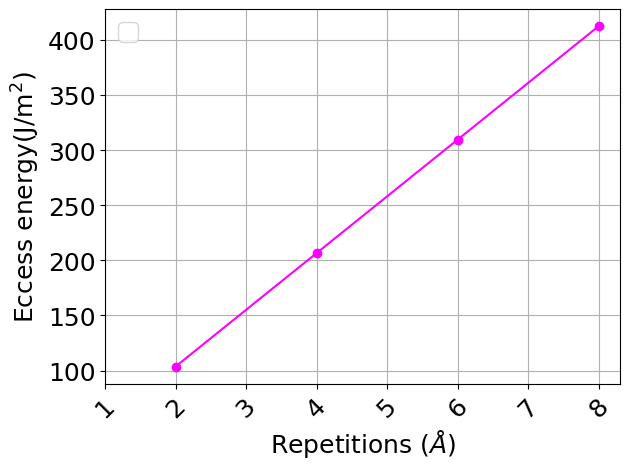


Timestamp:
28-03-2025 16:41


In [11]:
#28_03_2025

#plot formation energy (in this case 003 exess) over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt1.png", bbox_inches='tight') #<----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
#28_03_2025

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~12 min + extra time to write output

#base_path = Path('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/Scripts_outdated/LAMMPS_Scripts/ASE_base_relaxieren')
LAMMPS_Directory = "LAMMPS_Submision_003_17-03-2025_21-11-46" #zu auslesen anpassen
base_path = Path(f"/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/{LAMMPS_Directory}")
print(base_path)

formation_Energy = []
rep = 2

#for f in base_path.glob("*.data/T_50/optimize1.data"):
for f in base_path.glob("*_Submited_mini_data_folders/*.data/T_0*/optimize1.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    atoms1.set_calculator(pot)
    a, b = atoms1.cell[0], atoms1.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    print("Atoms in Supercell: n =",len(atoms1))
    print("GB Area: A =",A, "Å²")
    e_pot_uncorrected = atoms1.get_potential_energy()
    e_pot = Corrected_Energy(e_pot_uncorrected,atoms1)
    print("Supercell potential Energy:")
    print(e_pot,"eV")
    """
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
    """
    formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218)
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218,"J/m²") #mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
    print(f"{rep}reps_done\n")
    rep = rep +2

print("\nGB Formation Energies of variing repetitions:")
print(formation_Energy)


#plot formation energy (in this case 003 exess) over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt1.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [1]:




#UP TO DATE





In [ ]:
#Up to DATE 31_03_2025

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~12 min + extra time to finish on the gpu node

#base_path = Path('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/Scripts_outdated/LAMMPS_Scripts/ASE_base_relaxieren')
LAMMPS_Directory = "LAMMPS_Submision_003_17-03-2025_21-11-46" #zu auslesen anpassen
base_path = Path(f"/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/{LAMMPS_Directory}")
print(base_path)

formation_Energy = []
rep = 2

#for f in base_path.glob("*.data/T_50/optimize1.data"):
for f in base_path.glob("*_Submited_mini_data_folders/*.data/T_0*/optimize1.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    atoms1.set_calculator(pot)
    a, b = atoms1.cell[0], atoms1.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    print("Atoms in Supercell: n =",len(atoms1))
    print("GB Area: A =",A, "Å²")
    e_pot_uncorrected = atoms1.get_potential_energy()
    e_pot = Corrected_Energy(e_pot_uncorrected,atoms1)
    print("Supercell potential Energy:")
    print(e_pot,"eV")
    """
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
    """
    formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218)
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218,"J/m²") #mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
    print(f"{rep}reps_done\n")
    rep = rep +2

print("\nGB Formation Energies of variing repetitions:")
print(formation_Energy)


#plot formation energy (in this case 003 exess) over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt1.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:


#custom input version



Enter the LAMMPS index (e.g., 001, 002, ... etc.):  008


Folder name for 008 is: LAMMPS_Submision_008_24-03-2025_18-01-24
Atoms in Supercell: n = 1144
GB Area: A = 157.1053133579634 Å²


/tmp/ipykernel_41590/3959231854.py:54: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490717 eV
GB Formation Energy:
103.2800965969246 J/m²
2reps_done

Atoms in Supercell: n = 2296
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-8938.419505712107 eV
GB Formation Energy:
206.35076697108212 J/m²
4reps_done

Atoms in Supercell: n = 3448
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-13432.305230938493 eV
GB Formation Energy:
309.4214373449847 J/m²
6reps_done

Atoms in Supercell: n = 4600
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-17926.190956164843 eV
GB Formation Energy:
412.4921077188894 J/m²
8reps_done



/tmp/ipykernel_41590/3959231854.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


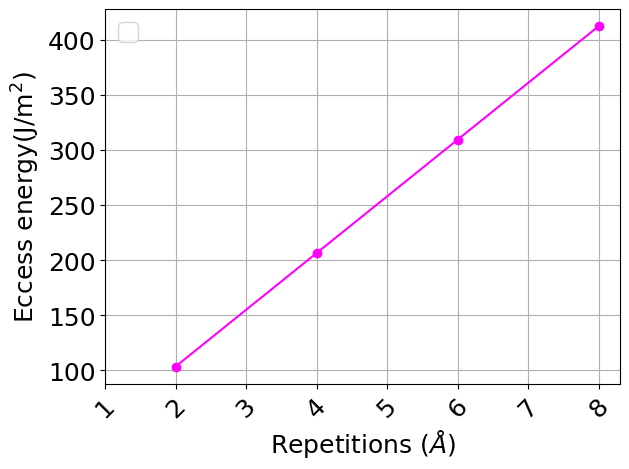


Timestamp:
31-03-2025 17:11


In [18]:
#custom input version

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~12 min + extra time to finish on the gpu node

# Ask the user for the LAMMPS index
LAMMPS_index = []
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
target_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/tests/OVITO_testing"

# List all directories in the base directory
base_path = Path(base_dir)

# Find the folder name matching the pattern for LAMMPS_Submision
folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
    
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

formation_Energy = []
rep = 2
repeat = []

# Loop through the files matching the pattern
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue  # Skip this file and go to the next one
    else:
        # If the folder does not contain "BULK", process the file
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        print("GB Area: A =", A, "Å²")
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        """
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
        """
        formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
        print(f"{rep}reps_done\n")
        repeat.append(rep)
        rep = rep + 2

#plot formation energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt1.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  008


Folder name for 008 is: LAMMPS_Submision_008_24-03-2025_18-01-24
Atoms in Supercell: n = 1144
GB Area: A = 157.1053133579634 Å²


/tmp/ipykernel_41590/1808914027.py:58: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490717 eV
GB Formation Energy:
103.2800965969246 J/m²
2reps_done

Atoms in Supercell: n = 2296
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-8938.419505712107 eV
GB Formation Energy:
206.35076697108212 J/m²
4reps_done

Atoms in Supercell: n = 3448
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-13432.305230938493 eV
GB Formation Energy:
309.4214373449847 J/m²
6reps_done

Atoms in Supercell: n = 4600
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-17926.190956164843 eV
GB Formation Energy:
412.4921077188894 J/m²
8reps_done

[2, 4, 6, 8]


/tmp/ipykernel_41590/1808914027.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


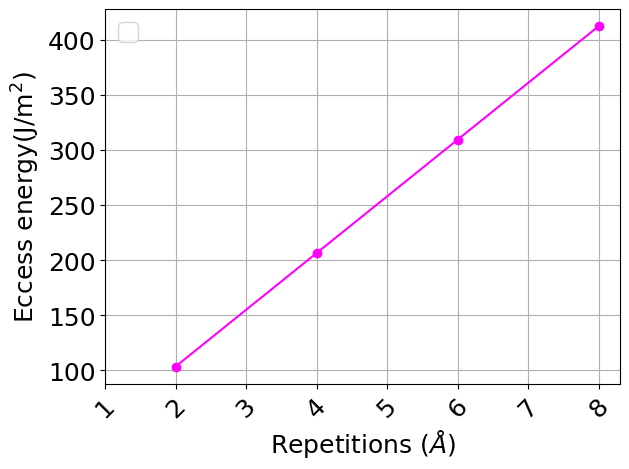


Timestamp:
31-03-2025 17:31


In [24]:
#Up to DATE 31_03_2025 custom input version

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~12 min + extra time to finish on the gpu node

# Ask the user for the LAMMPS index
LAMMPS_index = []
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
formation_Energy = []
repeat = []

# List all directories in the base directory
base_path = Path(base_dir)

# Find the folder name matching the pattern for LAMMPS_Submision
folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Loop through the files matching the pattern
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue  # Skip this file and go to the next one
    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        print("GB Area: A =", A, "Å²")
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        """
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
        """
        formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
        print(f"{rep}reps_done\n")
        repeat.append(rep)
        #print(repeat)

#plot formation energy over repetitions of the supercell
print(repeat)

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt1.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:




#opt 2 read





In [12]:
#28_03_2025

#Read output optimize2 out of _Xrep... mini.data folders
#note LAMMPS 8 rep takes ~42 min + extra time to write output

#base_path = Path('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/Scripts_outdated/LAMMPS_Scripts/ASE_base_relaxieren')
LAMMPS_Directory = "LAMMPS_Submision_004_18-03-2025_15-35-19" #zu auslesen anpassen
base_path = Path(f"/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/{LAMMPS_Directory}")

formation_Energy = []
rep = 2

for f in base_path.glob("*Submited_mini_data_folders/*.data/T_1000/optimize2.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    atoms1.set_calculator(pot)
    a, b = atoms1.cell[0], atoms1.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    print("Atoms in Supercell: n =",len(atoms1))
    print("GB Area: A =",A, "Å²")
    e_pot_uncorrected = atoms1.get_potential_energy()
    e_pot = Corrected_Energy(e_pot_uncorrected,atoms1)
    print("Supercell potential Energy:")
    print(e_pot,"eV")
    """
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
    """
    formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218)
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218,"J/m²") #mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
    print(f"{rep}reps_done\n")
    rep = rep +2

print("\nGB Formation Energies of variing repetitions:")
print(formation_Energy)

"ANSWER NEEDED"
# <*16.0218> eV/Å² --> J/m² conversion Term () Unit_Conversion_Term = 16.0218 aus eV/Å² * (1,60218*(10⁻¹⁹))/(10⁻²⁰) = J/m²
#print("NOTE: GB Formation Energies should be around the order of 0.00X (?) eV/Å² , if the <*16.0218> eV/Å² --> J/m² conversion Term is not applied")
print("NOTE: GB Formation Energies should be around the order of 0.XX (?) J/m² , if the <*16.0218> eV/Å² --> J/m² conversion Term is applied")
"def GB_Form_Energy: https://www.sciencedirect.com/science/article/pii/S1359645423004056 sector 2.1"
"CHECK STATEMENT sector 3.1: We find a GB energy of 0.65 J/m², which is slightly higher than in the case of CIS (0.42 J/m²). "

print('\nDONE')

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%m-%d-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


/tmp/ipykernel_6075/1624164194.py:15: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Atoms in Supercell: n = 1152
GB Area: A = 160.96887505149343 Å²
Supercell potential Energy:
-4473.0535356107575 eV
GB Formation Energy:
101.63352728697225 J/m²
2reps_done

Atoms in Supercell: n = 2304
GB Area: A = 161.70859390375307 Å²
Supercell potential Energy:
-8963.803071207683 eV
GB Formation Energy:
201.4605868312672 J/m²
4reps_done

Atoms in Supercell: n = 3456
GB Area: A = 161.0745586073568 Å²
Supercell potential Energy:
-13453.582610880756 eV
GB Formation Energy:
302.9885840099178 J/m²
6reps_done

Atoms in Supercell: n = 4608
GB Area: A = 160.86496812290795 Å²
Supercell potential Energy:
-17945.778291560866 eV
GB Formation Energy:
404.1292640406205 J/m²
8reps_done


GB Formation Energies of variing repetitions:
[101.63352728697225, 201.4605868312672, 302.9885840099178, 404.1292640406205]
NOTE: GB Formation Energies should be around the order of 0.XX (?) J/m² , if the <*16.0218> eV/Å² --> J/m² conversion Term is applied

DONE

Timestamp:
03-28-2025 16:41


/tmp/ipykernel_6075/3390969079.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


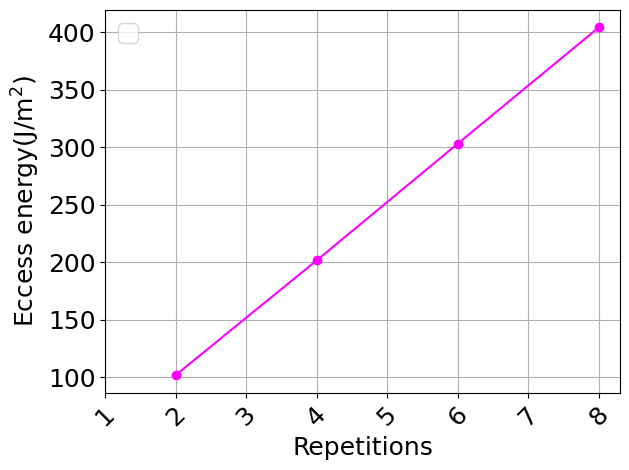


Timestamp:
28-03-2025 16:41


In [13]:
#28_03_2025

#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt2.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

/tmp/ipykernel_6075/2179941324.py:15: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Atoms in Supercell: n = 1152
GB Area: A = 160.96887505149343 Å²
Supercell potential Energy:
-4473.0535356107575 eV
GB Formation Energy:
101.63352728697225 J/m²
2reps_done

Atoms in Supercell: n = 2304
GB Area: A = 161.70859390375307 Å²
Supercell potential Energy:
-8963.803071207683 eV
GB Formation Energy:
201.4605868312672 J/m²
4reps_done

Atoms in Supercell: n = 3456
GB Area: A = 161.0745586073568 Å²
Supercell potential Energy:
-13453.582610880756 eV
GB Formation Energy:
302.9885840099178 J/m²
6reps_done

Atoms in Supercell: n = 4608
GB Area: A = 160.86496812290795 Å²
Supercell potential Energy:
-17945.778291560866 eV
GB Formation Energy:
404.1292640406205 J/m²
8reps_done


GB Formation Energies of variing repetitions:
[101.63352728697225, 201.4605868312672, 302.9885840099178, 404.1292640406205]


/tmp/ipykernel_6075/2179941324.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


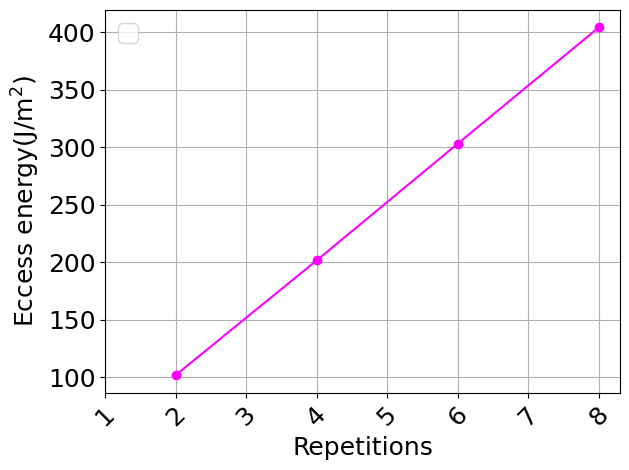


Timestamp:
28-03-2025 16:41


In [14]:
#28_03_2025

#Read output optimize2 out of _Xrep... mini.data folders
#note LAMMPS 8 rep takes ~42 min + extra time to write output

#base_path = Path('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/Scripts_outdated/LAMMPS_Scripts/ASE_base_relaxieren')
LAMMPS_Directory = "LAMMPS_Submision_004_18-03-2025_15-35-19" #zu auslesen anpassen
base_path = Path(f"/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/{LAMMPS_Directory}")

formation_Energy = []
rep = 2

for f in base_path.glob("*Submited_mini_data_folders/*.data/T_1000/optimize2.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    atoms1.set_calculator(pot)
    a, b = atoms1.cell[0], atoms1.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    print("Atoms in Supercell: n =",len(atoms1))
    print("GB Area: A =",A, "Å²")
    e_pot_uncorrected = atoms1.get_potential_energy()
    e_pot = Corrected_Energy(e_pot_uncorrected,atoms1)
    print("Supercell potential Energy:")
    print(e_pot,"eV")
    """
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
    """
    formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218)
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218,"J/m²") #mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
    print(f"{rep}reps_done\n")
    rep = rep +2

print("\nGB Formation Energies of variing repetitions:")
print(formation_Energy)

#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt2.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
#31_03_2025

#Read output optimize2 out of _Xrep... mini.data folders
#note LAMMPS 8 rep takes ~42 min + extra time to write output

#base_path = Path('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/Scripts_outdated/LAMMPS_Scripts/ASE_base_relaxieren')
LAMMPS_Directory = "LAMMPS_Submision_004_18-03-2025_15-35-19" #zu auslesen anpassen
base_path = Path(f"/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/{LAMMPS_Directory}")

formation_Energy = []
rep = 2

for f in base_path.glob("*Submited_mini_data_folders/*.data/T_1000/optimize2.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    atoms1.set_calculator(pot)
    a, b = atoms1.cell[0], atoms1.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    print("Atoms in Supercell: n =",len(atoms1))
    print("GB Area: A =",A, "Å²")
    e_pot_uncorrected = atoms1.get_potential_energy()
    e_pot = Corrected_Energy(e_pot_uncorrected,atoms1)
    print("Supercell potential Energy:")
    print(e_pot,"eV")
    """
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
    """
    formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218)
    print("GB Formation Energy:")
    print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0)*16.0218,"J/m²") #mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
    print(f"{rep}reps_done\n")
    rep = rep +2

print("\nGB Formation Energies of variing repetitions:")
print(formation_Energy)

#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt2.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:




#UP TO DATE





Enter the LAMMPS index (e.g., 001, 002, ... etc.):  008


Folder name for 008 is: LAMMPS_Submision_008_24-03-2025_18-01-24
Atoms in Supercell: n = 1144
GB Area: A = 161.3360963754785 Å²


/tmp/ipykernel_41590/489866280.py:57: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4439.778055474788 eV
GB Formation Energy:
100.80787835091462 J/m²
2reps_done

Atoms in Supercell: n = 2296
GB Area: A = 161.2549304360852 Å²
Supercell potential Energy:
-8929.089270569142 eV
GB Formation Energy:
201.50419834904716 J/m²
4reps_done

Atoms in Supercell: n = 3448
GB Area: A = 161.27605806169052 Å²
Supercell potential Energy:
-13417.764672803902 eV
GB Formation Energy:
302.1417773757614 J/m²
6reps_done

[2, 4, 6]


/tmp/ipykernel_41590/489866280.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


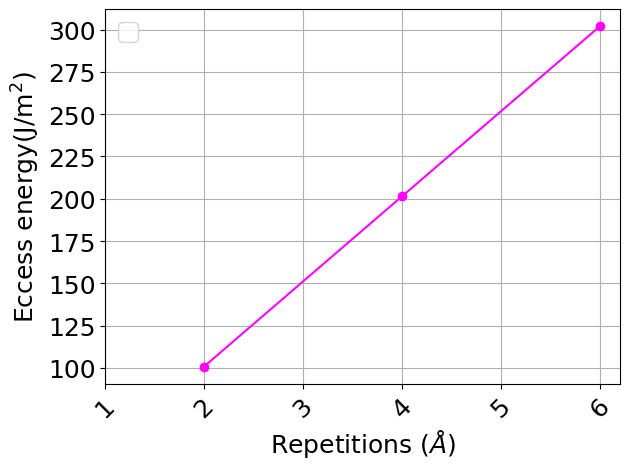


Timestamp:
31-03-2025 17:39


In [25]:
#Up to DATE 31_03_2025 custom input version

#Read output optimize2 out of _Xrep... mini.data folders
#note LAMMPS 8 rep takes ~42 min + extra time to write output

# Ask the user for the LAMMPS index
LAMMPS_index = []
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
formation_Energy = []
repeat = []

# List all directories in the base directory
base_path = Path(base_dir)

# Find the folder name matching the pattern for LAMMPS_Submision
folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Loop through the files matching the pattern
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize2.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue  # Skip this file and go to the next one
    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        print("GB Area: A =", A, "Å²")
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        """
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0),"eV/Å²")
        """
        formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
        print(f"{rep}reps_done\n")
        repeat.append(rep)
        #print(repeat)

#plot formation energy over repetitions of the supercell
print(repeat)

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt2.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:


#project reference LAMMPS bulk for opt1



Folder name for 008 is: LAMMPS_Submision_008_24-03-2025_18-01-24
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-2rep_10A_VACUUMS.data
Atoms in Supercell: n = 1144
GB Area: A = 157.1053133579634 Å²


/tmp/ipykernel_41590/4245938163.py:65: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Bulk potential Energy:
-4450.283415140807 eV
The bulk Energy (per atom) is: -3.890107880367838 in eV per atom
2reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-4rep_10A_VACUUMS.data
Atoms in Supercell: n = 2296
GB Area: A = 157.1053133579634 Å²
Bulk potential Energy:
-8944.169140367174 eV
The bulk Energy (per atom) is: -3.895544050682567 in eV per atom
4reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-6rep_10A_VACUUMS.data
Atoms in Supercell: n = 3448
GB Area: A = 157.1053133579634 Å²
Bulk potential Energy:
-13438.054865593613 eV
The bulk Energy (per atom) is: -3.897347698838055 in eV per atom
6reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/dat

/tmp/ipykernel_41590/4245938163.py:100: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490717 eV
The Energy (per atom) is: -3.885081975953424 in eV per atom
2reps_done

Atoms in Supercell: n = 2296
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-8938.419505712107 eV
The Energy (per atom) is: -3.8930398544042277 in eV per atom
4reps_done

Atoms in Supercell: n = 3448
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-13432.305230938493 eV
The Energy (per atom) is: -3.895680171385874 in eV per atom
6reps_done

Atoms in Supercell: n = 4600
GB Area: A = 157.1053133579634 Å²
Supercell potential Energy:
-17926.190956164843 eV
The Energy (per atom) is: -3.896998033948879 in eV per atom
8reps_done

[2, 4, 6, 8]

For the Total Energy of the GB:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Total Energy per atom is: [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948879] (in eV per atom)
The Total Energy is (red): [-4444.533780490717, -893

/tmp/ipykernel_41590/4245938163.py:161: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


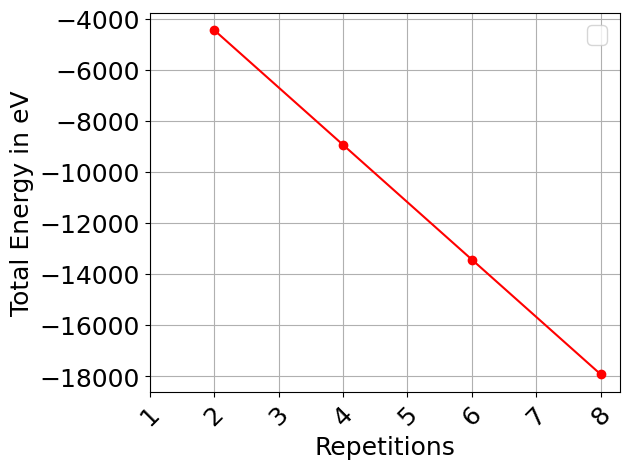


The Area of the GB is: 157.30529027915497 (in Å²)
The Area of the GB is: 157.1053133579634 (in Å²)

The Total Energies are (red): [-4444.533780490717, -8938.419505712107, -13432.305230938493, -17926.190956164843] (in eV)
The Bulk energies E_b are (orange): [-4450.283415140807, -8944.169140367174, -13438.054865593613, -17931.940590819926] (in eV)


/tmp/ipykernel_41590/4245938163.py:209: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


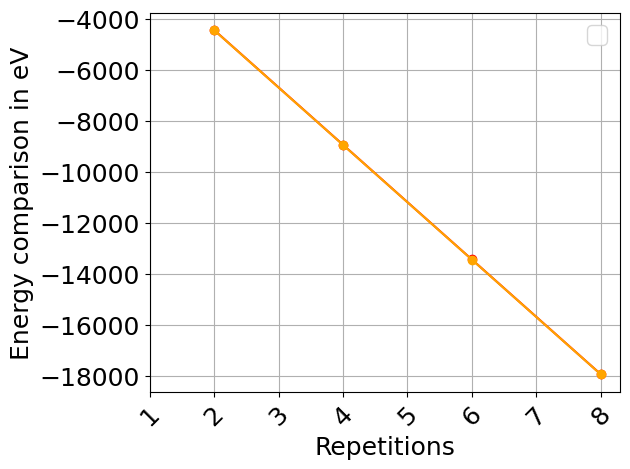


Testing:
The Total energies per atom are: [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948879]
The Bulk energies per Atom are: [-3.890107880367838, -3.895544050682567, -3.897347698838055, -3.898247954526071] (in eV per Atom)
The Energy difference per Atom is: [0.005025904414414306, 0.002504196278339421, 0.0016675274521809058, 0.0012499205771923094] (in eV per Atom)
The Energy difference is: [5.749634650089966, 5.749634655067311, 5.749634655119763, 5.749634655084623] (in eV)
The Energy difference per Area of the GB is: [0.03659732778731335, 0.03659732781899493, 0.036597327819328805, 0.03659732781910513] (in eV/Å²)
The Energy difference per Area of the GB is: [0.586355066342777, 0.586355066850373, 0.5863550668557223, 0.5863550668521386] (in J/m²)
The Energy difference is: [5.749634650089966, 5.749634655067311, 5.749634655119763, 5.749634655084623] (in eV)


/tmp/ipykernel_41590/4245938163.py:263: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


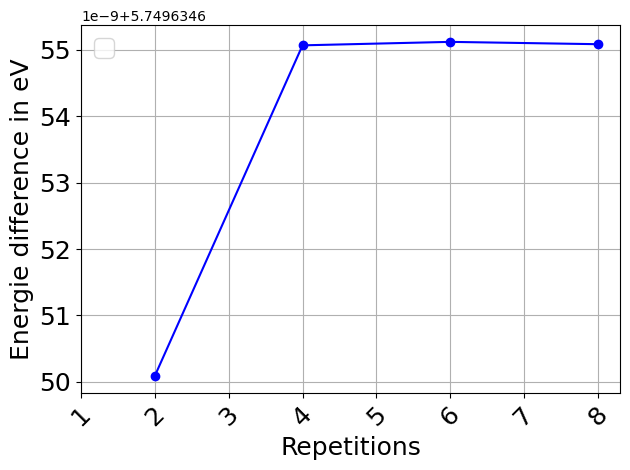



The Total energies per atom are (red): [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948879]
The Bulk energies per Atom are (orange): [-3.890107880367838, -3.895544050682567, -3.897347698838055, -3.898247954526071] (in eV per Atom)


/tmp/ipykernel_41590/4245938163.py:286: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


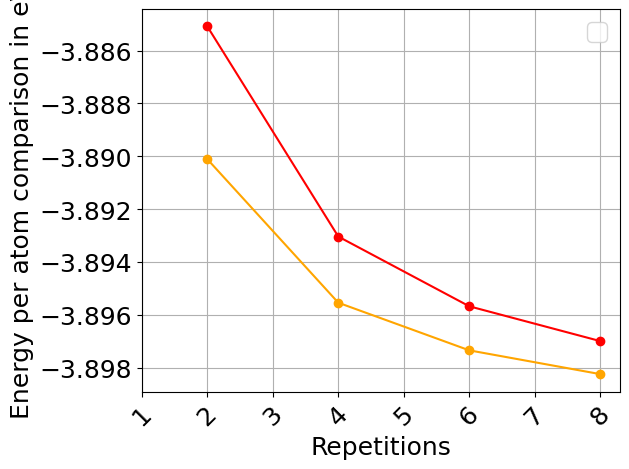

The Energy difference per Atom is: [0.005025904414414306, 0.002504196278339421, 0.0016675274521809058, 0.0012499205771923094] (in eV)


/tmp/ipykernel_41590/4245938163.py:306: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


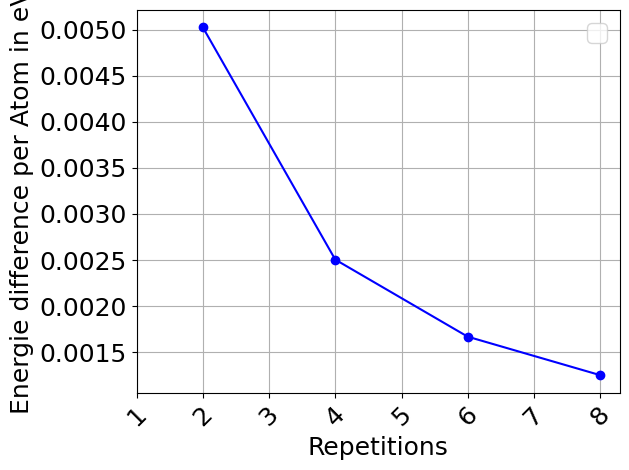



The formation energies are: [0.5863550663428039, 0.5863550668503397, 0.5863550668557194, 0.5863550668520092]


/tmp/ipykernel_41590/4245938163.py:331: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


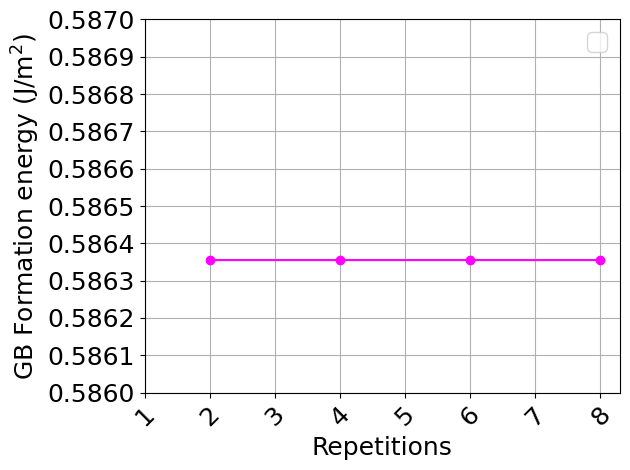

/tmp/ipykernel_41590/4245938163.py:351: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


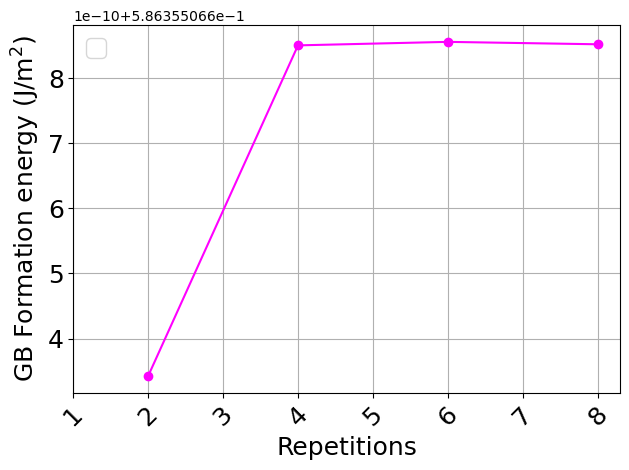


Timestamp:
31-03-2025 19:12


In [56]:
#31_03_2025 custom input version

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy with the E_B reference LAMMPS bulk

#needs cleanup! + short ver.

# Ask the user for the LAMMPS index
LAMMPS_index = '008'
#LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
formation_Energy = []
repeat = []
bulk_repeat = []
n_reps = []
rep = []
Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_bulk = []

# List all directories in the base directory
base_path = Path(base_dir)

# Find the folder name matching the pattern for LAMMPS_Submision
folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Loop through the files matching the pattern
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        print(Path(grandparent_folder))
        # If the folder does contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            bulk_rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(bulk_rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        #n_bulk_reps.append(len(atoms1))
        print("GB Area: A =", A, "Å²")
        e_bulk_uncorrected = atoms1.get_potential_energy()
        e_bulk = Corrected_Energy(e_bulk_uncorrected, atoms1)
        print("Bulk potential Energy:")
        print(e_bulk, "eV")
        #formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        #print("GB Formation Energy:")
        #print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²
        
        Bulk_Energy.append(e_bulk)
        #divide by atom count (needed?)
        Undivided_Energy = e_bulk
        Divided_Energy = Undivided_Energy/len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        print(f"The bulk Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{bulk_rep}reps_done\n")
        bulk_repeat.append(bulk_rep)        

    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        n_reps.append(len(atoms1))
        print("GB Area: A =", A, "Å²")
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        #formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        #print("GB Formation Energy:")
        #print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²

        Total_Energy.append(e_pot)
        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{rep}reps_done\n")
        repeat.append(rep)
        
#plot formation energy over repetitions of the supercell
print(repeat)
"""
plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/uncorrected_Eccess_energy_opt1.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()
"""

# Step 9: print values for the Total Energy of the GB

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

#plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 10: calculate formation energy for each repetition

xAg = 0
A = 157.30529027915497
print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms1.cell[0], atoms1.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")
#kB = 1.380649*(10^(-23)) #in (m^2 kg s^-2 K^-1 or J K^-1)
#Mit Elektronenvolt (eV) als Energieeinheit hat die Boltzmann-Konstante den – ebenfalls exakten – Wert 8.617333262*(10^(-5)) (eV/K)
#kB = 8.617333262*(10**(-5))
#print(f"\nkB is: {kB}")
#note that Test = 10^(-5) #--> =-15!!! --> use Test = 10**(-5)
#temp_scaling_term = (kB*Temp)       #kB*T characteristic energy kBT associated with a single microscopic degree of freedom, (1DoF)
#                                    #where T denotes temperature and kB denotes the Boltzmann constant.


formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    formation_Energy.append(eform)                                                   

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

#plot comparison Total energy and Bulk energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()




#Testing:
#KEIN fehler in der Formel !!!
Bulk_Energy_per_Atom = []
Ediff = []
Ediff_per_area = []
Ediff_per_Atom = []
Ediff_per_area_inJ = []
for i in range(4):
    Bulk_Energy_per_Atom.append(Bulk_Energy[i]/n_reps[i])
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_Atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_Atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_Atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

#plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom}")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_Atom} (in eV per Atom)")

#plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_Atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_Atom} (in eV)")

#plot Ediff per atom over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_Atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()



print("\n")
print(f"The formation energies are: {formation_Energy}")


# Step 10: plot formation energy over repetitions of the supercell


plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
plt.yticks(np.arange(0.586, 0.587, 0.0001))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()



plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
#plt.yticks(np.arange(0.5, 1.05, 0.05))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  008


Folder name for 008 is: LAMMPS_Submision_008_24-03-2025_18-01-24
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-2rep_10A_VACUUMS.data


/tmp/ipykernel_4720/3336488865.py:78: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Bulk potential Energy:
-4450.283415140807 eV
The bulk Energy (per atom) is: -3.890107880367838 in eV per atom
2reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-4rep_10A_VACUUMS.data
Bulk potential Energy:
-8944.169140367174 eV
The bulk Energy (per atom) is: -3.895544050682567 in eV per atom
4reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-6rep_10A_VACUUMS.data
Bulk potential Energy:
-13438.054865593613 eV
The bulk Energy (per atom) is: -3.897347698838055 in eV per atom
6reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-8rep_10A_VACUUMS

/tmp/ipykernel_4720/3336488865.py:112: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490717 eV
The Energy (per atom) is: -3.885081975953424 in eV per atom
2reps_done

Supercell potential Energy:
-8938.419505712107 eV
The Energy (per atom) is: -3.8930398544042277 in eV per atom
4reps_done

Supercell potential Energy:
-13432.305230938493 eV
The Energy (per atom) is: -3.895680171385874 in eV per atom
6reps_done

Supercell potential Energy:
-17926.190956164843 eV
The Energy (per atom) is: -3.896998033948879 in eV per atom
8reps_done

The Area of the GB is: 157.1053133579634 (in Å²)

For the Total Energy of the GB:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Total Energy per atom is: [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948879] (in eV per atom)
The Total Energy is (red): [-4444.533780490717, -8938.419505712107, -13432.305230938493, -17926.190956164843] (in eV)


/tmp/ipykernel_4720/3336488865.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


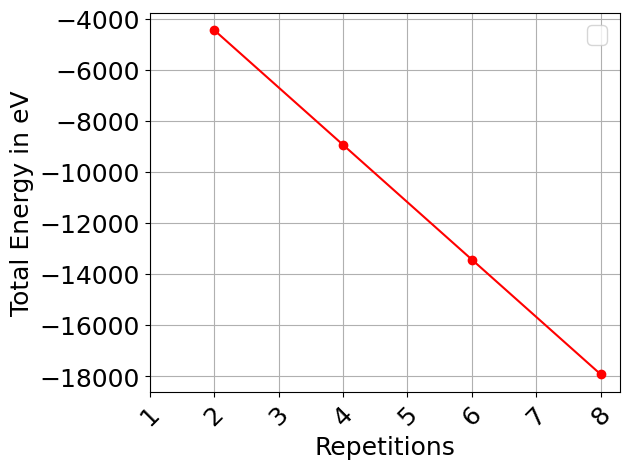


The Total Energies are (red): [-4444.533780490717, -8938.419505712107, -13432.305230938493, -17926.190956164843] (in eV)
The Bulk energies E_b are (orange): [-4450.283415140807, -8944.169140367174, -13438.054865593613, -17931.940590819926] (in eV)


/tmp/ipykernel_4720/3336488865.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


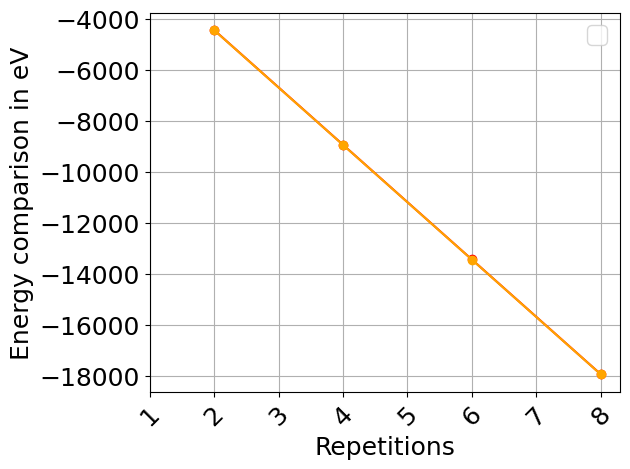


Testing:
The Total energies per atom are: [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948879]
The Bulk energies per Atom are: [-3.890107880367838, -3.895544050682567, -3.897347698838055, -3.898247954526071] (in eV per Atom)
The Energy difference per Atom is: [0.005025904414414306, 0.002504196278339421, 0.0016675274521809058, 0.0012499205771923094] (in eV per Atom)
The Energy difference is: [5.749634650089966, 5.749634655067311, 5.749634655119763, 5.749634655084623] (in eV)
The Energy difference per Area of the GB is: [0.03659732778731335, 0.03659732781899493, 0.036597327819328805, 0.03659732781910513] (in eV/Å²)
The Energy difference per Area of the GB is: [0.586355066342777, 0.586355066850373, 0.5863550668557223, 0.5863550668521386] (in J/m²)
The Energy difference is: [5.749634650089966, 5.749634655067311, 5.749634655119763, 5.749634655084623] (in eV)


/tmp/ipykernel_4720/3336488865.py:233: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


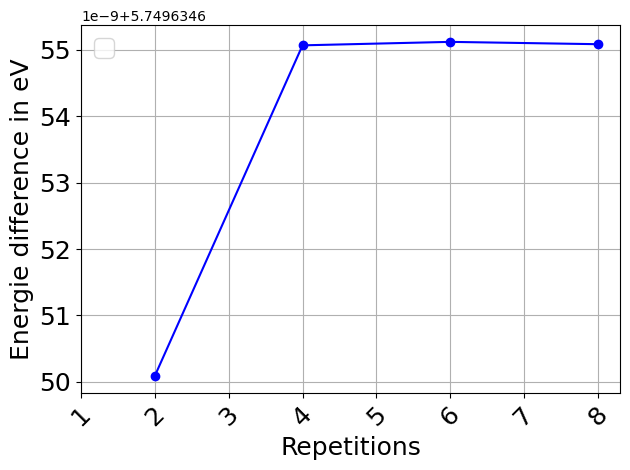



The Total energies per atom are (red): [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948879]
The Bulk energies per Atom are (orange): [-3.890107880367838, -3.895544050682567, -3.897347698838055, -3.898247954526071] (in eV per Atom)


/tmp/ipykernel_4720/3336488865.py:256: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


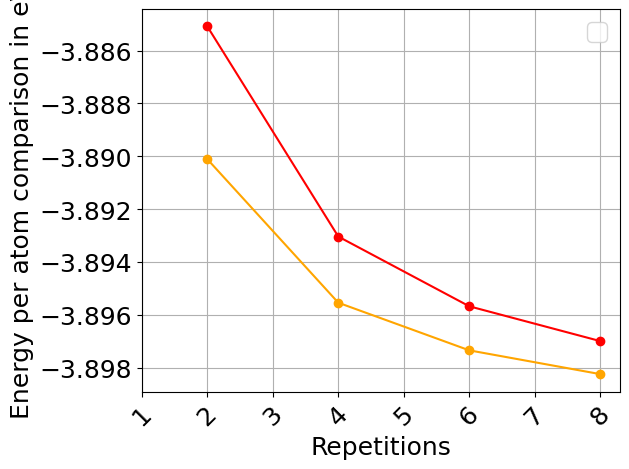

The Energy difference per Atom is: [0.005025904414414306, 0.002504196278339421, 0.0016675274521809058, 0.0012499205771923094] (in eV)


/tmp/ipykernel_4720/3336488865.py:277: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


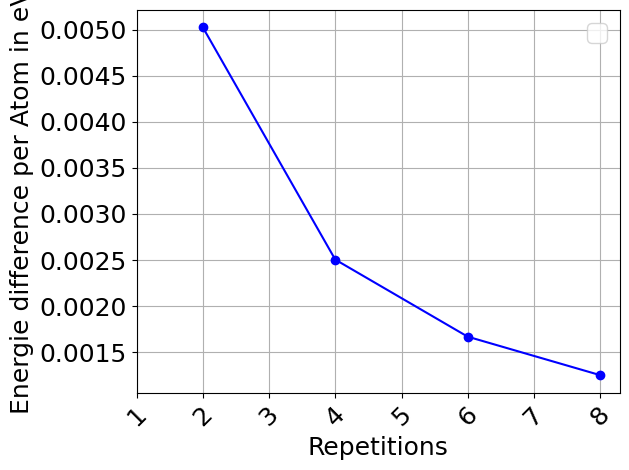



The formation energies are: [0.5863550663428039, 0.5863550668503397, 0.5863550668557194, 0.5863550668520092]


/tmp/ipykernel_4720/3336488865.py:299: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


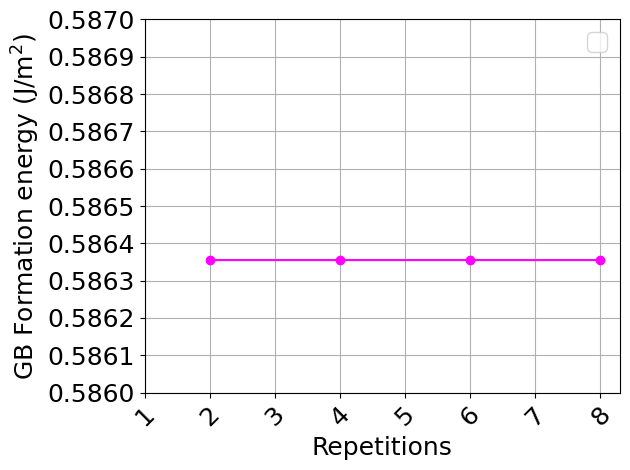

/tmp/ipykernel_4720/3336488865.py:318: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


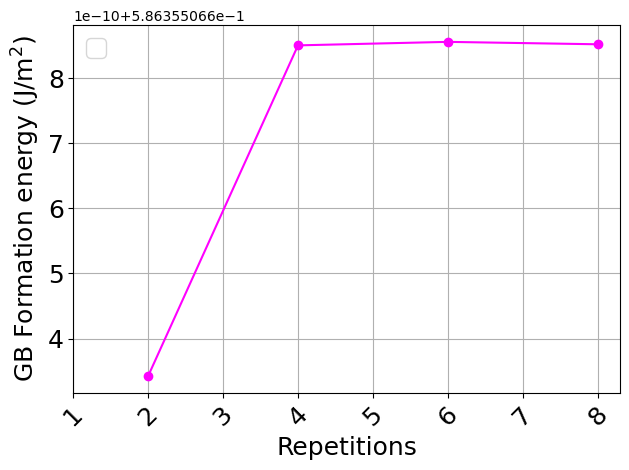


Timestamp:
01-04-2025 16:14


In [13]:
#Up to DATE 01_04_2025 custom input version

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy with the E_B reference LAMMPS bulk

#needs short ver.

# Ask the user for the LAMMPS index
#LAMMPS_index = '008'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# List all directories in the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        print(Path(grandparent_folder))
        # If the folder does contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            bulk_rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(bulk_rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        """
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        print("GB Area: A =", A, "Å²")
        """
        #n_bulk_reps.append(len(atoms1))
        e_bulk_uncorrected = atoms1.get_potential_energy()
        e_bulk = Corrected_Energy(e_bulk_uncorrected, atoms1)
        print("Bulk potential Energy:")
        print(e_bulk, "eV")
        
        Bulk_Energy.append(e_bulk)
        #divide by atom count (needed?)
        Undivided_Energy = e_bulk
        Divided_Energy = Undivided_Energy/len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        print(f"The bulk Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{bulk_rep}reps_done\n")
        bulk_repeat.append(bulk_rep)        

    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        """
        a, b = atoms1.cell[0], atoms1.cell[1]
        A = np.linalg.norm(np.cross(a, b))
        print("Atoms in Supercell: n =", len(atoms1))
        print("GB Area: A =", A, "Å²")
        """
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")

        Total_Energy.append(e_pot)
        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{rep}reps_done\n")
        repeat.append(rep)

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms1.cell[0], atoms1.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

#for i in range(4):
    #Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Step 11: plot formation energy over repetitions of the supercell: 2 variants for scale:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
plt.yticks(np.arange(0.586, 0.587, 0.0001))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
#plt.yticks(np.arange(0.5, 1.05, 0.05))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  008


Folder name for 008 is: LAMMPS_Submision_008_24-03-2025_18-01-24
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-2rep_10A_VACUUMS.data


/tmp/ipykernel_4720/1580474151.py:73: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Bulk potential Energy:
-4450.283415140807 eV
The bulk Energy (per atom) is: -3.890107880367838 in eV per atom
2reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-4rep_10A_VACUUMS.data
Bulk potential Energy:
-8944.169140367174 eV
The bulk Energy (per atom) is: -3.895544050682567 in eV per atom
4reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-6rep_10A_VACUUMS.data
Bulk potential Energy:
-13438.054865593613 eV
The bulk Energy (per atom) is: -3.897347698838055 in eV per atom
6reps_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-8rep_10A_VACUUMS

/tmp/ipykernel_4720/1580474151.py:101: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490717 eV
The Energy (per atom) is: -3.885081975953424 in eV per atom
2reps_done

Supercell potential Energy:
-8938.419505712107 eV
The Energy (per atom) is: -3.8930398544042277 in eV per atom
4reps_done

Supercell potential Energy:
-13432.305230938493 eV
The Energy (per atom) is: -3.895680171385874 in eV per atom
6reps_done

Supercell potential Energy:
-17926.190956164843 eV
The Energy (per atom) is: -3.896998033948879 in eV per atom
8reps_done


The Total Energies are (red): [-4444.533780490717, -8938.419505712107, -13432.305230938493, -17926.190956164843] (in eV)
The Bulk energies E_b are (orange): [-4450.283415140807, -8944.169140367174, -13438.054865593613, -17931.940590819926] (in eV)
The Total energies per atom are (red): [-3.885081975953424, -3.8930398544042277, -3.895680171385874, -3.896998033948879]
The Bulk energies per Atom are (orange): [-3.890107880367838, -3.895544050682567, -3.897347698838055, -3.898247954526071] (in eV per Atom)


/tmp/ipykernel_4720/1580474151.py:146: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


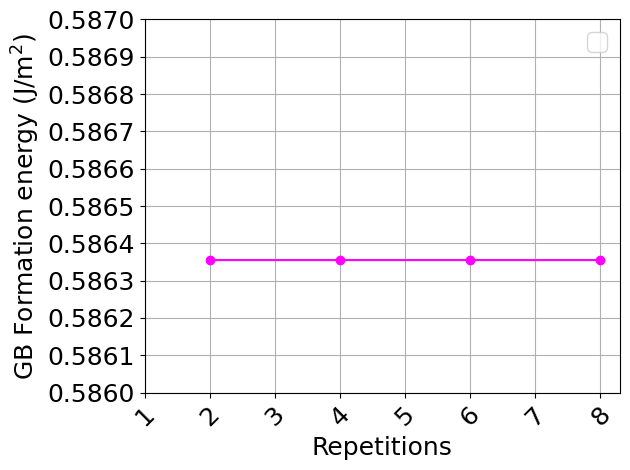

/tmp/ipykernel_4720/1580474151.py:165: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


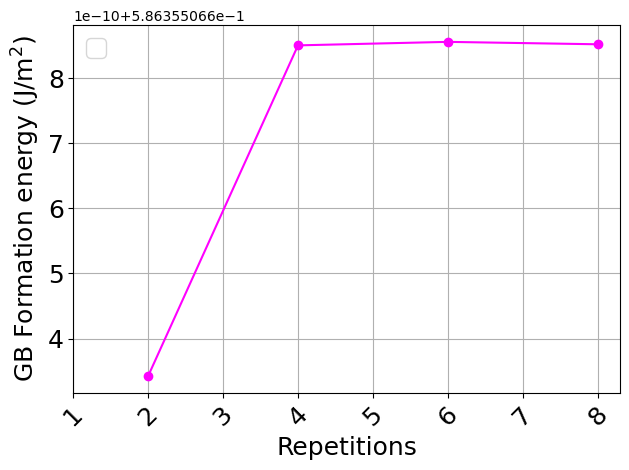


Timestamp:
01-04-2025 16:28


In [18]:
#Up to DATE 01_04_2025 custom input version

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy with the E_B reference LAMMPS bulk

#short ver.

# Ask the user for the LAMMPS index
#LAMMPS_index = '008'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

# List all directories in the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        print(Path(grandparent_folder))
        # If the folder does contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            bulk_rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(bulk_rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        #n_bulk_reps.append(len(atoms1))
        e_bulk_uncorrected = atoms1.get_potential_energy()
        e_bulk = Corrected_Energy(e_bulk_uncorrected, atoms1)
        print("Bulk potential Energy:")
        print(e_bulk, "eV")
        
        Bulk_Energy.append(e_bulk)
        #divide by atom count (needed?)
        Undivided_Energy = e_bulk
        Divided_Energy = Undivided_Energy/len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        print(f"The bulk Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{bulk_rep}reps_done\n")
        bulk_repeat.append(bulk_rep)        

    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")

        Total_Energy.append(e_pot)
        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        print(f"{rep}reps_done\n")
        repeat.append(rep)

print(f"\nThe Total Energies are: {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are: {Bulk_Energy} (in eV)")

print(f"The Total energies per atom are: {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms1.cell[0], atoms1.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: plot formation energy over repetitions of the supercell: 2 variants for scale:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
plt.yticks(np.arange(0.586, 0.587, 0.0001))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
#plt.yticks(np.arange(0.5, 1.05, 0.05))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:










#thermo-data read:










In [9]:
#Outdated Test version: 
#WIP python script with which I can read the third column of a data table from the 2nd row #functional

import csv

"""
# Define the paths for input and output files
txt_file_path = 'thermo_data.txt'  # Path to the .txt file
csv_file_path = 'thermo_data.csv'  # Path to save the .csv file

# Step 1: Convert .txt to .csv
with open(txt_file_path, 'r') as txt_file:
    lines = txt_file.readlines()
    #print(lines)

# Define the path where the empty .csv file should be created
csv_file_path = 'thermo_data.csv'  # You can change this path to your desired location
"""

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file

# Step 1: Convert .txt to .csv
with open(txt_file_path, 'r') as txt_file:
    lines = txt_file.readlines()
    #print(lines)

# Define the path where the empty .csv file should be created
csv_file_path = '/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.csv'  # You can change this path to your desired location


"""
# Create an empty CSV file
with open(csv_file_path, mode='w', newline='') as file:
    csv_writer = csv.writer(file)

print(f"Empty CSV file created at {csv_file_path}")
"""

# Use builtins' open to avoid IPython file handle restrictions
import builtins

# Create an empty CSV file
with builtins.open(csv_file_path, mode='w', newline='') as file:
    csv_writer = csv.writer(file)

print(f"Empty CSV file created at {csv_file_path}")


# Open a new CSV file to write the converted content
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # Iterate through each line of the .txt file
    for line in lines:
        # Assuming space or tab separation, split line by whitespace
        row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
        csv_writer.writerow(row)

"""
# Step 2: Read the third column of the .csv file starting from the second row
with open(csv_file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Skip the header (1st row)
    next(csv_reader)
    
    # Iterate through the rows starting from the 2nd row
    for row in csv_reader:
        if len(row) >= 3:  # Ensure the row has at least 3 columns
            print(row[2])  # Print the 3rd column (index 2)
"""

# Step 2: Read the first column of the .csv file starting from the second row
first_column = []  # Create an empty list to store the first column

with open(csv_file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Skip the header (1st row)
    next(csv_reader)
    
    # Iterate through the rows starting from the 2nd row
    for row in csv_reader:
        if len(row) >= 3:  # Ensure the row has at least 3 columns
            """
            first_column.append(row[0])  # Add the 1st column (index 0) to the list
            """
            try:
                # Convert the 1st column value to an integer and append to the list
                first_column.append(int(row[0]))
            except ValueError:
                # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")

# Output the third column as a list
print(first_column)
list_length = len(first_column)
print(f"The length of the first_column list is: {list_length}")
print("\n")

# Step 3: Read the third column of the .csv file starting from the second row
third_column = []  # Create an empty list to store the third column

with open(csv_file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Skip the header (1st row)
    next(csv_reader)
    
    # Iterate through the rows starting from the 2nd row
    for row in csv_reader:
        if len(row) >= 3:  # Ensure the row has at least 3 columns
            try:
                # Convert the 3rd column value to a float and append to the list
                third_column.append(float(row[2]))
            except ValueError:
                # In case the conversion fails (e.g., if it's not a valid float), skip that value
                print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")

# Output the third column as a list
print(third_column)
list_length = len(third_column)
print(f"The length of the third_column list is: {list_length}")


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.csv
[4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000, 6050, 6100, 6150, 6200, 6250, 6300, 6350, 6400, 6450, 6500, 6550, 6600, 6650, 6700, 6750, 6800, 6850, 6900, 6950, 7000, 7050, 7100, 7150, 7200, 7250, 7300, 7350, 7400, 7450, 7500, 7550, 7600, 7650, 7700, 7750, 7800, 7850, 7900, 7950, 8000, 8050, 8100, 8150, 8200, 8250, 8300, 8350, 8400, 8450, 8500, 8550, 8600, 8650, 8700, 8750, 8800, 8850, 8900, 8950, 9000, 9050, 9100, 9150, 9200, 9250, 9300, 9350, 9400, 9450, 9500, 9550, 9600, 9650, 9700, 9750, 9800, 9850, 9900, 9950, 1000

In [ ]:
# Step 4: plot the Energy over the Timesteps

import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=10)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))

plt.xlabel('Timesteps',fontsize = 18)
plt.yticks(fontsize = 18) 
#plt.ylabel('Formation energy(J/m$^2$)',fontsize = 18)
plt.ylabel("Total energy(eV)",fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
# Step 5: cut out the first X steps to reduce the spread

#print(first_column)
list_length = len(first_column)
print(f"The length of the first_column list is: {list_length}")

# Remove the first 10 entries
first_column_no_startup = first_column[10:]

# Print the updated list length
list_length = len(first_column_no_startup)
print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
print(f"The new length of the first_column list is: {list_length}")
print("\n")


#print(third_column)
list_length = len(third_column)
print(f"The length of the third_column list is: {list_length}")

# Remove the first 10 entries
third_column_no_startup = third_column[10:]

# Print the updated list length
list_length = len(third_column_no_startup)
print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
print(f"The new length of the first_column list is: {list_length}")



In [ ]:
# Step 6: plot the Energy over the Timesteps

import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=10)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))

plt.xlabel('Timesteps',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
# Step 7: Avarage the energy

# Calculate the average
average = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
# Print the result
print(f"The average of the list is: {average}")

In [ ]:
# Step 7: Avarage the energy

# Calculate the average
averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
print(f"The average of the Energy is: {averaged_Energy} in eV")
Undivided_Energy = averaged_Energy 


In [ ]:
# Step 8 divide by atom count (needed?)
atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
print("Atoms in Supercell: n =",len(atoms2))

Divided_Energy = Undivided_Energy/len(atoms2)
print(f"The Energy (per atom?) is: {Divided_Energy} in eV?")



In [ ]:
#DUMMY
#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]
Total_Energy_per_atom = [
-3.4846001490111975,
-3.4944527980546076,
-3.4973955032824360,
-3.4982339865681653
] #(Energy per Atom)

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy per atom in eV',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_energy_per_atom_average_DUMMY.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
# collection of usefull values (automize later)
"""
2rep:
Total Energy?: -4014.2593716608994
Atoms in Supercell: n = 1152
The Energy (per atom?) is: -3.4846001490111975

4rep:
Total Energy?: -8051.2192467178160
Atoms in Supercell: n = 2304
The Energy (per atom?) is: -3.4944527980546076

6rep:
Total Energy?: -12086.9988593441
Atoms in Supercell: n = 3456
The Energy (per atom?) is: -3.497395503282436

8rep:
Total Energy?: -16119.862210106106
Atoms in Supercell: n = 4608
The Energy (per atom?) is: -3.4982339865681653

GB Area: A = 157.30529027915497 Å²
"""

In [ ]:
#calculate formation energy

Total_Energy = [-4014.2593716608994, -8051.2192467178160, -12086.998859344100, -16119.862210106106] #needs to be corrected?
n_reps = [1152, 2304, 3456, 4608]

#eref_Cu = Corrected_Energy(eref_Cu_uncorrected,ref_Cu) #for reference
#eref_Cu = eref_Cu_uncorrected

xAg = 0
A = 157.30529027915497
E_bulk_per_atom = ((1 - xAg) * eref_Cu + xAg * eref_Ag) 

formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = ((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (2 * A))
    formation_Energy.append(eform * 16.0218)  # Conversion factor from eV/Å² to J/m²

print(E_bulk_per_atom)
print(formation_Energy)

In [ ]:
#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
#plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:




#UP TO DATE





In [ ]:
#Test version: 
#python script with which I can read the third column of a data table from the 2nd row #functional

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
base_file_path = f"{core_path}/LAMMPS_Submision_004_18-03-2025_15-35-19/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep.data/T_1000"
txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

# Step 1: Convert .txt to .csv
with open(txt_file_path, 'r') as txt_file:
    lines = txt_file.readlines()
    #print(lines)

# Define the path where the empty .csv file should be created
#csv_file_path = '/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.csv'  # You can change this path to your desired location


"""
# Create an empty CSV file
with open(csv_file_path, mode='w', newline='') as file:
    csv_writer = csv.writer(file)

print(f"Empty CSV file created at {csv_file_path}")
"""

# Use builtins' open to avoid IPython file handle restrictions
import builtins

# Create an empty CSV file
with builtins.open(csv_file_path, mode='w', newline='') as file:
    csv_writer = csv.writer(file)

print(f"Empty CSV file created at {csv_file_path}")


# Open a new CSV file to write the converted content
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # Iterate through each line of the .txt file
    for line in lines:
        # Assuming space or tab separation, split line by whitespace
        row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
        csv_writer.writerow(row)

"""
# Step 2: Read the third column of the .csv file starting from the second row
with open(csv_file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Skip the header (1st row)
    next(csv_reader)
    
    # Iterate through the rows starting from the 2nd row
    for row in csv_reader:
        if len(row) >= 3:  # Ensure the row has at least 3 columns
            print(row[2])  # Print the 3rd column (index 2)
"""

# Step 2: Read the first column of the .csv file starting from the second row
first_column = []  # Create an empty list to store the first column

with open(csv_file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Skip the header (1st row)
    next(csv_reader)
    
    # Iterate through the rows starting from the 2nd row
    for row in csv_reader:
        if len(row) >= 3:  # Ensure the row has at least 3 columns
            """
            first_column.append(row[0])  # Add the 1st column (index 0) to the list
            """
            try:
                # Convert the 1st column value to an integer and append to the list
                first_column.append(int(row[0]))
            except ValueError:
                # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")

# Output the first column as a list (contains stepcount?)
print(first_column)
list_length = len(first_column)
print(f"The length of the first_column list is: {list_length}")
print("\n")

# Step 3: Read the third column of the .csv file starting from the second row
third_column = []  # Create an empty list to store the third column

with open(csv_file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Skip the header (1st row)
    next(csv_reader)
    
    # Iterate through the rows starting from the 2nd row
    for row in csv_reader:
        if len(row) >= 3:  # Ensure the row has at least 3 columns
            try:
                # Convert the 3rd column value to a float and append to the list
                third_column.append(float(row[2]))
            except ValueError:
                # In case the conversion fails (e.g., if it's not a valid float), skip that value
                print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")

# Output the third column as a list (contains Total Energy of the Supercell in eV)
print(third_column)
list_length = len(third_column)
print(f"The length of the third_column list is: {list_length}")


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format


In [ ]:
# Step 4: plot the Energy over the Timesteps

plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="14", loc ="lower right")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=10)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))

plt.xlabel('Timesteps',fontsize = 18)
plt.yticks(fontsize = 18) 
#plt.ylabel('Formation energy(J/m$^2$)',fontsize = 18)
plt.ylabel("Total energy(eV)",fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
# Step 5: cut out the first X steps to reduce the spread

#print(first_column)
list_length = len(first_column)
print(f"The length of the first_column list is: {list_length}")

# Remove the first 10 entries
first_column_no_startup = first_column[10:]

# Print the updated list length
list_length = len(first_column_no_startup)
print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
print(f"The new length of the first_column list is: {list_length}")
print("\n")


#print(third_column)
list_length = len(third_column)
print(f"The length of the third_column list is: {list_length}")

# Remove the first 10 entries
third_column_no_startup = third_column[10:]

# Print the updated list length
list_length = len(third_column_no_startup)
print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
print(f"The new length of the first_column list is: {list_length}")



In [ ]:
# Step 6: plot the Energy over the Timesteps

plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="14", loc ="lower right")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=10)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))

plt.xlabel('Timesteps',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
# Step 7: Avarage the energy

# Calculate the average
averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
print(f"The average of the Energy is: {averaged_Energy} in eV")
Undivided_Energy = averaged_Energy 

In [ ]:
# Step 8 divide by atom count (needed?)
atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
print("Atoms in Supercell: n =",len(atoms2))

Divided_Energy = Undivided_Energy/len(atoms2)
print(f"The Energy (per atom?) is: {Divided_Energy} in eV?")


In [ ]:
#DUMMY
#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]
Total_Energy_per_atom = [
-3.4846001490111975,
-3.4944527980546076,
-3.4973955032824360,
-3.4982339865681653
] #(Energy per Atom)

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy per atom in eV',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_energy_per_atom_average_DUMMY.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
#calculate formation energy

Total_Energy = [-4014.2593716608994, -8051.2192467178160, -12086.998859344100, -16119.862210106106] #needs to be corrected?
n_reps = [1152, 2304, 3456, 4608]

#eref_Cu = Corrected_Energy(eref_Cu_uncorrected,ref_Cu) #for reference
#eref_Cu = eref_Cu_uncorrected

xAg = 0
A = 157.30529027915497
E_bulk_per_atom = ((1 - xAg) * eref_Cu + xAg * eref_Ag) 

formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = ((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (2 * A))
    formation_Energy.append(eform * 16.0218)  # Conversion factor from eV/Å² to J/m²

print(E_bulk_per_atom)
print(formation_Energy)

In [ ]:
#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
#plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
#outdated WIP-all-in-one-systematic:

In [ ]:
#Test: cut path into pieces
path_to_data = '/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data'
submission = 'Old_Work_pre_feburary'
batch = 'z_old_Submission_batch7_MD_vacuum_04-02-2025'
repetition = '0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data'
base_path = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}/{repetition}/T_1000/thermo_data.txt')
#print(base_path)

txt_file_path1 = '/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.txt'  # Path to the .txt file
txt_file_path2 = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}/{repetition}/T_1000/thermo_data.txt')  # Path to the .txt file

print(txt_file_path1)
print(txt_file_path2)

"""
# Step 2: Read the first column of the .csv file starting from the second row
first_column = []  # Create an empty list to store the first column

with open(csv_file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Skip the header (1st row)
    next(csv_reader)
    
    # Iterate through the rows starting from the 2nd row
    for row in csv_reader:
        if len(row) >= 3:  # Ensure the row has at least 3 columns
            try:
                # Convert the 1st column value to an integer and append to the list
                first_column.append(int(row[0]))
            except ValueError:
                # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")

# Output the third column as a list
print(first_column)
list_length = len(first_column)
print(f"The length of the first_column list is: {list_length}")
print("\n")
"""

#Notiz: Tab an entire marked text with Strg + alt gr + 9 bzw Strg + ]
#Notiz: Un-Tab an entire marked text with Strg + alt gr + 8 bzw Strg + [

print('\nDone')

In [ ]:
#Test: cut path into pieces
path_to_data = '/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data'
submission = 'Old_Work_pre_feburary'
batch = 'z_old_Submission_batch7_MD_vacuum_04-02-2025'

# Define the repetition factors
repeats = [2, 4, 6, 8]
# Loop over the repetition factors
for repeat in repeats:
    repetition = f'0_MD_S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data'
    base_path = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}/{repetition}/T_1000/thermo_data.txt')
    #print(base_path)

    txt_file_path1 = f'/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data/T_1000/thermo_data.txt'  # Path to the .txt file
    txt_file_path2 = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}/{repetition}/T_1000/thermo_data.txt')  # Path to the .txt file

    print(txt_file_path1)
    print(txt_file_path2)
    print('\n')

print('\nDone')

In [ ]:
#Test: change variable
list1 = [1, 2, 3, 4]
multiplier = 2

# Using list comprehension to multiply each element
list2 = [item * multiplier for item in list1]

print(f"List after multiplying by {multiplier}: {list2}")

print('\nDone')

In [ ]:
#Test: change variable
list1 = [1,2,3,4]
# Define the repetition factors
multipliers = [2, 3]
# Loop over the repetition factors
for multiplier in multipliers:
    list2 = [item * multiplier for item in list1]
    print(list2)

#print(list1)
#print(list2)
#print(list3)

print('\nDone')

In [ ]:
#Test: change variable
list1 = [1, 2, 3, 4]
multipliers = [2, 3]

# Create a list to store the resulting lists
result_lists = []

#for loop
for multiplier in multipliers:
    result_lists.append([item * multiplier for item in list1])

# Print the results
for i, result in enumerate(result_lists, start=2):
    print(f"list{i}: {result}")


print('\nDone')

In [ ]:
#Test: change variable
list1 = [[1, 2],[3, 4],[5, 6],[7, 8]]
list2 = list1[0]
list4 = list1[1]
list6 = list1[2]
list8 = list1[3]

print(f"list2: {list2}")
print(list4)
print(list6)
print(list8)

print('\nDone')

In [ ]:
#Test: change variable
list1 = [[1, 2], [3, 4], [5, 6], [7, 8]]

# Using a for loop with an index to print the appropriate lists
for i, sublist in enumerate(list1):
        print(f"list{(i+1)*2}: {sublist}")

print('\nDone')

In [ ]:
#WIP python script with which I can read the third column of a data table from the 2nd row 
#that loops through all repetition models


import csv

#Pieces of the pathing that change (sometimes at least, please be patient with my chaos)
path_to_data = '/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data'
submission = 'Old_Work_pre_feburary'
#batch ='z_old_Submission_batch6_MD_no_vacuum_31-01-2025' #<----------------- WIP
batch = 'z_old_Submission_batch7_MD_vacuum_04-02-2025' #<----------------- WIP


# Define the repetition factors
repeats = [2, 4, 6, 8]
# needed to create first/third_column_Xrep lists
result_lists_first_column = []
result_lists_third_column = []
# Loop over the repetition factors
for repeat in repeats:
    #repetition = f'0_MD_GB-S9-CuGaSe2-{repeat}rep.mini.data' #<----------------- WIP
    repetition = f'0_MD_S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data' #<----------------- WIP
    
    
    # Define the paths for input and output files
    txt_file_path = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}/{repetition}/T_1000/thermo_data.txt')  # Path to the .txt file
    #print(txt_file_path)
    # Define the path where the empty .csv file should be created
    csv_file_path = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}/{repetition}/T_1000/thermo_data.csv')  # Path to save the .csv file
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
        #print(lines)
    
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    
    #print(f"Empty CSV file created at {csv_file_path}")
    
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        
        # Skip the header (1st row)
        next(csv_reader)
        
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    """
    # Output the first column as a list
    print(first_column)
    list_length = len(first_column)
    print(f"The length of the first_column_{repeat}rep list is: {list_length}")
    print("\n")
    """
    # Output the X repetitions versions first column as a seperate list
    result_lists_first_column.append(first_column)

    
    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        
        # Skip the header (1st row)
        next(csv_reader)
        
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    """
    # Output the third column as a list
    #print(third_column)
    list_length = len(third_column)
    print(f"The length of the third_column_{repeat}rep list is: {list_length}")
    print("\n")
    """
    # Output the X repetitions versions third column as a seperate list
    result_lists_third_column.append(third_column)

"""
#provisorische lösung
#print(result_lists_first_column,"\n")
#print(result_lists_third_column)

first_column_2rep = result_lists_first_column[0]
first_column_4rep = result_lists_first_column[1]
first_column_6rep = result_lists_first_column[2]
first_column_8rep = result_lists_first_column[3]

third_column_2rep = result_lists_third_column[0]
third_column_4rep = result_lists_third_column[1]
third_column_6rep = result_lists_third_column[2]
third_column_8rep = result_lists_third_column[3]
"""

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%m-%d-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

#-----------------------------------------WIP Version



In [ ]:
# Step 4: plot the Energy over the Timesteps (safety check)

import numpy as np
import matplotlib.pyplot as plt

index = [0,1,2,3]
for i in index:
    plt.plot(np.asarray(result_lists_first_column[i]),(np.asarray(result_lists_third_column[i])),marker='o',label='',color='magenta')
    
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    
    #set x-axis ticks (step size=10)
    #plt.xticks(np.arange(min(x), max(x)+1, 2))
    #plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Formation energy(J/m$^2$)',fontsize = 18)
    #plt.ylim(-730, -724)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()

In [ ]:
# Step 5: cut out the first X steps to reduce the spread

result_lists_first_column_no_startup = []
result_lists_third_column_no_startup = []
index = [0,1,2,3]
for i in index:
    first_column_temp = result_lists_first_column[i]
    #print(first_column_temp)
    list_length = len(result_lists_first_column[i])
    print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column_temp[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    result_lists_first_column_no_startup.append(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    print(f"The new length of the first_column list is: {list_length}")
    
    print("\n")
    
    third_column_temp = result_lists_third_column[i]
    #print(third_column_temp)
    list_length = len(third_column_temp)
    print(f"The length of the third_column list is: {list_length}")
    
    # Remove the first 10 entries
    third_column_no_startup = third_column_temp[10:]
    
    # Print the updated list length
    list_length = len(third_column_no_startup)
    result_lists_third_column_no_startup.append(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    print(f"The new length of the first_column list is: {list_length}")

#print(result_lists_first_column_no_startup)
#print(result_lists_third_column_no_startup)


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%m-%d-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
# Step 6: plot the Energy over the Timesteps (safty check)

import numpy as np
import matplotlib.pyplot as plt

index = [0,1,2,3]
for i in index:
    plt.plot(np.asarray(result_lists_first_column_no_startup[i]),(np.asarray(result_lists_third_column_no_startup[i])),marker='o',label='',color='magenta')
    
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    
    #set x-axis ticks (step size=10)
    #plt.xticks(np.arange(min(x), max(x)+1, 2))
    #plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Formation energy(J/m$^2$)',fontsize = 18)
    #plt.ylim(-730, -724)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()

In [ ]:
# Step 7: Avarage the energy and divide by atoms count

base_path = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}')
atom_count = []
average_divided_by_atoms = []

for f in base_path.glob("*.data/T_1000/optimize2.data"):
    atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    print("Atoms in Supercell: n =",len(atoms1))
    atom_count.append(len(atoms1))
    #print(atom_count)

print(atom_count)
#Warum muss hier sorted werden???? <----------------------------- WIP
atom_count = sorted(atom_count)
print(atom_count)

index = [0,1,2,3]
for i in index:
    # Calculate the average
    average = sum(result_lists_third_column_no_startup[i]) / len(result_lists_third_column_no_startup[i]) if result_lists_third_column_no_startup[i] else 0  # Avoid division by zero if the list is empty
    # Print the result
    print(f"The average of the Formation Energy is: {average}")
    divided_average = average / atom_count[i]
    print(f"The average of the Formation Energy divided by atom count is: {divided_average}")
    average_divided_by_atoms.append(divided_average)
    #print(average_divided_by_atoms)

print("\nAverage_Energy_divided_by_atoms:\n",average_divided_by_atoms)

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%m-%d-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
#plot formation energy over repetitions of the supercell

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(average_divided_by_atoms)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per Atom(eV)',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig('energy_over_repetitions_of_the_supercell.png', bbox_inches='tight')
plt.show()

"""
To do: Save in correct directory
"""

print('\nDone')

In [ ]:
#plot formation energy over repetitions of the supercell VACCUMS Ver

#plt.scatter(np.asarray(Dissplacement_z),np.asarray(Energy),marker='o',label='1',color='red')
repeat = [2,4,6,8]

plt.plot(np.asarray(repeat),(np.asarray(average_divided_by_atoms)),marker='o',label='',color='magenta')

plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 

#set x-axis ticks (step size=2)
#plt.xticks(np.arange(min(x), max(x)+1, 2))
#plt.xticks(np.arange(min(Vacuums)-0.25, max(Vacuums)+0.25, 0.25))
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))

plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per Atom(eV)',fontsize = 18)
#plt.ylabel('GB Formation energy(J/m$^2$)',fontsize = 18)
#plt.ylim(-730, -724)
plt.tight_layout()

# Show the plot
plt.savefig('energy_over_repetitions_of_the_supercell_VACCUMS_Ver.png', bbox_inches='tight')
plt.show()

"""
To do: Save in correct directory
path_to_data = '/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data'
submission = 'Old_Work_pre_feburary'
batch = 'z_old_Submission_batch7_MD_vacuum_04-02-2025'

# Define the repetition factors
repeats = [2, 4, 6, 8]
# Loop over the repetition factors
for repeat in repeats:
    repetition = f'0_MD_S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data'
    base_path = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}/{repetition}/T_1000/thermo_data.txt')
    #print(base_path)

    txt_file_path1 = f'/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-{repeat}rep_10A_VACUUMS.data/T_1000/thermo_data.txt'  # Path to the .txt file
    txt_file_path2 = Path(f'{path_to_data}/LAMMPS_Data/{submission}/Submited_mini_data_folders/{batch}/{repetition}/T_1000/thermo_data.txt')  # Path to the .txt file

    print(txt_file_path1)
    print(txt_file_path2)
    print('\n')

print('\nDone')
"""

print('\nDone')

In [ ]:
#WIP-all-in-one-systematic:

In [ ]:
import csv

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Total_Energy = [] #needed later
Total_Energy_per_atom = [] #needed later
n_reps = [] #needed later

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    base_file_path = f"{core_path}/LAMMPS_Submision_006_19-03-2025_17:39:59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    if rep_count == repeat[0]:
        print(f"Rep count is {rep_count}reps\n")
    else:
        print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    print(f"The length of the third_column list is: {list_length}")

    
    # Step 4: plot the Energy over the Timesteps
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label='',color='magenta')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Total energy(eV)",fontsize = 18)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    #plt.show()
    if rep_count == 2:
        plt.show()
      
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    print("Cutting startup:")
    print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    print(f"The new length of the first_column list is: {list_length}")
    
    
    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label='',color='magenta')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    #plt.show()
    if rep_count == 2:
        plt.show()

    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Total_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Total_Energy_per_atom.append(Divided_Energy)
    print(f"The Energy (per atom) is: {Divided_Energy} in eV")
    

# Step 9: calculate formation energy for each repetition

#Total_Energy = [-4014.2593716608994, -8051.2192467178160, -12086.998859344100, -16119.862210106106] #needs to be corrected?
#n_reps = [1152, 2304, 3456, 4608]

print("\n")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV)")
print(f"The Total Energy is: {Total_Energy} (in eV)")

#welchen impact hat:
#eref_Cu = Corrected_Energy(eref_Cu_uncorrected,ref_Cu) #for reference
#eref_Cu = eref_Cu_uncorrected
#?

xAg = 0
A = 157.30529027915497
#kB = 1.380649*(10^(-23)) #in (m^2 kg s^-2 K^-1 or J K^-1)
#Mit Elektronenvolt (eV) als Energieeinheit hat die Boltzmann-Konstante den – ebenfalls exakten – Wert 8.617333262*(10^(-5)) (eV/K)
kB = 8.617333262*(10**(-5))
print(f"\nkB is: {kB}")
#note that Test = 10^(-5) #--> =-15!!! --> use Test = 10**(-5)
temp_scaling_term = (kB*Temp)       #kB*T characteristic energy kBT associated with a single microscopic degree of freedom, (1DoF)
                                    #where T denotes temperature and kB denotes the Boltzmann constant.
print(f"\nThe Bulk Energy temp scaling Term kBT is: {temp_scaling_term} (in eV per Atom)")

Bulk_Energy = []

E_bulk_per_atom = (((1 - xAg) * eref_Cu + xAg * eref_Ag)) 
print(f"\nThe unscaled Bulk Energy per Atom is: {E_bulk_per_atom} (in eV per Atom)")



# Loop over the energies and calculate formation energy
for i in range(4):
    Bulk_Energy.append(n_reps[i] * E_bulk_per_atom)
    eform = ((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (3 * A)) #3 Flächen von interesse 2 Oberflächen und die KG
    formation_Energy.append(eform * 16.0218)  # Conversion factor from eV/Å² to J/m²

print(f"The unscaled Bulk energies E_b are: {Bulk_Energy}")

E_bulk_per_atom = (((1 - xAg) * eref_Cu + xAg * eref_Ag)-temp_scaling_factor)

print(f"\nThe scaled Bulk Energy per Atom is: {E_bulk_per_atom} (in eV per Atom)")

Bulk_Energy = []
formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    Bulk_Energy.append(n_reps[i] * E_bulk_per_atom)
    eform = ((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (3 * A)) #3 Flächen von interesse 2 Oberflächen und die KG
    formation_Energy.append(eform * 16.0218)  # Conversion factor from eV/Å² to J/m²

#print(E_bulk_per_atom)
print(f"The scaled Bulk energies E_b are: {Bulk_Energy}")

print("\n")
print(f"The formation energies are: {formation_Energy}")

# Step 9: plot formation energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/PLACEHOLDER.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
import csv

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Total_Energy = [] #needed later
Total_Energy_per_atom = [] #needed later
n_reps = [] #needed later

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    base_file_path = f"{core_path}/LAMMPS_Submision_006_19-03-2025_17:39:59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14:44:31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    if rep_count == repeat[0]:
        print(f"Rep count is {rep_count}reps\n")
    else:
        print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")

    """
    # Step 4: plot the Energy over the Timesteps
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label='',color='magenta')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Total energy(eV)",fontsize = 18)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig('2_formation_energy.png', bbox_inches='tight')
    plt.show()
    """
    
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    
    """
    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label='',color='magenta')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig('2_formation_energy.png', bbox_inches='tight')
    plt.show()
    """
    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Total_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Total_Energy_per_atom.append(Divided_Energy)
    print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
    

# Step 9: calculate formation energy for each repetition

print("\n")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is: {Total_Energy} (in eV)")

xAg = 0
A = 157.30529027915497
print(f"The Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")
#kB = 1.380649*(10^(-23)) #in (m^2 kg s^-2 K^-1 or J K^-1)
#Mit Elektronenvolt (eV) als Energieeinheit hat die Boltzmann-Konstante den – ebenfalls exakten – Wert 8.617333262*(10^(-5)) (eV/K)
kB = 8.617333262*(10**(-5))
print(f"\nkB is: {kB}")
#note that Test = 10^(-5) #--> =-15!!! --> use Test = 10**(-5)
temp_scaling_term = (kB*Temp)       #kB*T characteristic energy kBT associated with a single microscopic degree of freedom, (1DoF)
                                    #where T denotes temperature and kB denotes the Boltzmann constant.

print(f"The Bulk Energy temp scaling Term kBT is: {temp_scaling_term} (in eV per Atom)\n")

Bulk_Energy = []
formation_Energy = []

E_bulk_per_atom = (((1 - xAg) * eref_Cu + xAg * eref_Ag)) 
#print(f"The Bulk Energy per Atom is: {eref_Cu} (in eV per Atom)")
print(f"The Bulk Energy per Atom is: {E_bulk_per_atom} (in eV per Atom)")


# Loop over the energies and calculate formation energy
for i in range(4):
    Bulk_Energy.append(n_reps[i] * E_bulk_per_atom)
    eform = (((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (3 * A))* 16.0218) #3 Flächen von interesse 2 Oberflächen und die KG
    formation_Energy.append(eform)                                                   # 16.0218 Conversion factor from eV/Å² to J/m²

print(f"The Bulk energies E_b are: {Bulk_Energy}")

E_bulk_per_atom = (((1 - xAg) * eref_Cu + xAg * eref_Ag)+temp_scaling_term)

print(f"The Bulk Energy (+ kBT Term) per Atom is: {E_bulk_per_atom} (in eV per Atom)")

Bulk_Energy = []
formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    Bulk_Energy.append(n_reps[i] * E_bulk_per_atom)
    eform = (((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (3 * A))* 16.0218) #3 Flächen von interesse 2 Oberflächen und die KG
    formation_Energy.append(eform)                                                   # 16.0218 Conversion factor from eV/Å² to J/m²

#print(E_bulk_per_atom)
print(f"The Bulk energies (+ kBT Term) E_b are: {Bulk_Energy}")


#Testing:
#KEIN fehler in der Formel !!!
Bulk_Energy_per_Atom = []
Ediff = []
Ediff_per_area = []
Ediff_per_Atom = []
Ediff_per_area_inJ = []
for i in range(4):
    Bulk_Energy_per_Atom.append(Bulk_Energy[i]/n_reps[i])
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies (+ kBT Term) per Atom is: {Bulk_Energy_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_Atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_Atom[i])

print(f"The Energie difference per Atom is: {Ediff_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_Atom[i])

print(f"The Energie difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(3*A))

print(f"The Energie difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energie difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

#plot Ediff per atom over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_Atom)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig('2_formation_energy.png', bbox_inches='tight')
plt.show()

print(f"The Energie difference is: {Ediff} (in eV)")

#plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig('2_formation_energy.png', bbox_inches='tight')
plt.show()


print("\n")
print(f"The Total energies per atom are: {Total_Energy_per_atom}")

#plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='magenta')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_Atom)),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy per atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig('2_formation_energy.png', bbox_inches='tight')
plt.show()


print("\n")
print(f"The formation energies are: {formation_Energy}")

# Step 9: plot formation energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig('2_formation_energy.png', bbox_inches='tight')
plt.show()


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired formatb

In [ ]:
#31_03_2025

#Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K
#Use the calculated reference Bulk E_B

import csv

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Total_Energy = [] #needed later
Total_Energy_per_atom = [] #needed later
n_reps = [] #needed later
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    base_file_path = f"{core_path}/LAMMPS_Submision_006_19-03-2025_17-39-59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14-44-31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    if rep_count == repeat[0]:
        print(f"Rep count is {rep_count}reps\n")
    else:
        print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")

    
    # Step 4: plot the Energy over the Timesteps
        
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep_count}reps",color='red')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Total energy(eV)",fontsize = 18)
    plt.tight_layout()

    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
       
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    
    
    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label='',color='red')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
    
    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Total_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Total_Energy_per_atom.append(Divided_Energy)
    print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
    

# Step 9: calculate formation energy for each repetition

print("\n")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is: {Total_Energy} (in eV)")

xAg = 0
A = 157.30529027915497
print(f"The Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")
#kB = 1.380649*(10^(-23)) #in (m^2 kg s^-2 K^-1 or J K^-1)
#Mit Elektronenvolt (eV) als Energieeinheit hat die Boltzmann-Konstante den – ebenfalls exakten – Wert 8.617333262*(10^(-5)) (eV/K)
kB = 8.617333262*(10**(-5))
print(f"\nkB is: {kB}")
#note that Test = 10^(-5) #--> =-15!!! --> use Test = 10**(-5)
temp_scaling_term = (kB*Temp)       #kB*T characteristic energy kBT associated with a single microscopic degree of freedom, (1DoF)
                                    #where T denotes temperature and kB denotes the Boltzmann constant.

print(f"The Bulk Energy temp scaling Term kBT is: {temp_scaling_term} (in eV per Atom)\n")

Bulk_Energy = []
formation_Energy = []

E_bulk_per_atom = (((1 - xAg) * eref_Cu + xAg * eref_Ag)) 
#print(f"The Bulk Energy per Atom is: {eref_Cu} (in eV per Atom)")
print(f"The Bulk Energy per Atom is: {E_bulk_per_atom} (in eV per Atom)")


# Loop over the energies and calculate formation energy
for i in range(4):
    Bulk_Energy.append(n_reps[i] * E_bulk_per_atom)
    eform = (((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (3 * A))* 16.0218) #3 Flächen von interesse 2 Oberflächen und die KG
    formation_Energy.append(eform)                                                   # 16.0218 Conversion factor from eV/Å² to J/m²

print(f"The Bulk energies E_b are: {Bulk_Energy}")

E_bulk_per_atom = (((1 - xAg) * eref_Cu + xAg * eref_Ag)+temp_scaling_term)

print(f"The Bulk Energy (+ kBT Term) per Atom is: {E_bulk_per_atom} (in eV per Atom)")

Bulk_Energy = []
formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    Bulk_Energy.append(n_reps[i] * E_bulk_per_atom)
    eform = (((Total_Energy[i] - (n_reps[i] * E_bulk_per_atom)) / (3 * A))* 16.0218) #3 Flächen von interesse 2 Oberflächen und die KG
    formation_Energy.append(eform)                                                   # 16.0218 Conversion factor from eV/Å² to J/m²

#print(E_bulk_per_atom)
print(f"The Bulk energies (+ kBT Term) E_b are: {Bulk_Energy}")


#Testing:
#KEIN fehler in der Formel !!!
Bulk_Energy_per_Atom = []
Ediff = []
Ediff_per_area = []
Ediff_per_Atom = []
Ediff_per_area_inJ = []
for i in range(4):
    Bulk_Energy_per_Atom.append(Bulk_Energy[i]/n_reps[i])
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies (+ kBT Term) per Atom is: {Bulk_Energy_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_Atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_Atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_Atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(3*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

#plot Ediff per atom over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_Atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print(f"The Energy difference is: {Ediff} (in eV)")

#plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print("\n")
print(f"The Total energies per atom are: {Total_Energy_per_atom}")

#plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_Atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy per atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print("\n")
print(f"The formation energies are: {formation_Energy}")

# Step 10: plot formation energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:




#UP TO DATE





Enter the LAMMPS index (e.g., 001, 002, ... etc.):  009


Folder name for 009 is: LAMMPS_Submision_009_01-04-2025_17-50-00
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data

Rep count is 4reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data/T_1000/thermo_data.csv


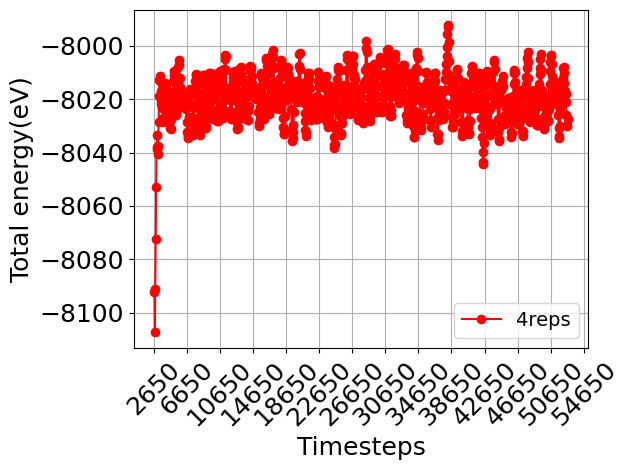

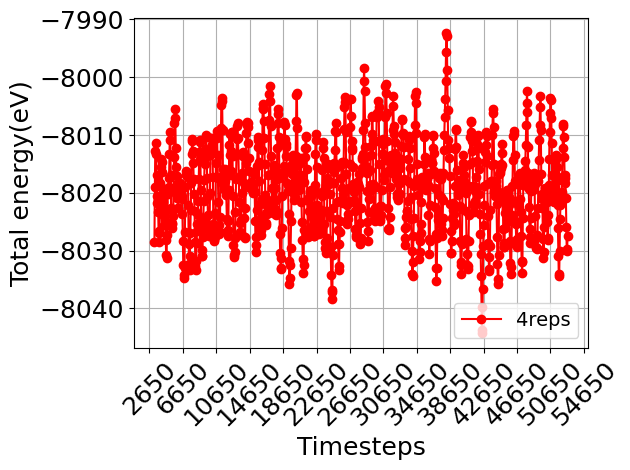

The average of the Energy is: -8019.181764198532 in eV
The Energy (per atom) is: -3.492674984407026 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data

Rep count is 6reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.csv


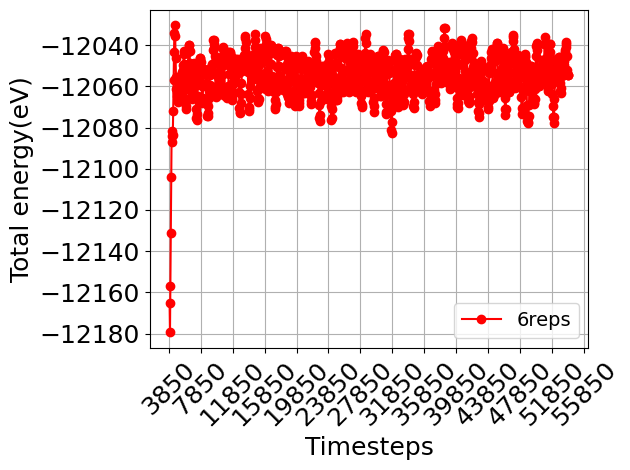

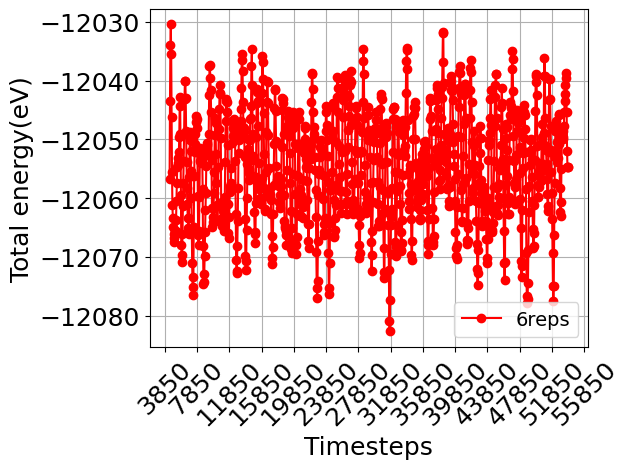

The average of the Energy is: -12054.647174116679 in eV
The Energy (per atom) is: -3.4961273706834914 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data

Rep count is 2reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data/T_1000/thermo_data.csv


The average of the Energy is: -3985.44757185691 in eV
The Energy (per atom) is: -3.483782842532264 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data

Rep count is 8reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data/T_1000/thermo_data.csv


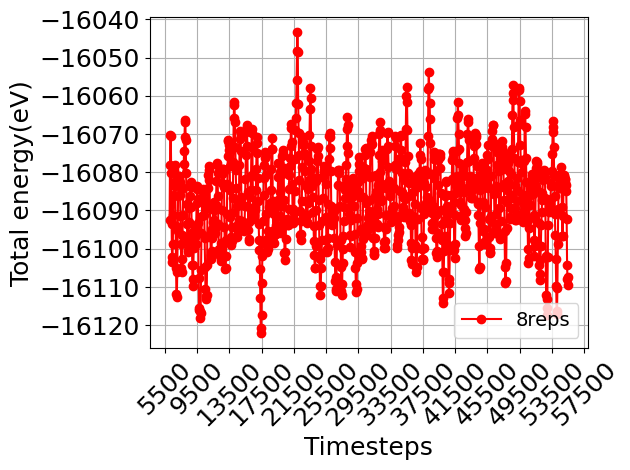

The average of the Energy is: -16087.058534739932 in eV
The Energy (per atom) is: -3.4971866379869416 in eV per atom
The Area of the GB is: 161.61698071053635 (in Å²)
[-6470.0055676183265, -12985.255929415804, -19500.506291213278, -26015.756653010754]

For the Total Energy of the GB:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Total Energy per atom is: [-3.492674984407026, -3.4961273706834914, -3.483782842532264, -3.4971866379869416] (in eV per atom)
The Total Energy is (red): [-3985.44757185691, -8019.181764198532, -12054.647174116679, -16087.058534739932] (in eV)


/tmp/ipykernel_28998/3196245453.py:287: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


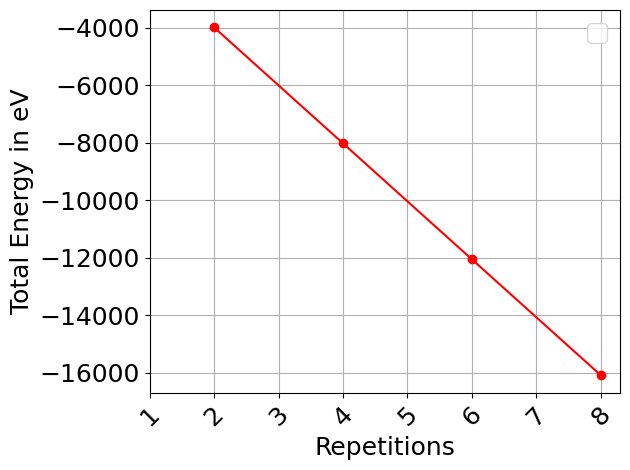


The Total Energies are (red): [-3985.44757185691, -8019.181764198532, -12054.647174116679, -16087.058534739932] (in eV)
The Bulk energies E_b are (orange): [-6470.0055676183265, -12985.255929415804, -19500.506291213278, -26015.756653010754] (in eV)


/tmp/ipykernel_28998/3196245453.py:309: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


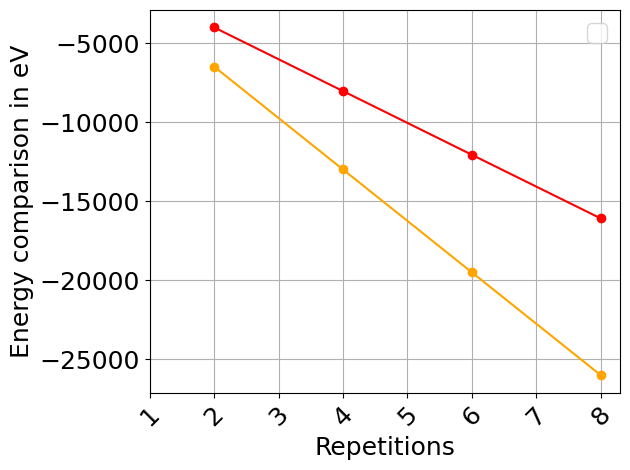


Testing:
The Total energies per atom are: [-3.492674984407026, -3.4961273706834914, -3.483782842532264, -3.4971866379869416]
The Bulk energies per Atom are: [-5.655599272393642, -5.655599272393642, -5.655599272393642, -5.655599272393642] (in eV per Atom)
The Energy difference per Atom is: [2.162924287986616, 2.159471901710151, 2.1718164298613782, 2.1584126344067007] (in eV per Atom)
The Energy difference is: [2474.3853854566887, 4958.147486326507, 7488.423050162032, 9928.698118270824] (in eV)
The Energy difference per Area of the GB is: [15.310181978268917, 30.678382089112176, 46.3343827934402, 61.43350825278435] (in eV/Å²)
The Energy difference per Area of the GB is: [245.2966736194289, 491.5229021553374, 742.3602142399401, 984.2753825244603] (in J/m²)
The Energy difference is: [2474.3853854566887, 4958.147486326507, 7488.423050162032, 9928.698118270824] (in eV)


/tmp/ipykernel_28998/3196245453.py:358: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


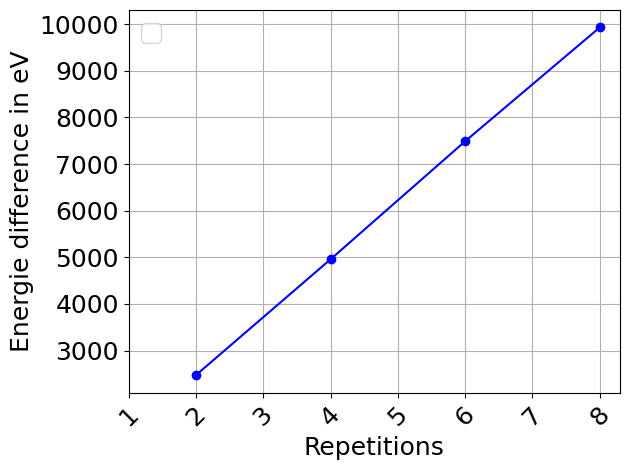



The Total energies per atom are (red): [-3.492674984407026, -3.4961273706834914, -3.483782842532264, -3.4971866379869416] (in eV per Atom)
The Bulk energies per Atom are (orange): [-5.655599272393642, -5.655599272393642, -5.655599272393642, -5.655599272393642] (in eV per Atom)


/tmp/ipykernel_28998/3196245453.py:381: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


The Energy difference per Atom is: [2.162924287986616, 2.159471901710151, 2.1718164298613782, 2.1584126344067007] (in eV)


/tmp/ipykernel_28998/3196245453.py:402: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


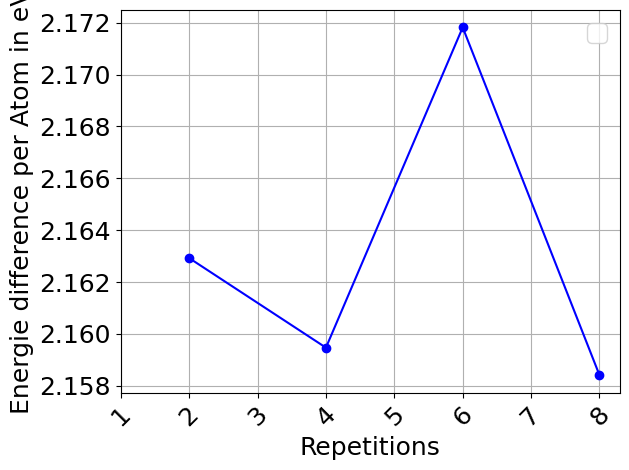



The formation energies are: [246.30512908656942, 492.30870859284, 738.1406649092348, 984.27538252446]


/tmp/ipykernel_28998/3196245453.py:424: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


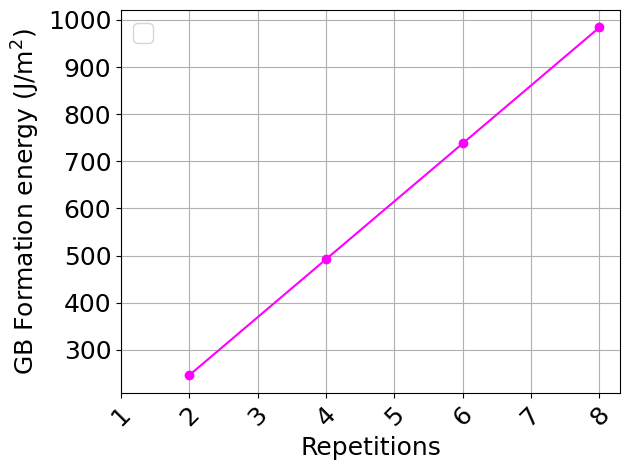


Timestamp:
01-04-2025 18:13


In [39]:
#UP to date 01_04_2025

#Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K
#Use the calculated reference Bulk E_B
#rewritten to ask for user input

# Ask the user for the LAMMPS index
#LAMMPS_index = '008'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables: (needs to be cleaned up)
# new
Total_Energy = [] #needed later
Total_Energy_per_atom = [] #needed later
n_reps = [] #needed later
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

#carry over:
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
rep_count = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# Path of the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

for folder in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*"):
    # Get the parent directory of the file
    parent_folder = folder.parent
    #grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    #if "BULK" in grandparent_folder.name:
    if "BULK" in parent_folder.name:
        continue  # Skip this file and go to the next one
    else:
        # If the folder does not contain "BULK", process the file
        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
      
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found

        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        repeat.append(rep)
        
        if rep_count == repeat[0]:
            print(f"Rep count is {rep}reps\n")
        else:
            print(f"\nRep count is {rep}reps\n")
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")
    
        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
        
        # Step 2.4: plot the Energy over the Timesteps
            
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Total energy(eV)",fontsize = 18)
        plt.tight_layout()
    
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
           
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
        
        # Step 2.6: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
        
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Total_Energy.append(averaged_Energy)
        n_reps.append(len(atoms2))
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

#sort:
#Dummy:
#print(repeat)
repeat = sorted(repeat)
#print(repeat)
#print(n_reps)
n_reps = sorted(n_reps)
#print(n_reps)
Bulk_Energy = [eref_Cu*n_reps[0],eref_Cu*n_reps[1],eref_Cu*n_reps[2],eref_Cu*n_reps[3]]
print(Bulk_Energy)
Total_Energy = sorted(Total_Energy, reverse = True)
               
# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

for i in range(4):
    Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Step 11: plot formation energy over repetitions of the supercell:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:
#Calculating the E_b Bulk_Energy of a Bulk (with 20Å Vacuum on both sides) that has been put through MD at 1000K

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Bulk_Energy = [] #needed later
Bulk_Energy_per_atom = [] #needed later
n_reps = [] #needed later
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    #MD_S9_mini_BULK is a bit of a misnomer (S9 should be removed) but if would have to change the folder creation skript 
    #maybe fix if this part becomes standard procedure
    base_file_path = f"{core_path}/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14-44-31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    if rep_count == repeat[0]:
        print(f"Rep count is {rep_count}reps\n")
    else:
        print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")


    # Step 4: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep_count}reps",color='orange')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Bulk energy(eV)",fontsize = 18)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
    
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    
    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep_count}reps",color='orange')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Bulk_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Bulk_Energy_per_atom.append(Divided_Energy)
    print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")


# Step 9: print values

print("\nFor the Bulk Energy:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Bulk Energy per atom is: {Bulk_Energy_per_atom} (in eV per atom)")
print(f"The Bulk Energy is: {Bulk_Energy} (in eV)")

# Step 10: plot BULK energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('BULK energy (eV)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/ref_Bulk_energy_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()




# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format




In [ ]:
#1st Calculating the E_b Bulk_Energy of a Bulk (with 20Å Vacuum on both sides) that has been put through MD at 1000K

import csv

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Bulk_Energy = [] #needed later
Bulk_Energy_per_atom = [] #needed later
n_reps = [] #needed later
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    #MD_S9_mini_BULK is a bit of a misnomer (S9 should be removed) but if would have to change the folder creation skript 
    #maybe fix if this part becomes standard procedure
    base_file_path = f"{core_path}/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14-44-31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    #if rep_count == repeat[0]:
    #    print(f"Rep count is {rep_count}reps\n")
    #else:
    #    print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    #print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")


    # Step 4: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep_count}reps",color='orange')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Bulk energy(eV)",fontsize = 18)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()

    
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    

    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep_count}reps",color='orange')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()

    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    #print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Bulk_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Bulk_Energy_per_atom.append(Divided_Energy)
    #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")


# Step 9: print values for the Bulk Energy

print("For the Bulk Energy:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Bulk Energy per atom is: {Bulk_Energy_per_atom} (in eV per atom)")
print(f"The Bulk Energy is (orange): {Bulk_Energy} (in eV)")

# Step 10: plot BULK energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('BULK energy (eV)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/ref_Bulk_energy_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

#-------------------------------------------------- <--To Do: cleaner inclusion E_bulk calc


#2nd Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K with in 1 defined E_b

# Define the paths for input and output files
core_path = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
#base_file_path = f"{core_path}/Old_Work_pre_feburary/Submited_mini_data_folders/z_old_Submission_batch7_MD_vacuum_04-02-2025/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000"
Total_Energy = [] #needed later
Total_Energy_per_atom = [] #needed later
n_reps = [] #needed later

repeat = [2,4,6,8]
#rep_count = repeat[0]

Temp = 1000 #(in K)
Temp_folder = f"T_{Temp}"

for rep_count in repeat:
    base_file_path = f"{core_path}/LAMMPS_Submision_006_19-03-2025_17-39-59/4_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_007_20-03-2025_14-44-31/4_Submited_mini_data_folders/0_MD_long_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    #base_file_path = f"{core_path}/LAMMPS_Submision_008_24-03-2025_18-01-24/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-{rep_count}rep_10A_VACUUMS.data/{Temp_folder}"
    txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
    csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
    atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
    
    #if rep_count == repeat[0]:
    #    print(f"Rep count is {rep_count}reps\n")
    #else:
    #    print(f"\nRep count is {rep_count}reps\n")
    
    # Step 1: Convert .txt to .csv
    with open(txt_file_path, 'r') as txt_file:
        lines = txt_file.readlines()
    # Use builtins' open to avoid IPython file handle restrictions
    import builtins
    # Create an empty CSV file
    with builtins.open(csv_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
    #print(f"Empty CSV file created at {csv_file_path}")
    
    # Open a new CSV file to write the converted content
    with open(csv_file_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)    
        # Iterate through each line of the .txt file
        for line in lines:
            # Assuming space or tab separation, split line by whitespace
            row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
            csv_writer.writerow(row)
    
    # Step 2: Read the first column of the .csv file starting from the second row
    first_column = []  # Create an empty list to store the first column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 1st column value to an integer and append to the list
                    first_column.append(int(row[0]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                    print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
    
    # Output the first column as a list
    #print(first_column)
    list_length = len(first_column)
    #print(f"The length of the first_column list is: {list_length}")
    #print("\n")

    # Step 3: Read the third column of the .csv file starting from the second row
    third_column = []  # Create an empty list to store the third column
    
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        # Skip the header (1st row)
        next(csv_reader)
        # Iterate through the rows starting from the 2nd row
        for row in csv_reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                try:
                    # Convert the 3rd column value to a float and append to the list
                    third_column.append(float(row[2]))
                except ValueError:
                    # In case the conversion fails (e.g., if it's not a valid float), skip that value
                    print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
    
    # Output the third column as a list (contains Total Energy of the Supercell in eV)
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")

    # Step 4: plot the Energy over the Timesteps
       
    plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep_count}reps",color='red')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel("Total energy(eV)",fontsize = 18)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()

    
    # Step 5: cut out the first 10 steps to reduce the spread
    
    #print(first_column)
    list_length = len(first_column)
    #print("Cutting startup:")
    #print(f"The length of the first_column list is: {list_length}")
    # Remove the first 10 entries
    first_column_no_startup = first_column[10:]
    # Print the updated list length
    list_length = len(first_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")
    #print("\n")
    #print(third_column)
    list_length = len(third_column)
    #print(f"The length of the third_column list is: {list_length}")
    # Remove the first 10 entries
    third_column_no_startup = third_column[10:]
    # Print the updated list length
    list_length = len(third_column_no_startup)
    #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
    #print(f"The new length of the first_column list is: {list_length}")

    
    # Step 6: plot the Energy over the Timesteps
    
    plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep_count}reps",color='red')
    plt.grid(True)
    plt.legend(fontsize="14", loc ="lower right")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
    plt.xlabel('Timesteps',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"{common_graph_folder}/{rep_count}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
    plt.show()
    #if rep_count == 2:
    #    plt.show()
    
    # Step 7: Avarage the energy
    
    # Calculate the average
    averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
    #print(f"The average of the Energy is: {averaged_Energy} in eV")
    Undivided_Energy = averaged_Energy

    Total_Energy.append(averaged_Energy)
    n_reps.append(len(atoms2))

    # Step 8 divide by atom count (needed?)
    
    Divided_Energy = Undivided_Energy/len(atoms2)
    Total_Energy_per_atom.append(Divided_Energy)
    #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
    

# Step 9: print values for the Total Energy of the GB

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

#plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_Energy_ver_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 10: calculate formation energy for each repetition

xAg = 0
A = 157.30529027915497
print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")
#kB = 1.380649*(10^(-23)) #in (m^2 kg s^-2 K^-1 or J K^-1)
#Mit Elektronenvolt (eV) als Energieeinheit hat die Boltzmann-Konstante den – ebenfalls exakten – Wert 8.617333262*(10^(-5)) (eV/K)
#kB = 8.617333262*(10**(-5))
#print(f"\nkB is: {kB}")
#note that Test = 10^(-5) #--> =-15!!! --> use Test = 10**(-5)
#temp_scaling_term = (kB*Temp)       #kB*T characteristic energy kBT associated with a single microscopic degree of freedom, (1DoF)
#                                    #where T denotes temperature and kB denotes the Boltzmann constant.


formation_Energy = []

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    formation_Energy.append(eform)                                                   

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

#plot comparison Total energy and Bulk energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()




#Testing:
#KEIN fehler in der Formel !!!
Bulk_Energy_per_Atom = []
Ediff = []
Ediff_per_area = []
Ediff_per_Atom = []
Ediff_per_area_inJ = []
for i in range(4):
    Bulk_Energy_per_Atom.append(Bulk_Energy[i]/n_reps[i])
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_Atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_Atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_Atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_Atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

#plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom}")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_Atom} (in eV per Atom)")

#plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_Atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_Atom} (in eV)")

#plot Ediff per atom over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_Atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()



print("\n")
print(f"The formation energies are: {formation_Energy}")


# Step 10: plot formation energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Folder name for 009 is: LAMMPS_Submision_009_01-04-2025_17-50-00
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-2rep_10A_VACUUMS.data


FIX ME PLEASE:2


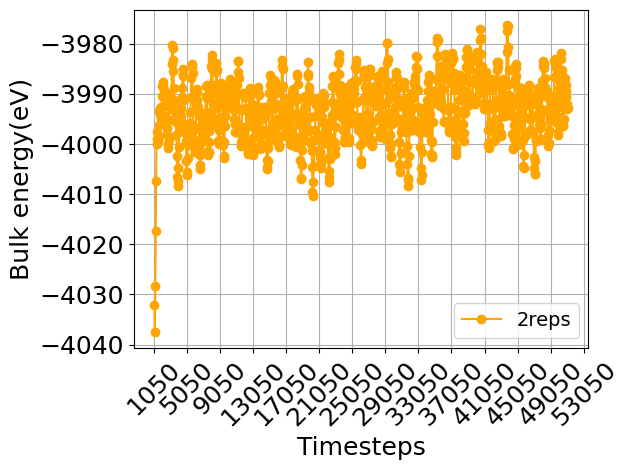

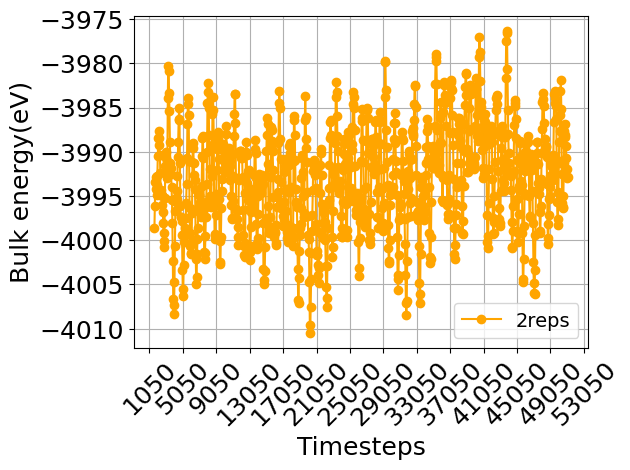

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-4rep_10A_VACUUMS.data


FIX ME PLEASE:4


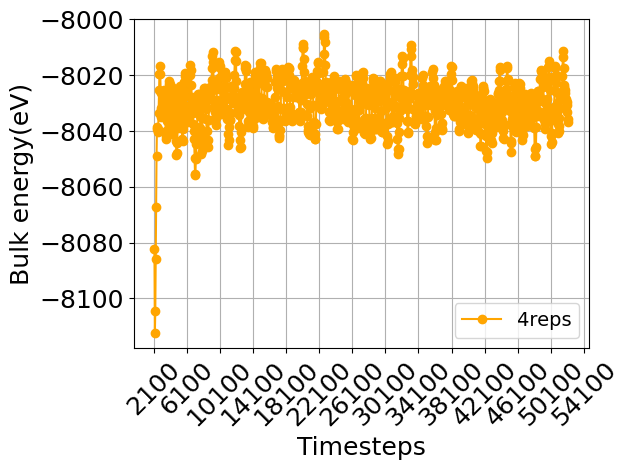

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-6rep_10A_VACUUMS.data


FIX ME PLEASE:6


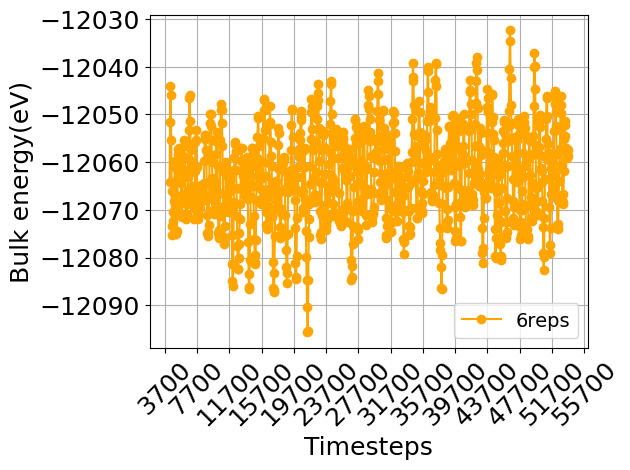

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_BULK-CuGaSe2-8rep_10A_VACUUMS.data


FIX ME PLEASE:8


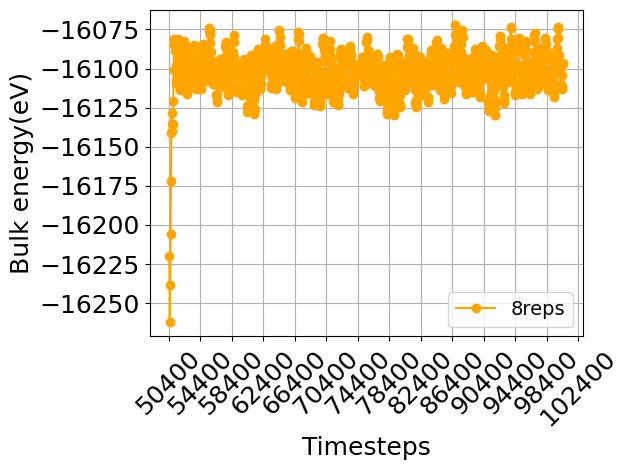

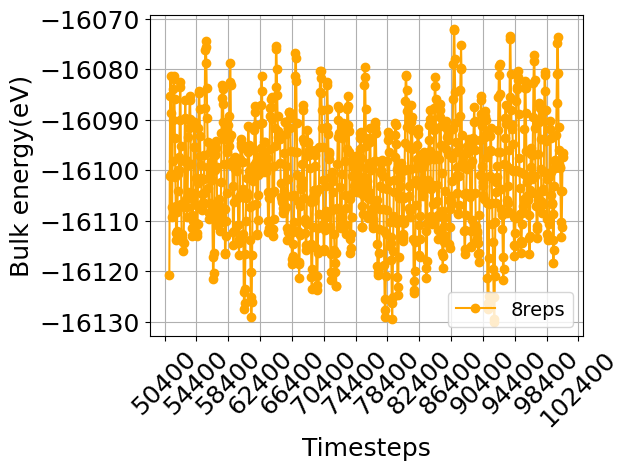

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data


FIX ME PLEASE:2

Rep count is 2reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-2rep_10A_VACUUMS.data/T_1000/thermo_data.csv


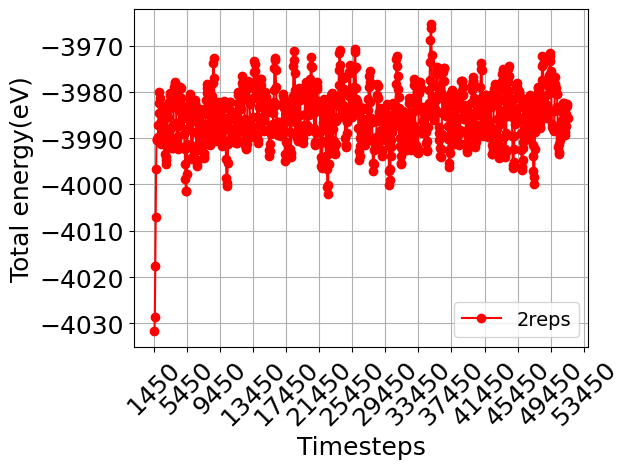

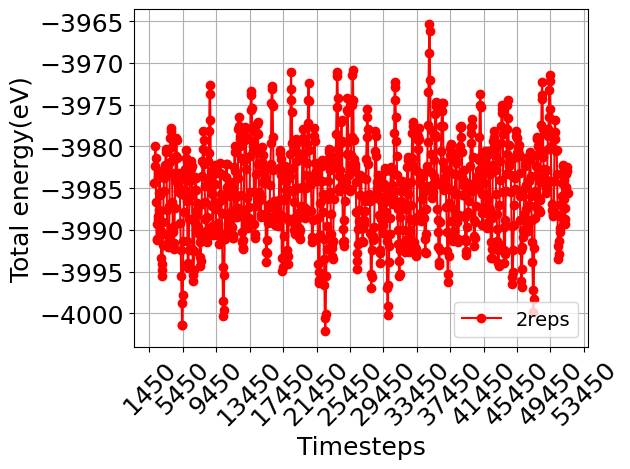

The average of the Energy is: -3985.44757185691 in eV
The Energy (per atom) is: -3.483782842532264 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data


FIX ME PLEASE:4

Rep count is 4reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-4rep_10A_VACUUMS.data/T_1000/thermo_data.csv


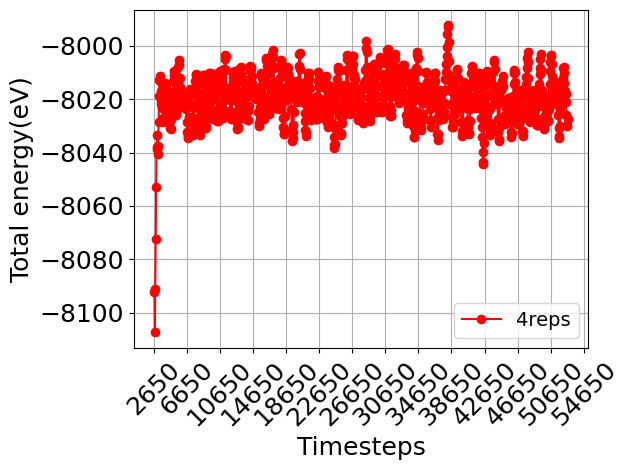

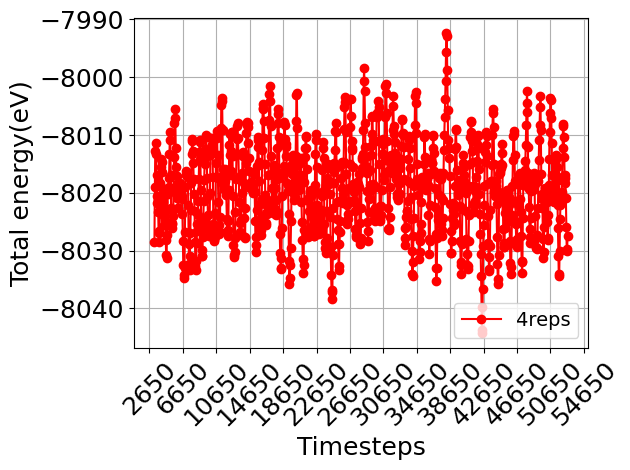

The average of the Energy is: -8019.181764198532 in eV
The Energy (per atom) is: -3.492674984407026 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data


FIX ME PLEASE:6

Rep count is 6reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-6rep_10A_VACUUMS.data/T_1000/thermo_data.csv


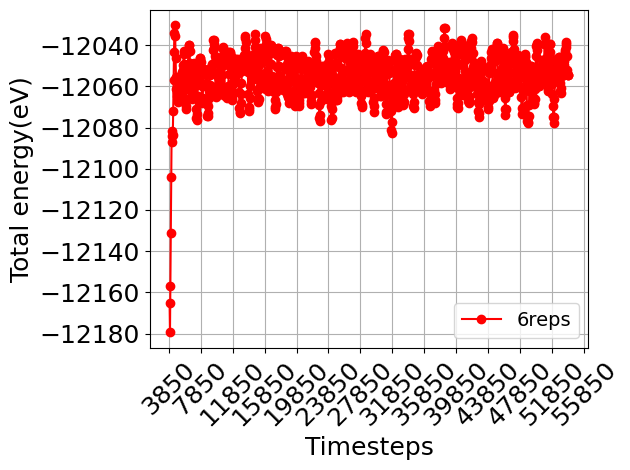

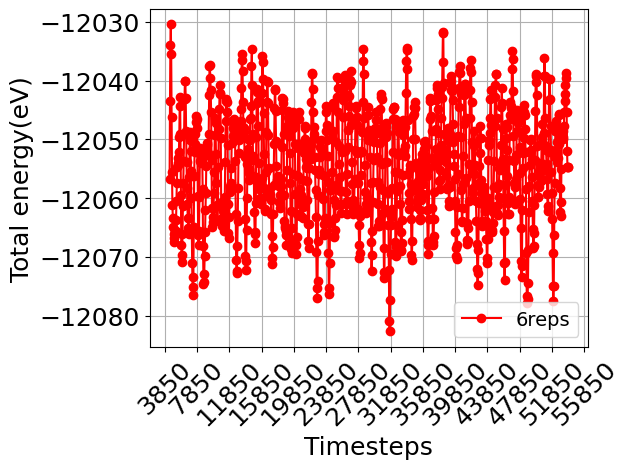

The average of the Energy is: -12054.647174116679 in eV
The Energy (per atom) is: -3.4961273706834914 in eV per atom
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data


FIX ME PLEASE:8

Rep count is 8reps

Empty CSV file created at /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_009_01-04-2025_17-50-00/8_Submited_mini_data_folders/0_MD_S9_mini_GB-S9-CuGaSe2-8rep_10A_VACUUMS.data/T_1000/thermo_data.csv


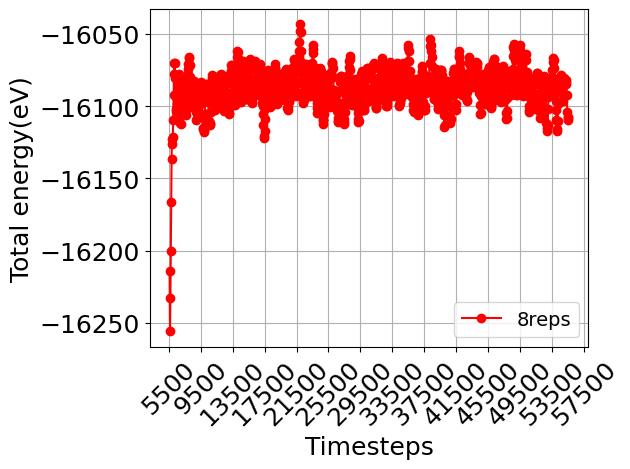

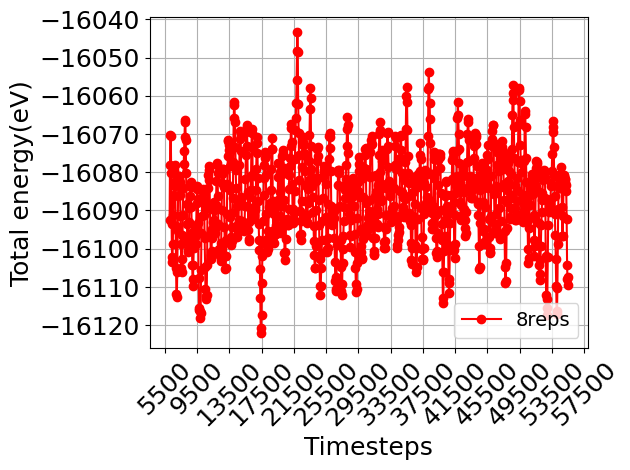

The average of the Energy is: -16087.058534739932 in eV
The Energy (per atom) is: -3.4971866379869416 in eV per atom
The Area of the GB is: 161.61698071053635 (in Å²)

For the Total Energy of the GB:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Total Energy per atom is: [-3.483782842532264, -3.492674984407026, -3.4961273706834914, -3.4971866379869416] (in eV per atom)
The Total Energy is (red): [-3985.44757185691, -8019.181764198532, -12054.647174116679, -16087.058534739932] (in eV)


/tmp/ipykernel_28998/3498207678.py:459: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


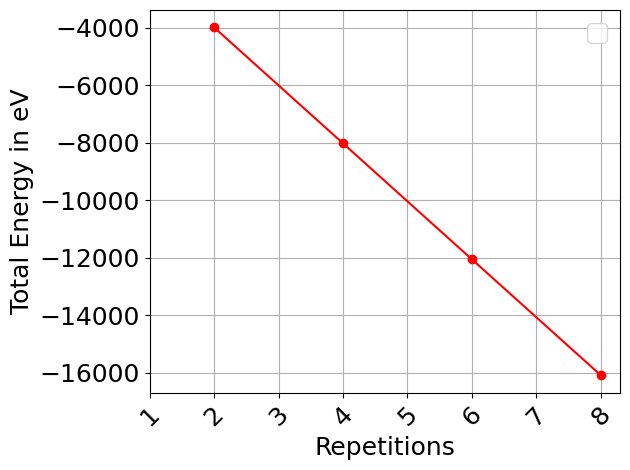

For the Bulk Energy:
For the repetition count: [2, 4, 6, 8]
The Atom count is: [1144, 2296, 3448, 4600] (no unit)
The Bulk Energy per atom is: [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per atom)
The Bulk Energy is (orange): [-3993.092815690117, -8029.99431505763, -12062.77247198676, -16101.256415140519] (in eV)


/tmp/ipykernel_28998/3498207678.py:485: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


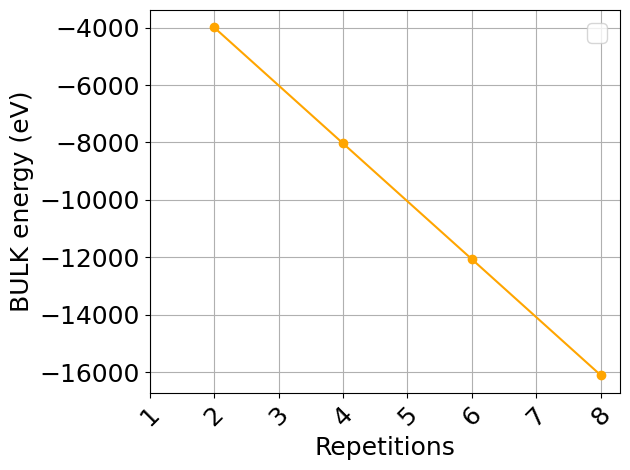


The Total Energies are (red): [-3985.44757185691, -8019.181764198532, -12054.647174116679, -16087.058534739932] (in eV)
The Bulk energies E_b are (orange): [-3993.092815690117, -8029.99431505763, -12062.77247198676, -16101.256415140519] (in eV)


/tmp/ipykernel_28998/3498207678.py:507: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


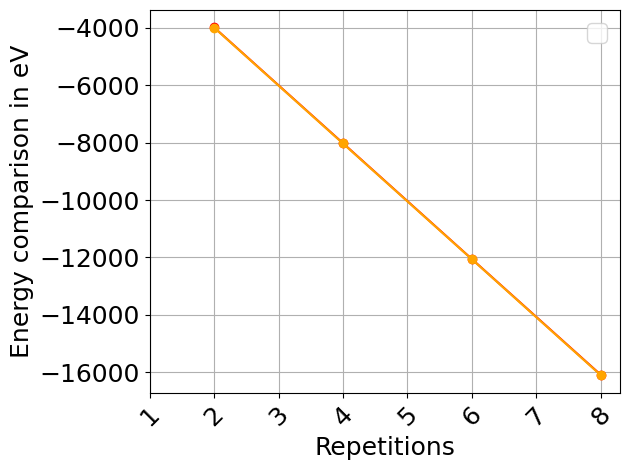


Testing:
The Total energies per atom are: [-3.483782842532264, -3.492674984407026, -3.4961273706834914, -3.4971866379869416]
The Bulk energies per Atom are: [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per Atom)
The Energy difference per Atom is: [0.006682905448607279, 0.004709299154659341, 0.0023565249043158154, 0.0030864957392582326] (in eV per Atom)
The Energy difference is: [7.645243833206727, 10.812550859097847, 8.125297870080932, 14.19788040058787] (in eV)
The Energy difference per Area of the GB is: [0.04730470647078676, 0.06690231936991593, 0.0502750257699327, 0.08784893974734588] (in eV/Å²)
The Energy difference per Area of the GB is: [0.7579065461336513, 1.071895580480919, 0.8054964078807078, 1.407498142844026] (in J/m²)
The Energy difference is: [7.645243833206727, 10.812550859097847, 8.125297870080932, 14.19788040058787] (in eV)


/tmp/ipykernel_28998/3498207678.py:556: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


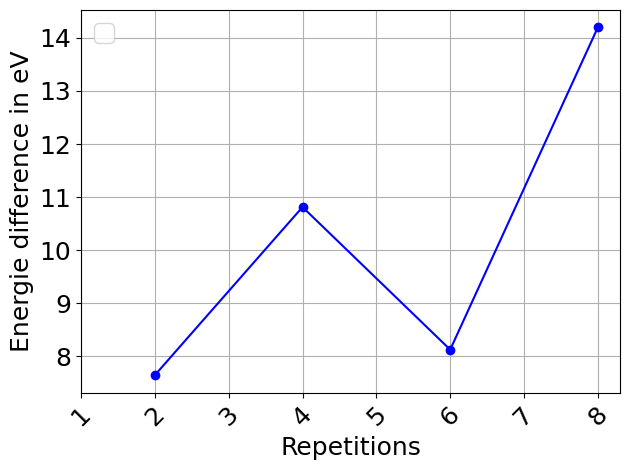



The Total energies per atom are (red): [-3.483782842532264, -3.492674984407026, -3.4961273706834914, -3.4971866379869416] (in eV per Atom)
The Bulk energies per Atom are (orange): [-3.4904657479808714, -3.4973842835616855, -3.4984838955878073, -3.5002731337262] (in eV per Atom)


/tmp/ipykernel_28998/3498207678.py:579: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


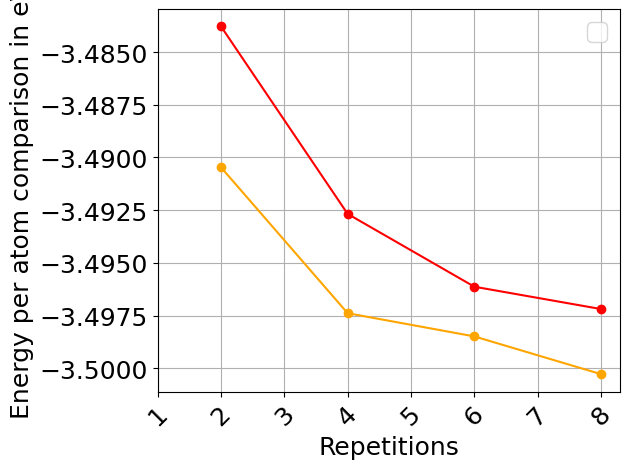

The Energy difference per Atom is: [0.006682905448607279, 0.004709299154659341, 0.0023565249043158154, 0.0030864957392582326] (in eV)


/tmp/ipykernel_28998/3498207678.py:600: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


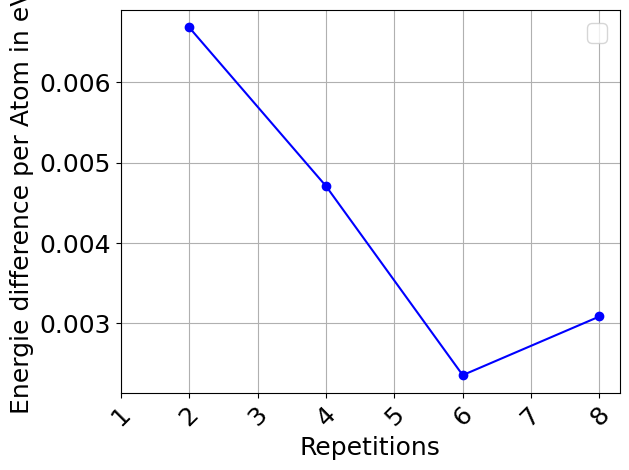



The formation energies are: [0.7579065461336463, 1.0718955804809678, 0.8054964078807482, 1.407498142843906]


/tmp/ipykernel_28998/3498207678.py:622: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


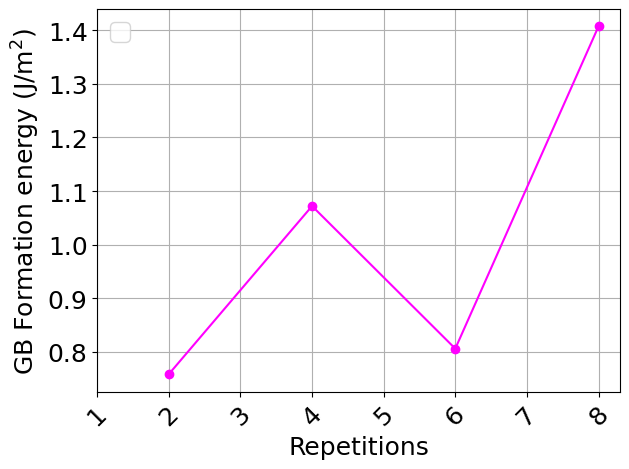


Timestamp:
01-04-2025 18:57


In [45]:
#UP to date 01_04_2025 REWORKED:

#All-in-one-systematic thermo-calc read:
#rewritten to ask for user input
#Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K 
#with E-B reference out of LAMMPS

# Ask the user for the LAMMPS index
#LAMMPS_index = '009'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables: (needs to be cleaned up)
# new
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

#carry over:
Formation_Energy = []

rep = []
bulk_rep = []
rep_count = []
repeat = []
bulk_repeat = []
n_reps = []

e_pot = []
e_bulk = []
Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# Path of the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

#WARNING,sorts by timestamp, not name!!!
#causes issue whe editing LAMMPS_Submision
for folder in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*"):
    # Get the parent directory of the file
    parent_folder = folder.parent
    #grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    #if "BULK" in grandparent_folder.name:
    if "BULK" in parent_folder.name:
        # If the folder does contain "BULK", process the file
     
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{bulk_rep}")
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found

        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file

        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        bulk_repeat.append(bulk_rep)
        #if rep_count == repeat[0]:
        #    print(f"Rep count is {rep_count}reps\n")
        #else:
        #    print(f"\nRep count is {rep_count}reps\n")
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        #print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")
    
        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
    
        # Step 2.4: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{bulk_rep}reps",color='orange')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="best")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Bulk energy(eV)",fontsize = 18)
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
    
        
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
    
        # Step 2.6: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{bulk_rep}reps",color='orange')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
    
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        #print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Bulk_Energy.append(averaged_Energy)
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Bulk_Energy_per_atom.append(Divided_Energy)
        #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

    else:
        # If the folder does not contain "BULK", process the file    
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{rep}")
        else:
            print(f"Skipping file {data_file.name}: No repetition found")
            continue  # Skip if no repetition is found
            
        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
        
        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        repeat.append(rep)
        
        if rep_count == repeat[0]:
            print(f"Rep count is {rep}reps\n")
        else:
            print(f"\nRep count is {rep}reps\n")
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")
    
        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
        
        # Step 2.4: plot the Energy over the Timesteps
            
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Total energy(eV)",fontsize = 18)
        plt.tight_layout()
    
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
           
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
        
        # Step 2.6: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') #<-----------------Needs fix
        plt.show()
        #if rep_count == 2:
        #    plt.show()
        
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Total_Energy.append(averaged_Energy)
        n_reps.append(len(atoms2))
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

"""
#sort:
#print(repeat)
repeat = sorted(repeat)
#print(repeat)
#print(n_reps)
n_reps = sorted(n_reps)
#print(n_reps)
#print(Bulk_Energy)
Bulk_Energy = sorted(Bulk_Energy, reverse = True)
#print(Bulk_Energy)
Total_Energy = sorted(Total_Energy, reverse = True)
"""
               
# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Total_Energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 9: print values for the Bulk Energy

print("For the Bulk Energy:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Bulk Energy per atom is: {Bulk_Energy_per_atom} (in eV per atom)")
print(f"The Bulk Energy is (orange): {Bulk_Energy} (in eV)")

# Step 10: plot BULK energy over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('BULK energy (eV)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/ref_Bulk_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

#for i in range(4):
#    Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_atom)),marker='o',label='',color='orange')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell

plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()


# Step 11: plot formation energy over repetitions of the supercell:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()

# Show the plot
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') #<-----------------Needs fix
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:


























#New Section




























In [ ]:
#Create vacancies / Ag inclusions or maybe interstitials

In [ ]:
#Anwählen der Cu Positionen (NOT FUNCTIONAL ONLY THEORY)

GB = read('/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/ASE_Inbetween_steps/GB-S9-CuGaSe2.vasp')
'''
Number_Atoms = list(GB.symbols)
print(Number_Atoms.count('Ga'))
print(Number_Atoms.count('Ag'))
print(Number_Atoms.count('Cu'))
print(Number_Atoms.count('Se'))
'''
view(GB)

#Schritt 0 read .vasp

#Schritt 1 Cu pos > center angeben (#id +z pos)
#idee: get position/scaled_position/???

#Schritt 2 Cu pos zuordnen [#id zu z pos]
#idee: dictionary type |

#Schritt 3 nach z sortieren [z min zu z max]
#idee: dictionary type |

#Schritt 4 systematisch 1 löschen + datei Speichern 
#idee: for loop mit ifelse statements | #"del GB[index]"

#Schritt 4b) systematisch 1 ersetzen + datei Speichern 
#idee: for loop mit ifelse statements | ???



In [ ]:
#15 sigma3_Ag-in-Cu (NOT FUNCTIONAL ONLY THEORY)

# Replaces each Cu atom in the reference with an Ag atom
# Optimizes the resulting structure, and calculates the total energy after the substitution. 
# The data collected (atomic coordinates and defect energies) can be used to analyze how the substitution affects the material,
# potentially indicating the stability and energetics of Ag substitution in different Cu sites.

cu_indices = [i for i, symbol in enumerate(atoms.get_chemical_symbols()) if symbol == 'Cu']

cu_x_coordinates = []
cu_y_coordinates = []
cu_z_coordinates = []
defect_energy = []

for cu_index in cu_indices:
    cu_position = atoms[cu_index].position
    cu_x_coordinates.append(cu_position[0])
    cu_y_coordinates.append(cu_position[1])
    cu_z_coordinates.append(cu_position[2])

    # Create a defect structure with Cu replaced by Ag
    Defect_Structure = atoms.copy()
    Defect_Structure[cu_index].symbol = 'Ag'

    # Set calculator for the defect structure
    Defect_Structure.set_calculator(potential)

    # Optimize the defect structure
    optimize(Defect_Structure, write=True, fname=f'POSCAR_{cu_index}')
    
    # Calculate the energy of the defect structure
    Full_energy_Defect_uncorrected = Defect_Structure.get_potential_energy()
    Full_energy_Defect = Corrected_Energy(Full_energy_Defect_uncorrected,Defect_Structure)
    defect_energy.append(Full_energy_Defect)

In [ ]:
#18 Sigma3_Cu #by melissa (NOT FUNCTIONAL ONLY THEORY)

# Creates defect vacancies based on the index of Cu atoms from the refernece in cell [7].
# For each Cu atom:
   # The coordinates of the atom are stored.
   # A new structure is created by removing the Cu atom, representing a vacancy.
   # This defect structure is then optimized, and the total energy is calculated and stored.
   # The optimized structure with the vacancy is saved as a POSCAR file.

cu_indices = [i for i, symbol in enumerate(atoms.get_chemical_symbols()) if symbol == 'Cu']

cu_x_coordinates = []
cu_y_coordinates = []
cu_z_coordinates = []
defect_energy = []

for cu_index in cu_indices:
    cu_position = atoms[cu_index].position
    cu_x_coordinates.append(cu_position[0])
    cu_y_coordinates.append(cu_position[1])
    cu_z_coordinates.append(cu_position[2])
    defect_structure = atoms.copy()
    del defect_structure[cu_index]
    defect_structure.set_calculator(potential)  # Set calculator again
    optimize(defect_structure, write=True, fname=f'POSCAR_{cu_index}')
    Full_energy_Defect_uncorrected = Defect_Structure.get_potential_energy()
    Full_energy_Defect = Corrected_Energy(Full_energy_Defect_uncorrected,Defect_Structure)
    defect_energy.append(Full_energy_Defect)

In [ ]:
#18 Sigma3_Cu #by melissa (NOT FUNCTIONAL ONLY THEORY)

# Plots the calculated total energies for each vacancy position against the z-coordinates of the Cu vacancies 
# to observe how the energy changes as a function of the Cu atom's position along the z-axis.
# Note that the plot below is not in the correct sequence, so the code has to be modfied.

plt.scatter(cu_z_coordinates, defect_energy, color='blue')
plt.xlabel('Cu vacancies along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.show()


In [ ]:
#18 Sigma3_Cu #by melissa (NOT FUNCTIONAL ONLY THEORY)

# Save cu_x_coordinates, cu_y_coordinates, cu_z_coordinates, and Defect_energy to a text file.

with open('defect_data_Cu_sigma3_xyz_all_ordered_simplified.txt', 'w') as file:
    file.write('x-coordinate, y-coordinate, z-coordinate, Defect Energy\n')
    for x, y, z, energy in zip(cu_x_coordinates, cu_y_coordinates, cu_z_coordinates, defect_energy):
        file.write(f'{x}, {y}, {z}, {energy}\n')

print('Data saved to defect_data_Cu_sigma3_xyz_all_ordered_simplified.txt')